# 1. Business Understanding



## 1.1 Define Project Goals and Stakeholder Needs



### Project Goals



- **Identify Key Drivers of Economic Performance:**

  - Analyze which financial indicators most strongly influence a composite measure of financial development (e.g., Financial_Depth or Financial_Depth_log).

- **Assess Variations Across Subgroups:**

  - Examine how these indicators and their impacts vary across different regions and income groups.

- **Generate Actionable Insights:**

  - Provide recommendations for policy measures that could enhance financial stability and promote economic growth.

- **Develop Robust Predictive Models:**

  - Build models that not only forecast economic outcomes but also explain the underlying relationships, thereby supporting informed decision-making.



### Stakeholder Needs



- **Policy Makers:**

  - Require detailed, data-driven insights to shape economic policies and improve financial stability.

- **Financial Institutions and Investors:**

  - Need to understand which indicators signal opportunities or risks and how these vary by region/income level.

- **Researchers and Economists:**

  - Seek rigorous, interpretable analyses to support academic research and public discourse on economic development.

- **General Public:**

  - Benefit from clear explanations about how financial health impacts overall economic performance.



## 1.2 Key Business Questions



- **What are the main financial indicators that influence economic performance and stability?**

- **How do the impacts of these indicators differ across regions and income groups?**

- **Can we use a composite measure (e.g., Financial_Depth or Financial_Depth_log) to summarize the financial system’s development effectively?**

- **What policy measures could enhance financial development and stability, based on the influence of these indicators?**



# Step 2: Data Understanding

In this phase, we aim to develop a deep understanding of the available data, assess its quality, and uncover initial insights. This will inform our subsequent data preparation and modeling steps.

## 2.1 Explore Data Sources and Assess Data Quality


**Below is a list of the primary financial indicators that form the core of your analysis:**



- **Domestic credit provided by the financial sector (% of GDP)**

  - *Indicator Code:* FS.AST.DOMS.GD.ZS

  - *Corresponding Meta Data File:* Metadata_Country_API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv (Part 4)



- **Domestic credit to private sector by banks (% of GDP)**

  - *Indicator Code:* FD.AST.PRVT.GD.ZS

  - *Corresponding Meta Data File:* Metadata_Country_API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv (Part 2)



- **Domestic credit to private sector (% of GDP)**

  - *Indicator Code:* FS.AST.PRVT.GD.ZS

  - *Corresponding Meta Data File:* Metadata_Country_API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv (Final meta data file)



- **Broad money (% of GDP)**

  - *Indicator Code:* FM.LBL.BMNY.GD.ZS

  - *Corresponding Meta Data File:* Metadata_Country_API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv (Part 3)



- **Foreign direct investment, net inflows (% of GDP)**

  - *Indicator Code:* BX.KLT.DINV.WD.GD.ZS

  - *Corresponding Meta Data File:* Metadata_Indicator_API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv



- **Bank nonperforming loans to total gross loans (%)**

  - *Indicator Code:* FB.AST.NPER.ZS

  - *Corresponding Meta Data File:* Metadata_Indicator_API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv



In [1278]:
!pip install xgboost

In [1279]:
!pip install shap

In [1280]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
import scipy
print("scipy version:", scipy.__version__)

from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import shap
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

pandas version: 2.0.3
numpy version: 1.24.3
scikit-learn version: 1.3.0
matplotlib version: 3.7.2
seaborn version: 0.12.2
scipy version: 1.11.1


In [1281]:
# List of all file names with the './data/' prefix

def load_csv_with_skip(file, skip_rows=4, **kwargs):
    """
    Attempts to load a CSV file while skipping the first 'skip_rows' lines.
    """

    try:
        df = pd.read_csv(file, encoding='latin1', skiprows=skip_rows, **kwargs)
        return df
    except Exception as e:
        print(f"Error loading {file}: {e}")
        return None
    
# Define file lists for each category
primary_files = [
    "./data/API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv",
    "./data/API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv",
    "./data/API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv",
    "./data/API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv",
    "./data/API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv",
    "./data/API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv"
]

country_meta_files = [
    "./data/Metadata_Country_API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv",
    "./data/Metadata_Country_API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv",
    "./data/Metadata_Country_API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv",
    "./data/Metadata_Country_API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv",
    "./data/Metadata_Country_API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv",
    "./data/Metadata_Country_API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv"
]

indicator_meta_files = [
    "./data/Metadata_Indicator_API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv",
    "./data/Metadata_Indicator_API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv",
    "./data/Metadata_Indicator_API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv",
    "./data/Metadata_Indicator_API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv",
    "./data/Metadata_Indicator_API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv",
    "./data/Metadata_Indicator_API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv"
]

# Dictionaries to store each group's DataFrames
primary_data = {}
country_meta_data = {}
indicator_meta_data = {}

def load_and_inspect(files, group_name, skip_rows=4):
    """
    Loads each CSV file in 'files' using a skiprows parameter.
    Prints head, a random sample, info, and describe outputs.
    """
    print(f"\n==== Loading {group_name} Files ====\n")

    for file in files:
        try:
            # Use skip_rows only for the primary files; meta data files usually load without it.
            df = pd.read_csv(file, encoding='latin1', skiprows=skip_rows) if group_name == "Primary Financial Indicators" else pd.read_csv(file, encoding='latin1')
            print(f"Loaded file: {file}")
            print("-" * 60)
            print("Head:")
            print(df.head(), "\n")
         
            # If the DataFrame has less than 5 rows, take all rows; otherwise sample 5.
            sample_n = min(5, len(df))
            print(f"Random Sample ({sample_n} rows):")
            print(df.sample(sample_n, random_state=42), "\n")   
            print("Info:")
            df.info()
            print("\n")     
            print("Describe:")
            print(df.describe(include='all'), "\n")          

            # Verify presence of key identifiers
            if 'Country Code' in df.columns:
                print("Key identifier 'Country Code' is present.\n")
            elif 'country_code' in df.columns:
                print("Key identifier 'country_code' is present.\n")
            else:
                print("Warning: No key identifier found in this file.\n")    
            print("=" * 80, "\n")
            yield file, df
        except Exception as e:
            print(f"Error loading {file}: {e}\n")

### Load and inspect the primary finacial indicators

In [1282]:
# Load Primary Financial Indicators files (using skiprows=4 for these)
for f, d in load_and_inspect(primary_files, "Primary Financial Indicators", skip_rows=4):
    primary_data[f] = d


==== Loading Primary Financial Indicators Files ====

Loaded file: ./data/API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv
------------------------------------------------------------
Head:
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                                      Indicator Name        Indicator Code  \
0  Foreign direct investment, net inflows (% of GDP)  BX.KLT.DINV.WD.GD.ZS   
1  Foreign direct investment, net inflows (% of GDP)  BX.KLT.DINV.WD.GD.ZS   
2  Foreign direct investment, net inflows (% of GDP)  BX.KLT.DINV.WD.GD.ZS   
3  Foreign direct investment, net inflows (% of GDP)  BX.KLT.DINV.WD.GD.ZS   
4  Foreign direct investment, net inflows (% of GDP)  BX.KLT.DINV.WD.GD.ZS   

   1960  1961  1962  1963  1964  1965  ...       2015    

Loaded file: ./data/API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv
------------------------------------------------------------
Head:
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                                      Indicator Name     Indicator Code  \
0  Domestic credit to private sector by banks (% ...  FD.AST.PRVT.GD.ZS   
1  Domestic credit to private sector by banks (% ...  FD.AST.PRVT.GD.ZS   
2  Domestic credit to private sector by banks (% ...  FD.AST.PRVT.GD.ZS   
3  Domestic credit to private sector by banks (% ...  FD.AST.PRVT.GD.ZS   
4  Domestic credit to private sector by banks (% ...  FD.AST.PRVT.GD.ZS   

      1960      1961      1962      1963     1964       1965  ...       2015  \
0      NaN       NaN       NaN       NaN      NaN    

       Country Name Country Code          Indicator Name     Indicator Code  \
count           266          266                     266                266   
unique          266          266                       1                  1   
top           Aruba          ABW  Broad money (% of GDP)  FM.LBL.BMNY.GD.ZS   
freq              1            1                     266                266   
mean            NaN          NaN                     NaN                NaN   
std             NaN          NaN                     NaN                NaN   
min             NaN          NaN                     NaN                NaN   
25%             NaN          NaN                     NaN                NaN   
50%             NaN          NaN                     NaN                NaN   
75%             NaN          NaN                     NaN                NaN   
max             NaN          NaN                     NaN                NaN   

             1960       1961        1962        196

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            63 non-null     float64
 5   1961            64 non-null     float64
 6   1962            78 non-null     float64
 7   1963            82 non-null     float64
 8   1964            84 non-null     float64
 9   1965            90 non-null     float64
 10  1966            92 non-null     float64
 11  1967            92 non-null     float64
 12  1968            92 non-null     float64
 13  1969            92 non-null     float64
 14  1970            97 non-null     float64
 15  1971            98 non-null     float64
 16  1972            102 non-null    float64
 17  1973            105 non-null    flo

### Load Country-Level Meta Data files (no skiprows)

In [1283]:
# Load Country-Level Meta Data files (no skiprows)
for f, d in load_and_inspect(country_meta_files, "Country-Level Meta Data", skip_rows=0):
    country_meta_data[f] = d


==== Loading Country-Level Meta Data Files ====

Loaded file: ./data/Metadata_Country_API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv
------------------------------------------------------------
Head:
  ï»¿"Country Code"                     Region          IncomeGroup  \
0               ABW  Latin America & Caribbean          High income   
1               AFE                        NaN                  NaN   
2               AFG                 South Asia           Low income   
3               AFW                        NaN                  NaN   
4               AGO         Sub-Saharan Africa  Lower middle income   

                                        SpecialNotes  \
0                                                NaN   
1  26 countries, stretching from the Red Sea in t...   
2  The reporting period for national accounts dat...   
3  22 countries, stretching from the westernmost ...   
4  The World Bank systematically assesses the app...   

                     TableName  U

Loaded file: ./data/Metadata_Country_API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv
------------------------------------------------------------
Head:
  ï»¿"Country Code"                     Region          IncomeGroup  \
0               ABW  Latin America & Caribbean          High income   
1               AFE                        NaN                  NaN   
2               AFG                 South Asia           Low income   
3               AFW                        NaN                  NaN   
4               AGO         Sub-Saharan Africa  Lower middle income   

                                        SpecialNotes  \
0                                                NaN   
1  26 countries, stretching from the Red Sea in t...   
2  The reporting period for national accounts dat...   
3  22 countries, stretching from the westernmost ...   
4  The World Bank systematically assesses the app...   

                     TableName  Unnamed: 5  
0                        Aruba         Na

In [1284]:


### Load Indicator-Level Meta Data files (no skiprows)

In [1285]:
# Load Indicator-Level Meta Data files (no skiprows)
for f, d in load_and_inspect(indicator_meta_files, "Indicator-Level Meta Data", skip_rows=0):
    indicator_meta_data[f] = d


==== Loading Indicator-Level Meta Data Files ====

Loaded file: ./data/Metadata_Indicator_API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv
------------------------------------------------------------
Head:
    ï»¿"INDICATOR_CODE"                                     INDICATOR_NAME  \
0  BX.KLT.DINV.WD.GD.ZS  Foreign direct investment, net inflows (% of GDP)   

                                         SOURCE_NOTE  \
0  Foreign direct investment are the net inflows ...   

                                 SOURCE_ORGANIZATION  Unnamed: 4  
0  International Monetary Fund, International Fin...         NaN   

Random Sample (1 rows):
    ï»¿"INDICATOR_CODE"                                     INDICATOR_NAME  \
0  BX.KLT.DINV.WD.GD.ZS  Foreign direct investment, net inflows (% of GDP)   

                                         SOURCE_NOTE  \
0  Foreign direct investment are the net inflows ...   

                                 SOURCE_ORGANIZATION  Unnamed: 4  
0  International Monetary 

Loaded file: ./data/Metadata_Indicator_API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv
------------------------------------------------------------
Head:
  ï»¿"INDICATOR_CODE"                                INDICATOR_NAME  \
0   FS.AST.PRVT.GD.ZS  Domestic credit to private sector (% of GDP)   

                                         SOURCE_NOTE  \
0  Domestic credit to private sector refers to fi...   

                                 SOURCE_ORGANIZATION  Unnamed: 4  
0  International Monetary Fund, International Fin...         NaN   

Random Sample (1 rows):
  ï»¿"INDICATOR_CODE"                                INDICATOR_NAME  \
0   FS.AST.PRVT.GD.ZS  Domestic credit to private sector (% of GDP)   

                                         SOURCE_NOTE  \
0  Domestic credit to private sector refers to fi...   

                                 SOURCE_ORGANIZATION  Unnamed: 4  
0  International Monetary Fund, International Fin...         NaN   

Info:
<class 'pandas.core.frame.DataFram

 ### Assess Data Quality

In [1286]:
def assess_data_quality(data_dict, group_name):
    print(f"\n==== Assessing Data Quality for {group_name} ====\n")
    for file, df in data_dict.items():
        print(f"File: {file}")
        print("-" * 60)        

        # 1. Missing Values
        print("Missing Values per Column:")
        missing = df.isnull().sum()
        print(missing)     

        # 2. Data Types
        print("\nData Types:")
        print(df.dtypes)        

        # 3. Ranges for Numeric Columns
        num_cols = df.select_dtypes(include=['number']).columns
        
        if len(num_cols) > 0:
            print("\nNumeric Column Ranges:")

            for col in num_cols:
                col_min = df[col].min()
                col_max = df[col].max()
                print(f" - {col}: min = {col_min}, max = {col_max}")
        else:
            print("\nNo numeric columns to assess ranges.")    
        print("=" * 80, "\n")

In [1287]:
# Assess data quality for each group
# For Primary Financial Indicators files
assess_data_quality(primary_data, "Primary Financial Indicators")

# For Country-Level Meta Data files
assess_data_quality(country_meta_data, "Country-Level Meta Data")

# For Indicator-Level Meta Data files
assess_data_quality(indicator_meta_data, "Indicator-Level Meta Data")


==== Assessing Data Quality for Primary Financial Indicators ====

File: ./data/API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv
------------------------------------------------------------
Missing Values per Column:
Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              266
                 ... 
2020               33
2021               33
2022               35
2023               44
Unnamed: 68       266
Length: 69, dtype: int64

Data Types:
Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2020              float64
2021              float64
2022              float64
2023              float64
Unnamed: 68       float64
Length: 69, dtype: object

Numeric Column Ranges:
 - 1960: min = nan, max = nan
 - 1961: min = nan, max = nan
 - 1962: min = nan, max = nan
 - 1963: min = nan, max = nan
 - 1964: min = nan, max = nan
 - 1965: min = n


Numeric Column Ranges:
 - 1960: min = 0.544827291383113, max = 87.7884734668407
 - 1961: min = 0.466948987073388, max = 88.6652176956245
 - 1962: min = 0.453731369700999, max = 89.2011338254893
 - 1963: min = 1.23483535528596, max = 89.098030054666
 - 1964: min = 0.93846158177515, max = 87.0741961847816
 - 1965: min = 1.10215068577294, max = 88.1763437244437
 - 1966: min = 1.69811311420267, max = 87.6291865842292
 - 1967: min = 1.46778624705344, max = 87.5536183761206
 - 1968: min = 1.05166425741106, max = 89.5841007877957
 - 1969: min = 1.05566686542523, max = 91.07487346495
 - 1970: min = 1.68390804357819, max = 105.969890380202
 - 1971: min = 1.9256648624975, max = 117.327586371128
 - 1972: min = 2.03656394842516, max = 126.57063036777
 - 1973: min = 1.7017680542504, max = 125.366842623993
 - 1974: min = 0.629215114674229, max = 119.954549046701
 - 1975: min = 0.293244144726216, max = 123.24323278834
 - 1976: min = 0.305360806177619, max = 123.877453731257
 - 1977: min = 0.35417182

## 2.2 Conduct Initial Exploratory Data Analysis (EDA)

### Univariate Analysis


==== Univariate Analysis for file: ./data/API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv ====
Numeric columns available: ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
Chosen column for analysis: 2014

Summary Statistics:
count    240.000000
mean       7.445819
std       30.893137
min       -8.267207
25%        1.369289
50%        2.569562
75%        4.418992
max      394.898960
Name: 2014, dtype: float64

Mean: 7.445819478385338
Median: 2.5695618208868654
Variance: 954.3858854612528


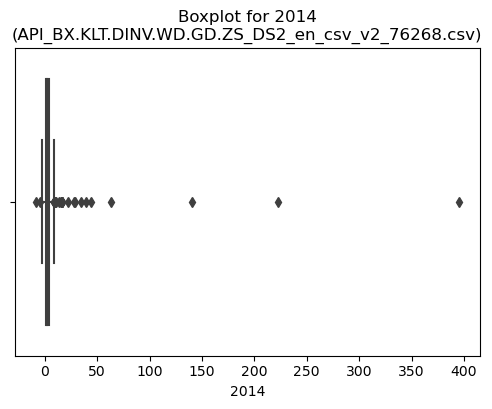


==== Univariate Analysis for file: ./data/API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv ====
Numeric columns available: ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
Chosen column for analysis: 2018

Summary Statistics:
count    147.000000
mean       7.396732
std        9.006356
min        0.217152
25%        2.237032
50%        3.686425
75%        9.603857
max       54.410017
Name: 2018, dtype: float64

Mean: 7.396732416345353
Median: 3.68642493378735
Variance: 81.11445106829257


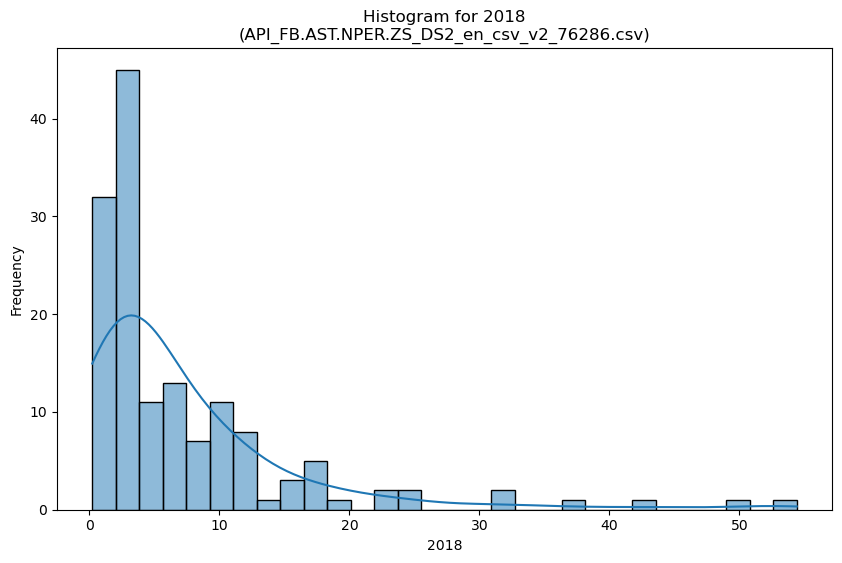


==== Univariate Analysis for file: ./data/API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv ====
Numeric columns available: ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
Chosen column for analysis: 2013

Summary Statistics:
count    229.000000
mean      50.876700
std       39.468547
min        0.003014
25%       21.328569
50%       41.079745
75%       66.987640
max      254.551659
Name: 2013, dtype: float64

Mean: 50.87670017805866
Median: 41.0797449988366
Variance: 1557.7661831721584


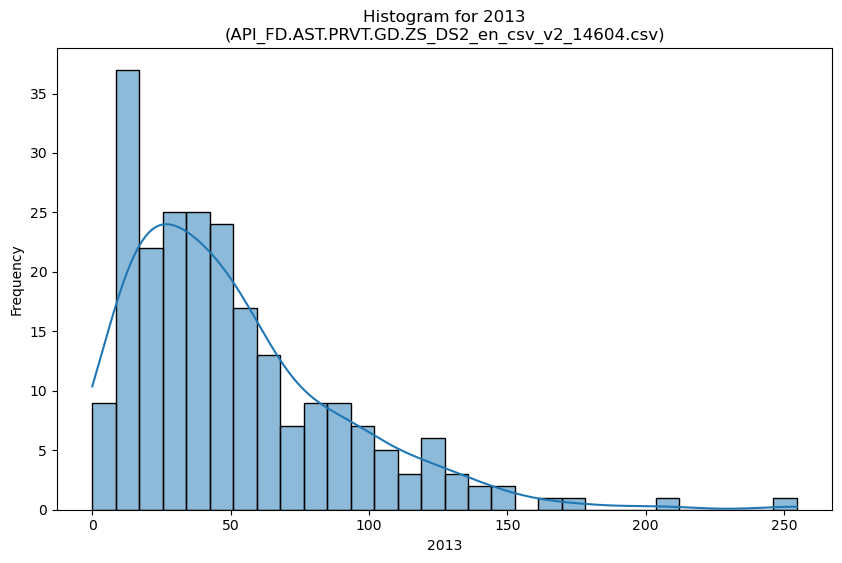

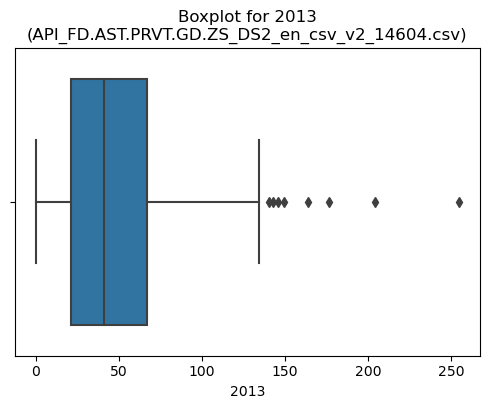


==== Univariate Analysis for file: ./data/API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv ====
Numeric columns available: ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
Chosen column for analysis: 2005

Summary Statistics:
count    205.000000
mean      52.636183
std       39.066277
min        4.530351
25%       24.283395
50%       44.516882
75%       69.111826
max      257.688534
Name: 2005, dtype: float64

Mean: 52.636183193941136
Median: 44.5168816295289
Variance: 1526.1739675784306


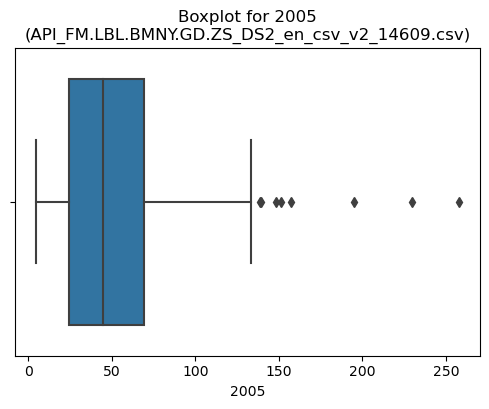


==== Univariate Analysis for file: ./data/API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv ====
Numeric columns available: ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
Chosen column for analysis: 2017

Summary Statistics:
count     53.000000
mean      80.434390
std       62.782078
min       13.931641
25%       41.731155
50%       63.610667
75%       92.534391
max      352.149391
Name: 2017, dtype: float64

Mean: 80.43439027686142
Median: 63.6106665234143
Variance: 3941.5893329497344


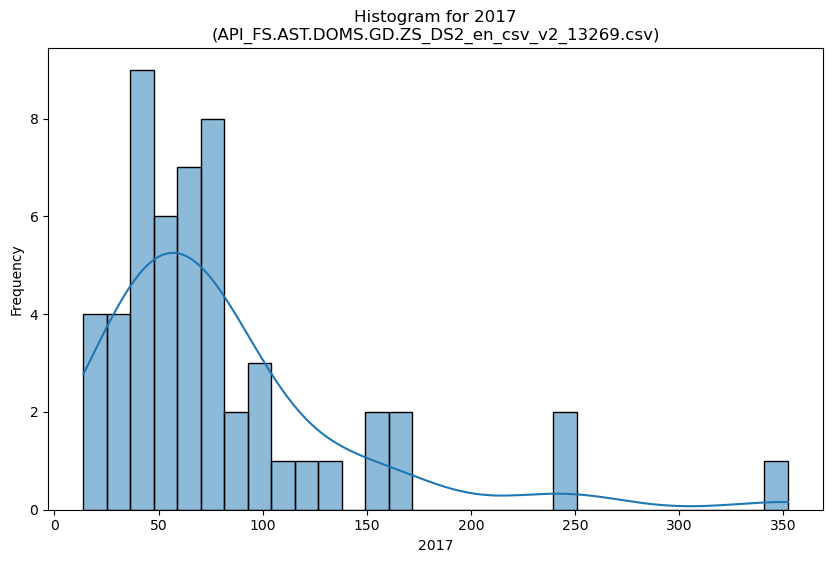

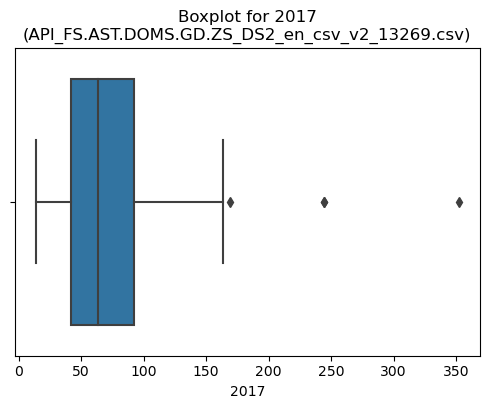


==== Univariate Analysis for file: ./data/API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv ====
Numeric columns available: ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
Chosen column for analysis: 2013

Summary Statistics:
count    223.000000
mean      55.567804
std       44.064635
min        0.003049
25%       22.123508
50%       42.770132
75%       74.572703
max      254.668065
Name: 2013, dtype: float64

Mean: 55.56780395104206
Median: 42.7701323168693
Variance: 1941.692042670021


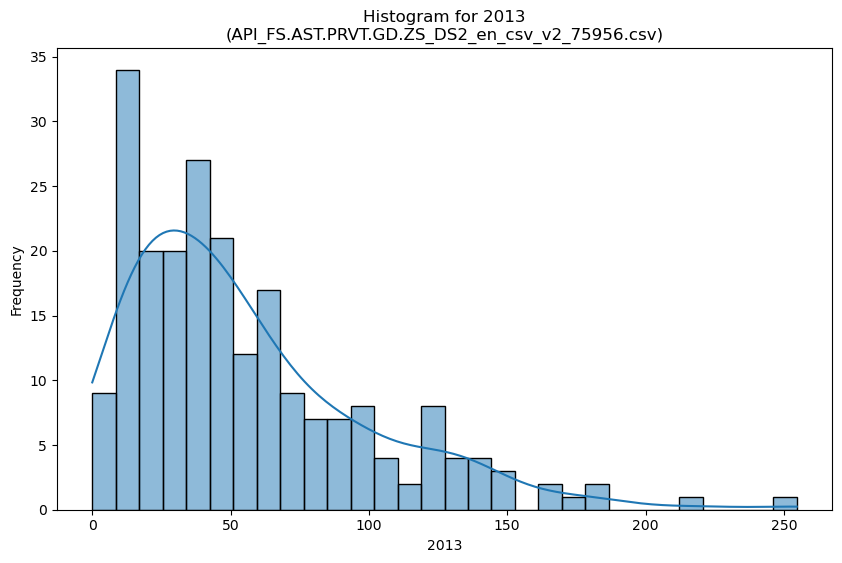

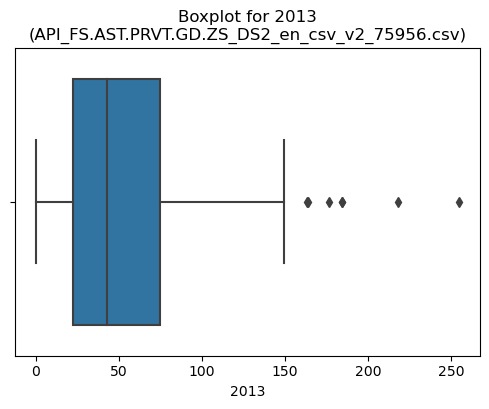

In [1288]:
# For each primary financial indicator file
for file, df in primary_data.items():
    print(f"\n==== Univariate Analysis for file: {file} ====")    

    # Identify numeric columns (indicator values)
    numeric_cols = df.select_dtypes(include='number').columns.tolist()

    # Remove potential extraneous columns (e.g., the empty 'Unnamed: 68')
    if "Unnamed: 68" in numeric_cols:
        numeric_cols.remove("Unnamed: 68")

    print("Numeric columns available:", numeric_cols)    

    # For this example, choose the numeric column with the most non-null values
    non_null_counts = {col: df[col].count() for col in numeric_cols}
    chosen_col = max(non_null_counts, key=non_null_counts.get)
    print(f"Chosen column for analysis: {chosen_col}")    

    # Generate summary statistics using .describe()
    stats = df[chosen_col].describe()
    mean_val = df[chosen_col].mean()
    median_val = df[chosen_col].median()
    var_val = df[chosen_col].var()
    
    print("\nSummary Statistics:")
    print(stats)
    print(f"\nMean: {mean_val}")
    print(f"Median: {median_val}")
    print(f"Variance: {var_val}")   

    # Plot a histogram (with KDE) for the chosen column
    plt.figure(figsize=(10, 6))
    sns.histplot(df[chosen_col].dropna(), kde=True, bins=30)
    plt.title(f"Histogram for {chosen_col}\n({file.split('/')[-1]})")
    plt.xlabel(chosen_col)
    plt.ylabel("Frequency")
    plt.show()  

    # Plot a boxplot for the chosen column
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[chosen_col].dropna())
    plt.title(f"Boxplot for {chosen_col}\n({file.split('/')[-1]})")
    plt.xlabel(chosen_col)
    plt.show()    

    print("="*80)

### Refined Univariate Analysis

In [1289]:
# Define a function to perform univariate analysis on a chosen numeric column
def univariate_analysis(df, col, title=""):
    # Print summary statistics
    print(f"Summary Statistics for {title} - Column: {col}")
    stats = df[col].describe()
    mean_val = df[col].mean()
    median_val = df[col].median()
    var_val = df[col].var()
    print(stats)
    print(f"Mean: {mean_val}")
    print(f"Median: {median_val}")
    print(f"Variance: {var_val}\n")   

    # Create a histogram with KDE
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col].dropna(), kde=True, color='skyblue')
    plt.title(f"Histogram of {title} - {col}")
    plt.xlabel(col) 

    # Create a boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col].dropna(), color='lightgreen')
    plt.title(f"Boxplot of {title} - {col}")
    plt.xlabel(col) 
    plt.tight_layout()
    plt.show()

==== Univariate Analysis for file: ./data/API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv ====
Summary Statistics for ./data/API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv - Column: 2014
count    240.000000
mean       7.445819
std       30.893137
min       -8.267207
25%        1.369289
50%        2.569562
75%        4.418992
max      394.898960
Name: 2014, dtype: float64
Mean: 7.445819478385338
Median: 2.5695618208868654
Variance: 954.3858854612528



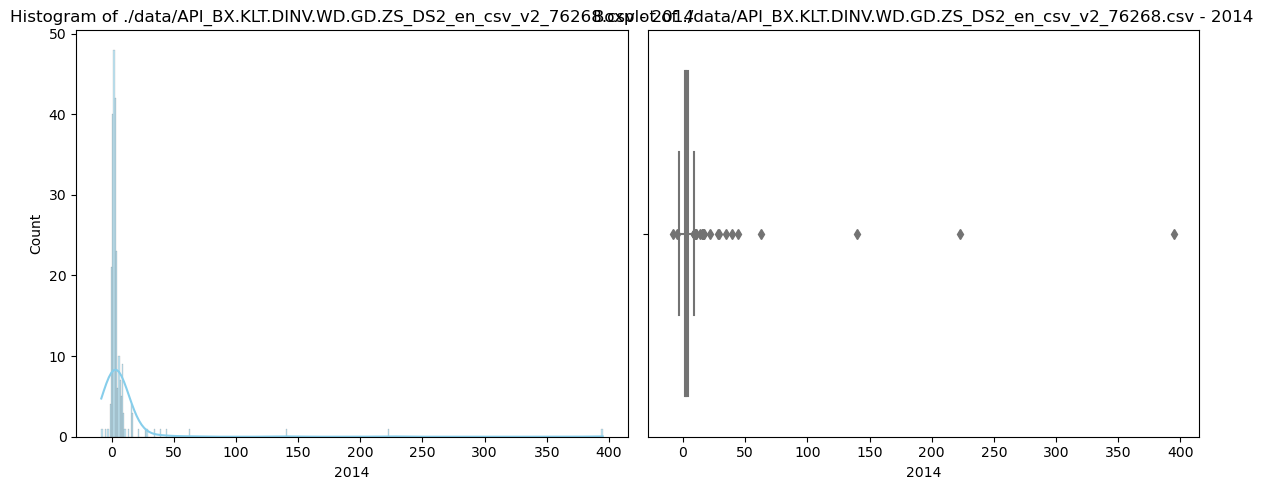

==== Univariate Analysis for file: ./data/API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv ====
Summary Statistics for ./data/API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv - Column: 2018
count    147.000000
mean       7.396732
std        9.006356
min        0.217152
25%        2.237032
50%        3.686425
75%        9.603857
max       54.410017
Name: 2018, dtype: float64
Mean: 7.396732416345353
Median: 3.68642493378735
Variance: 81.11445106829257



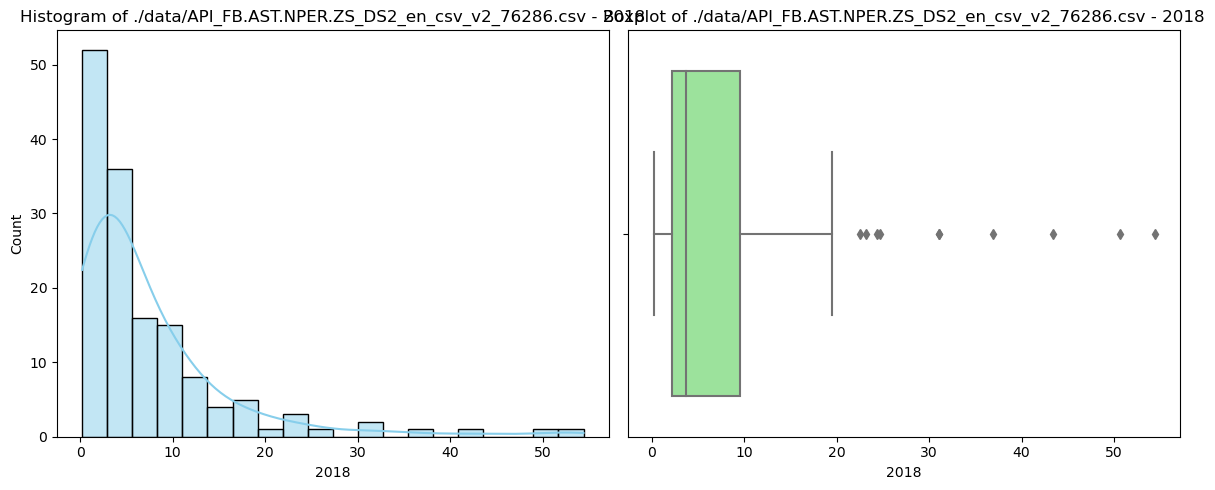

==== Univariate Analysis for file: ./data/API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv ====
Summary Statistics for ./data/API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv - Column: 2013
count    229.000000
mean      50.876700
std       39.468547
min        0.003014
25%       21.328569
50%       41.079745
75%       66.987640
max      254.551659
Name: 2013, dtype: float64
Mean: 50.87670017805866
Median: 41.0797449988366
Variance: 1557.7661831721584



==== Univariate Analysis for file: ./data/API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv ====
Summary Statistics for ./data/API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv - Column: 2005
count    205.000000
mean      52.636183
std       39.066277
min        4.530351
25%       24.283395
50%       44.516882
75%       69.111826
max      257.688534
Name: 2005, dtype: float64
Mean: 52.636183193941136
Median: 44.5168816295289
Variance: 1526.1739675784306



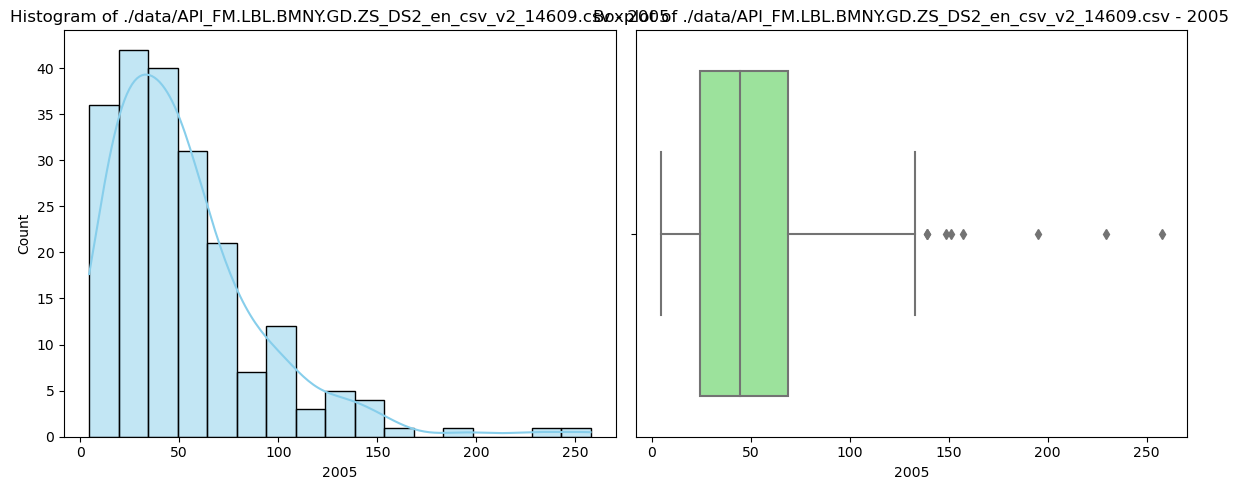

==== Univariate Analysis for file: ./data/API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv ====
Summary Statistics for ./data/API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv - Column: 2017
count     53.000000
mean      80.434390
std       62.782078
min       13.931641
25%       41.731155
50%       63.610667
75%       92.534391
max      352.149391
Name: 2017, dtype: float64
Mean: 80.43439027686142
Median: 63.6106665234143
Variance: 3941.5893329497344



==== Univariate Analysis for file: ./data/API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv ====
Summary Statistics for ./data/API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv - Column: 2013
count    223.000000
mean      55.567804
std       44.064635
min        0.003049
25%       22.123508
50%       42.770132
75%       74.572703
max      254.668065
Name: 2013, dtype: float64
Mean: 55.56780395104206
Median: 42.7701323168693
Variance: 1941.692042670021



In [1290]:
# Create a dictionary mapping each primary indicator file to the chosen year column

chosen_years = {
    "./data/API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv": "2014",
    "./data/API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv": "2018",
    "./data/API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv": "2013",
    "./data/API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv": "2005",
    "./data/API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv": "2017",
    "./data/API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv": "2013"
}

# Loop over the primary data files and perform univariate analysis
for file, df in primary_data.items():
    if file in chosen_years:
        col = chosen_years[file]
        print("=" * 80)
        print(f"==== Univariate Analysis for file: {file} ====")
        univariate_analysis(df, col, title=file)

#### Summary of results

 Univariate Analysis for file: ./data/API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv ====

Summary Statistics for ./data/API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv - Column: 2014

- count    240.000000
- mean       7.445819
- std       30.893137
- min       -8.267207
- 25%        1.369289
- 50%        2.569562
- 75%        4.418992
- max      394.898960

Name: 2014, dtype: float64
Mean: 7.445819478385338

Median: 2.5695618208868654
Variance: 954.3858854612528

===============================================================================Univariate Analysis for file: ./data/API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv ====

Summary Statistics for ./data/API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv - Column: 2018

- count    147.000000
- mean       7.396732
- std        9.006356
- min        0.217152
- 25%        2.237032
- 50%        3.686425
- 75%        9.603857
- max       54.410017

Name: 2018, dtype: float64
Mean: 7.396732416345353
Median: 3.68642493378735
Variance: 81.11445106829257

===============================================================================
==== Univariate Analysis for file: ./data/API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv ====

Summary Statistics for ./data/API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv - Column: 2013

- count    229.000000
- mean      50.876700
- std       39.468547
- min        0.003014
- 25%       21.328569
- 50%       41.079745
- 75%       66.987640
- max      254.551659

Name: 2013, dtype: float64
Mean: 50.87670017805866
Median: 41.0797449988366
Variance: 1557.7661831721584

===============================================================================Univariate Analysis for file: ./data/API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv ====

Summary Statistics for ./data/API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv - Column: 2005

- count    205.000000
- mean      52.636183
- std       39.066277
- min        4.530351
- 25%       24.283395
- 50%       44.516882
- 75%       69.111826
- max      257.688534

Name: 2005, dtype: float64
Mean: 52.636183193941136
Median: 44.5168816295289
Variance: 1526.1739675784306

===============================================================================Univariate Analysis for file: ./data/API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv ====

Summary Statistics for ./data/API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv - Column: 2017

- count     53.000000
- mean      80.434390
- std       62.782078
- min       13.931641
- 25%       41.731155
- 50%       63.610667
- 75%       92.534391
- max      352.149391

Name: 2017, dtype: float64
Mean: 80.43439027686142
Median: 63.6106665234143
Variance: 3941.5893329497344

===============================================================================Univariate Analysis for file: ./data/API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv ====

Summary Statistics for ./data/API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv - Column: 2013

- count    223.000000
- mean      55.567804
- std       44.064635
- min        0.003049
- 25%       22.123508
- 50%       42.770132
- 75%       74.572703
- max      254.668065

Name: 2013, dtype: float64
Mean: 55.56780395104206
Median: 42.7701323168693
Variance: 1941.692042670021

#### General Observations Across All Indicators

**Skewness:** 
Almost all distributions are right-skewed, meaning there are many countries with relatively modest values, but a small number of extremely high values.
The mean is consistently greater than the median in these samples, which is a classic sign of right skew.

**Outliers:**
All indicators exhibit notable outliers. For example, FDI net inflows can spike above 100% of GDP, or even approach 400% for certain edge cases.
Broad money, domestic credit, and private sector credit also have extreme upper values well above the typical range.

**Missing Values:**
In each file, certain years or columns have a large fraction of missing data. This is expected in cross-country time-series data, as not all countries report consistently.

**Variability:**
Standard deviations and variances are quite high relative to the mean, reinforcing that the data spread is wide and not centered around a single typical value.

In summary, the univariate analysis reveals that each financial indicator is heavily skewed with a handful of outliers, so future steps will likely involve transformations, outlier-handling strategies, and possibly grouping countries by region or income for more context. 

### Bivariate/Multivariate Analysis

Merged DataFrame Head:
                  Country Name Country Code  FDI_2013   NPL_2018  \
0                        Aruba          ABW  9.974455        NaN   
1  Africa Eastern and Southern          AFE  2.342134        NaN   
2                  Afghanistan          AFG  0.239801   8.886660   
3   Africa Western and Central          AFW  2.255601        NaN   
4                       Angola          AGO -5.380131  23.221737   

   PrivCreditBanks_2013  BroadMoney_2005  DomCredit_FS_2017  \
0             59.163673        57.446790                NaN   
1             38.386182        45.229569                NaN   
2              4.108256              NaN                NaN   
3             12.576012        13.594007                NaN   
4             21.341167        13.299819          29.796248   

   PrivCredit_FS_2013  
0           59.163673  
1           75.700968  
2            4.321685  
3           12.657947  
4                 NaN  
Correlation Matrix:
                      FDI

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


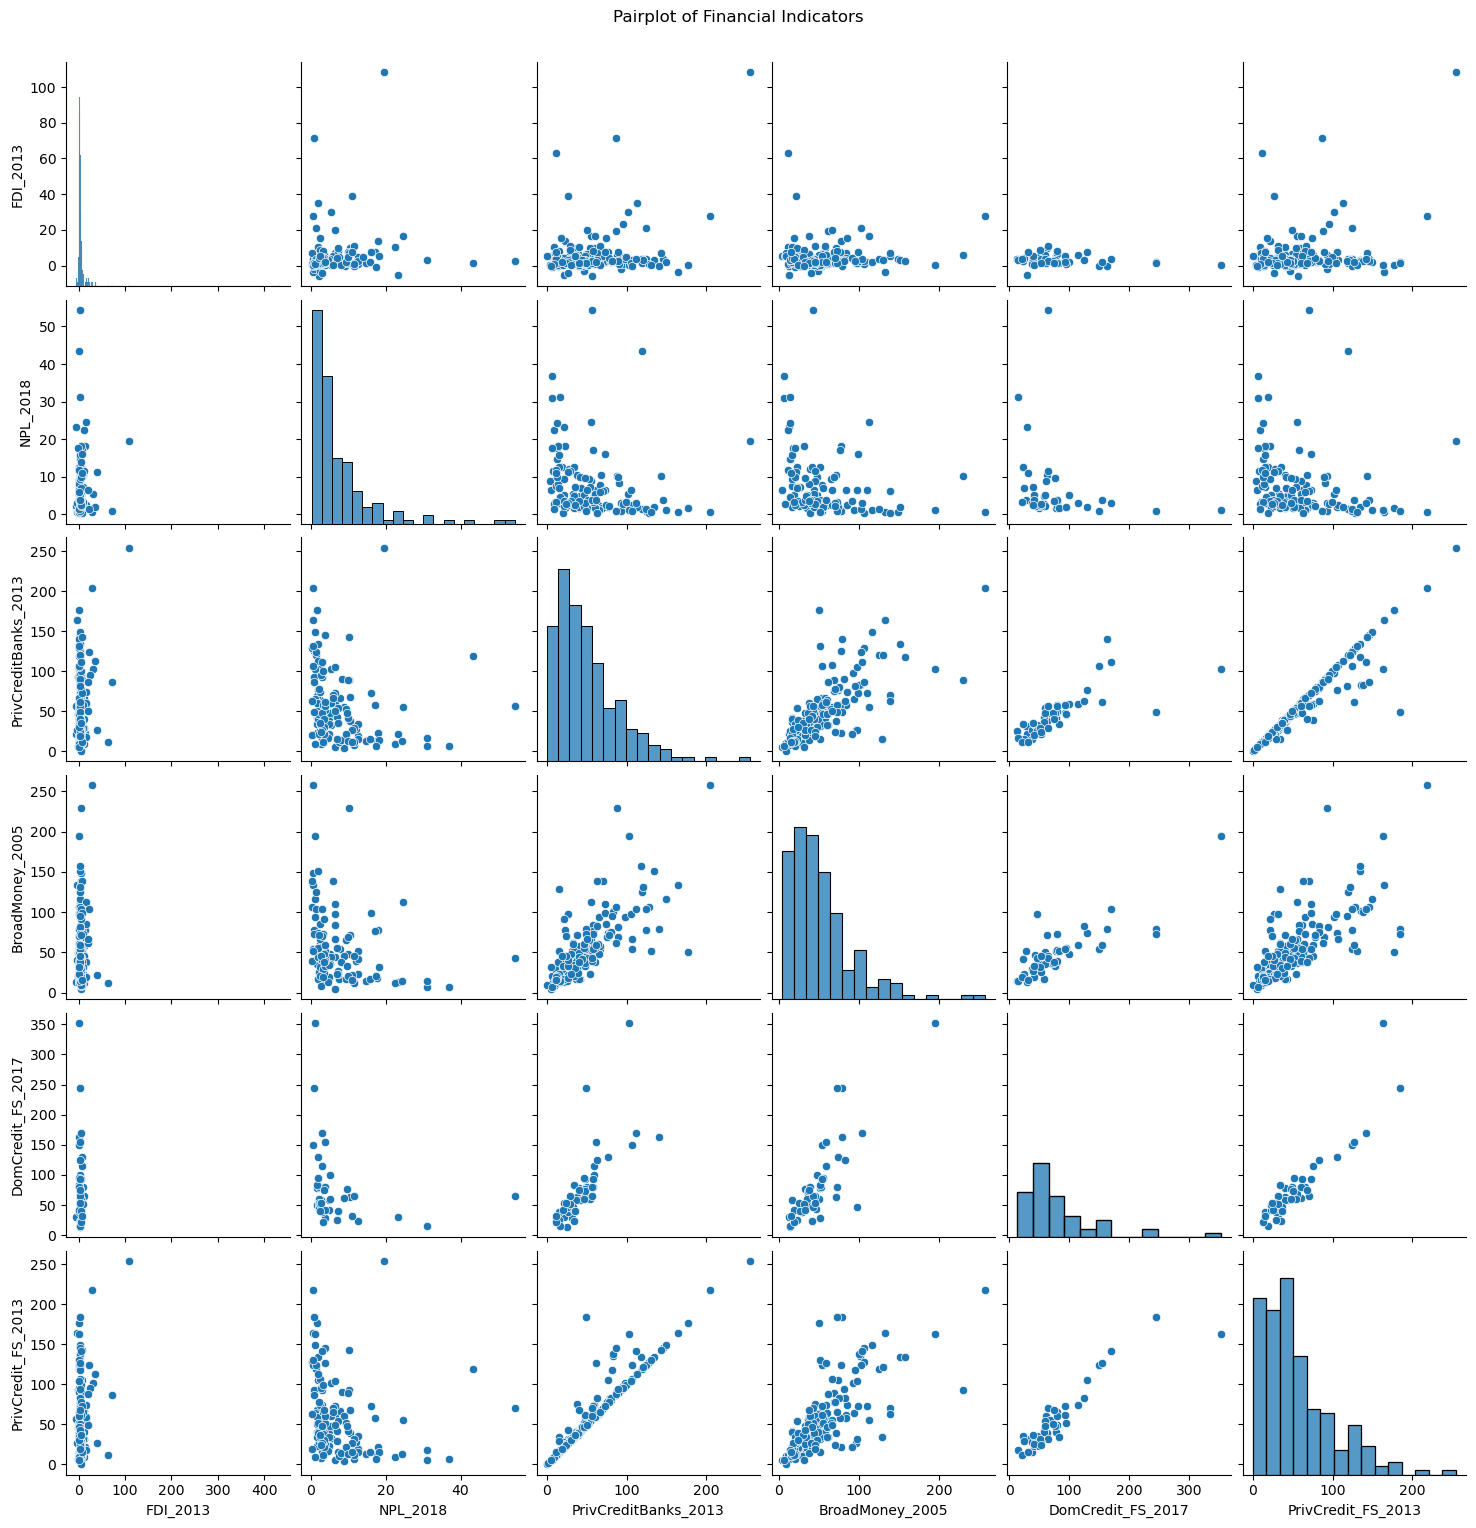

In [1291]:
# --- Step 1: Extract the chosen year from each primary indicator ---
# (Here we use different years per file as in your example.)

df_fdi = primary_data["./data/API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv"][["Country Name", "Country Code", "2013"]].rename(columns={"2013": "FDI_2013"})
df_npl = primary_data["./data/API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv"][["Country Name", "Country Code", "2018"]].rename(columns={"2018": "NPL_2018"})
df_priv_bank = primary_data["./data/API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv"][["Country Name", "Country Code", "2013"]].rename(columns={"2013": "PrivCreditBanks_2013"})
df_broadmoney = primary_data["./data/API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv"][["Country Name", "Country Code", "2005"]].rename(columns={"2005": "BroadMoney_2005"})
df_dom_credit = primary_data["./data/API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv"][["Country Name", "Country Code", "2017"]].rename(columns={"2017": "DomCredit_FS_2017"})
df_priv_credit = primary_data["./data/API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv"][["Country Name", "Country Code", "2013"]].rename(columns={"2013": "PrivCredit_FS_2013"})

# --- Step 2: Drop duplicate Country Name columns ---
# We will keep the "Country Name" from df_fdi and drop it from the others.
dfs = [df_fdi, df_npl, df_priv_bank, df_broadmoney, df_dom_credit, df_priv_credit]

for i in range(1, len(dfs)):
    if "Country Name" in dfs[i].columns:
        dfs[i] = dfs[i].drop(columns=["Country Name"])

# --- Step 3: Merge the datasets on 'Country Code' ---
df_merged = dfs[0]

for i in range(1, len(dfs)):
    df_merged = df_merged.merge(dfs[i], on="Country Code", how="inner")

# Optional: If you wish to inspect the merged DataFrame:
print("Merged DataFrame Head:")
print(df_merged.head())

# --- Step 4: Bivariate/Multivariate Analysis ---
indicator_cols = ["FDI_2013", "NPL_2018", "PrivCreditBanks_2013", "BroadMoney_2005", "DomCredit_FS_2017", "PrivCredit_FS_2013"]

# Compute and display the correlation matrix
corr_matrix = df_merged[indicator_cols].corr()
print("Correlation Matrix:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Financial Indicators")
plt.show()

# Create a pairplot to visualize pairwise relationships
sns.pairplot(df_merged[indicator_cols])
plt.suptitle("Pairplot of Financial Indicators", y=1.02)
plt.show()

### Correlation Analysis

#### Correlation Matrix

A correlation matrix across six key columns was computed:


**FDI_2013:** Foreign direct investment, net inflows (% of GDP) for 2013

**NPL_2018:** Bank nonperforming loans to total gross loans (%) for 2018

**PrivCreditBanks_2013:** Domestic credit to private sector by banks (% of GDP) for 2013

**BroadMoney_2005:** Broad money (% of GDP) for 2005

**DomCredit_FS_2017**: Domestic credit provided by financial sector (% of GDP) for 2017

**PrivCredit_FS_2013**: Domestic credit to private sector (% of GDP) for 2013

**Key Observations**

- High Inter-Correlation Among Credit Indicators
PrivCreditBanks_2013, DomCredit_FS_2017 and PrivCredit_FS_2013
all show strong positive correlations (above 0.70–0.90).

- BroadMoney_2005
BroadMoney_2005 also correlates positively with these credit-based measures (0.74–0.81 range), indicating that economies with higher money supply also tend to have higher levels of domestic/private credit.

- NPL_2018 Tends to Have Negative Correlation
Nonperforming loans (%) in 2018 shows a moderate negative correlation with the credit indicators (ranging from -0.17 to -0.26). This might suggest that economies with higher NPL ratios do not necessarily sustain high levels of private or domestic credit. However, the correlation is not extremely strong, so further investigation is needed.

- FDI_2013 Has Only Weak to Moderate Positive Correlations

FDI_2013’s correlations with the credit indicators are moderate (0.25–0.31) or near zero. This implies FDI inflows in 2013 may not strongly align with a country’s domestic credit or money supply levels.

**Potential Outliers:**
Some countries exhibit extremely high values in certain indicators (e.g., domestic credit well above 200% of GDP), which appear in the correlation matrix and can be seen in boxplots. These outliers may need special handling (e.g., capping, transformation, or separate analysis).

### Pairwise Scatter Plots

#### Distribution Shapes and Outliers

**From the pairplot (scatter plot matrix):**

- Many distributions (histograms along the diagonal) show right-skewed shapes.
Certain indicators (e.g., domestic/private credit) have large outliers far to the right.

- FDI also has some outliers in the higher ranges (hundreds of % of GDP for certain entries).

**Pairwise Relationships**
- The scatter plots for the three credit measures confirm the high clustering and strong positive slope.

- FDI vs. credit indicators show broad scatter, with no tight linear trend.

- NPL vs. credit measures show a slightly downward trend in the scatter plots, consistent with the negative correlations.

### Time Series Analysis

In [1292]:
# Define a function that extracts the time series for all years (i.e. numeric columns)
# for a set of sample countries and then plots them.
def plot_time_series_for_indicator(file_key, indicator_label, data_dict, countries):
    """
    Plots a time series line chart for the chosen financial indicator.
    
    Parameters:
      file_key (str): key (file path) for the indicator's DataFrame in data_dict.
      indicator_label (str): Label to use for the y-axis.
      data_dict (dict): Dictionary containing the loaded DataFrames.
      countries (list): List of country codes to include in the plot.
    """
    df = data_dict[file_key]
    
    # Identify year columns (assumed to be columns that consist only of digits)
    year_cols = [col for col in df.columns if col.isdigit()]
    if not year_cols:
        print(f"No year columns found in {file_key}.")
        return
    
    # Filter rows for the sample countries based on 'Country Code'
    df_sample = df[df["Country Code"].isin(countries)]
    
    # We assume that "Country Name" is present; set it as the index.
    # (If you prefer to use 'Country Code', adjust accordingly.)
    df_sample = df_sample[["Country Name"] + year_cols].set_index("Country Name")
    
    # Ensure the columns are sorted in chronological order.
    sorted_years = sorted(year_cols, key=int)
    df_sample = df_sample[sorted_years]
    
    # Convert column names to integers for plotting purposes.
    years = list(map(int, sorted_years))
    
    plt.figure(figsize=(10, 6))
    for country, row in df_sample.iterrows():
        plt.plot(years, row, marker='o', label=country)
    
    plt.xlabel("Year")
    plt.ylabel(indicator_label)
    plt.title(f"Time Series Analysis: {indicator_label}")
    plt.legend()
    plt.tight_layout()
    plt.show()

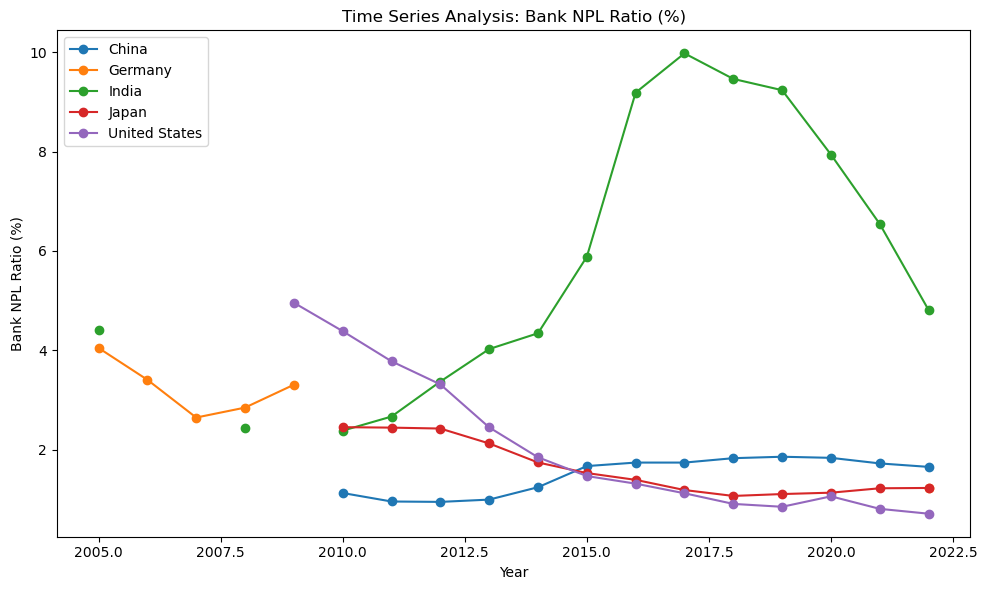

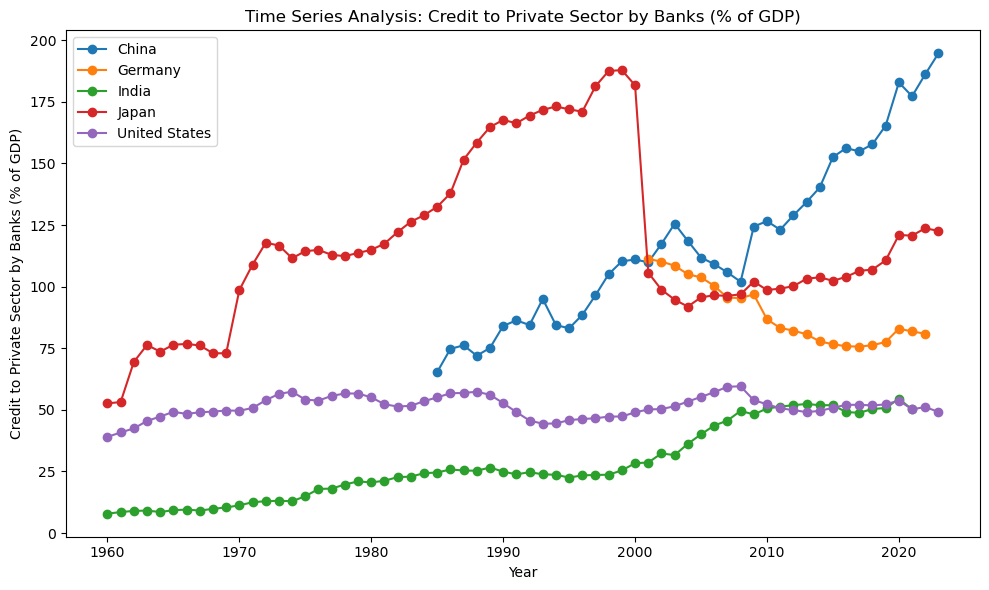

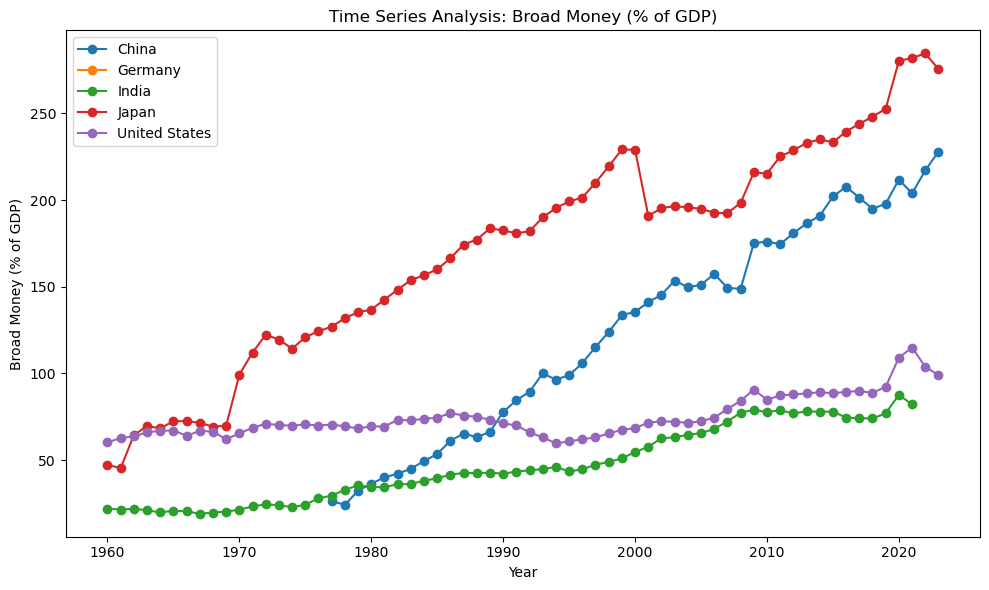

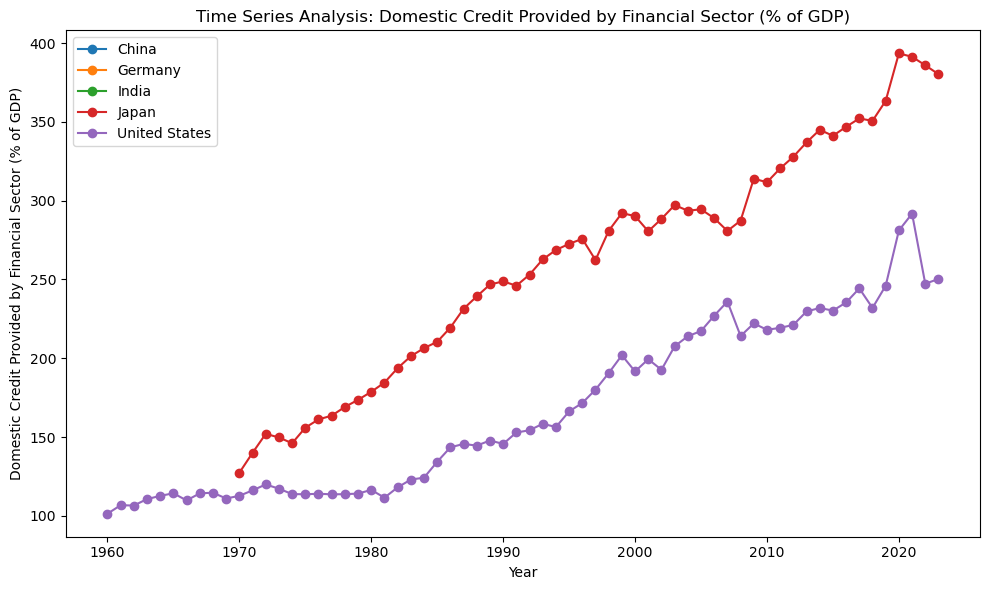

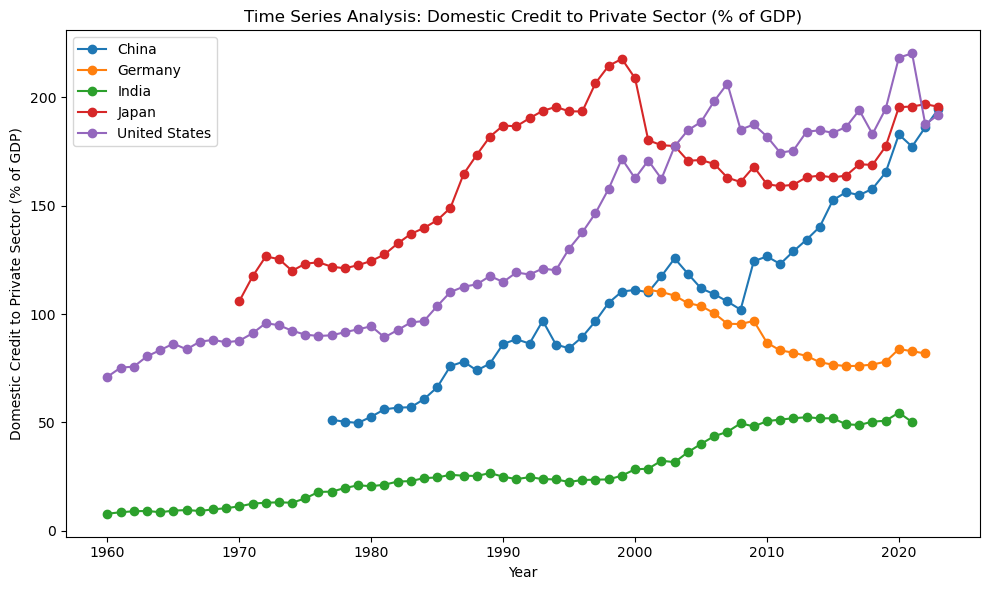

In [1293]:
# Define a sample list of countries by their "Country Code" (adjust as needed)
sample_countries = ["USA", "JPN", "IND", "CHN", "DEU"]

# Now, call the function for each primary indicator file.
# (Be sure that your 'primary_data' dictionary contains the DataFrames loaded previously.)

# 1. Foreign direct investment, net inflows (% of GDP)
plot_time_series_for_indicator(
    file_key="./data/API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv",
    indicator_label="FDI (% of GDP)",
    data_dict=primary_data,
    countries=sample_countries
)

# 2. Bank nonperforming loans to total gross loans (%)
plot_time_series_for_indicator(
    file_key="./data/API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv",
    indicator_label="Bank NPL Ratio (%)",
    data_dict=primary_data,
    countries=sample_countries
)

# 3. Domestic credit to private sector by banks (% of GDP)
plot_time_series_for_indicator(
    file_key="./data/API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv",
    indicator_label="Credit to Private Sector by Banks (% of GDP)",
    data_dict=primary_data,
    countries=sample_countries
)

# 4. Broad money (% of GDP)
plot_time_series_for_indicator(
    file_key="./data/API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv",
    indicator_label="Broad Money (% of GDP)",
    data_dict=primary_data,
    countries=sample_countries
)

# 5. Domestic credit provided by the financial sector (% of GDP)
plot_time_series_for_indicator(
    file_key="./data/API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv",
    indicator_label="Domestic Credit Provided by Financial Sector (% of GDP)",
    data_dict=primary_data,
    countries=sample_countries
)

# 6. Domestic credit to private sector (% of GDP) (from financial sector)
plot_time_series_for_indicator(
    file_key="./data/API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv",
    indicator_label="Domestic Credit to Private Sector (% of GDP)",
    data_dict=primary_data,
    countries=sample_countries
)

#### Key Observations

**Trends Over Time:**
Time-series plots for each financial indicator (e.g., FDI, nonperforming loans, private sector credit, broad money, domestic credit) reveal that values change significantly over the years. Some indicators display low and relatively stable levels for long periods, while others show periods of rapid increase or decline.

**Country Differences:**
When comparing a sample of countries, you can see that trends differ widely by country. For instance, certain economies experience sharp increases in FDI (% of GDP) and credit indicators in recent years, while others remain more volatile or exhibit flatter trends.

**Outliers and Structural Breaks:**
The visualizations highlight outliers and abrupt shifts in the data. These anomalies may indicate significant economic events or differences in reporting standards that warrant further investigation.

**Correlation Insights:**
Correlation analysis (via heatmaps and pairplots) between the indicators supports the visual findings, suggesting that some financial measures (e.g., domestic credit and private sector credit) are strongly interrelated, whereas others show weaker relationships.

### Stratified Analysis

=== After merging primary indicators ===
                  Country Name Country Code  FDI_2013   NPL_2018  \
0                        Aruba          ABW  9.974455        NaN   
1  Africa Eastern and Southern          AFE  2.342134        NaN   
2                  Afghanistan          AFG  0.239801   8.886660   
3   Africa Western and Central          AFW  2.255601        NaN   
4                       Angola          AGO -5.380131  23.221737   

   PrivCreditBanks_2013  BroadMoney_2005  DomCredit_FS_2017  \
0             59.163673        57.446790                NaN   
1             38.386182        45.229569                NaN   
2              4.108256              NaN                NaN   
3             12.576012        13.594007                NaN   
4             21.341167        13.299819          29.796248   

   PrivCredit_FS_2013  
0           59.163673  
1           75.700968  
2            4.321685  
3           12.657947  
4                 NaN  

=== Country meta columns =

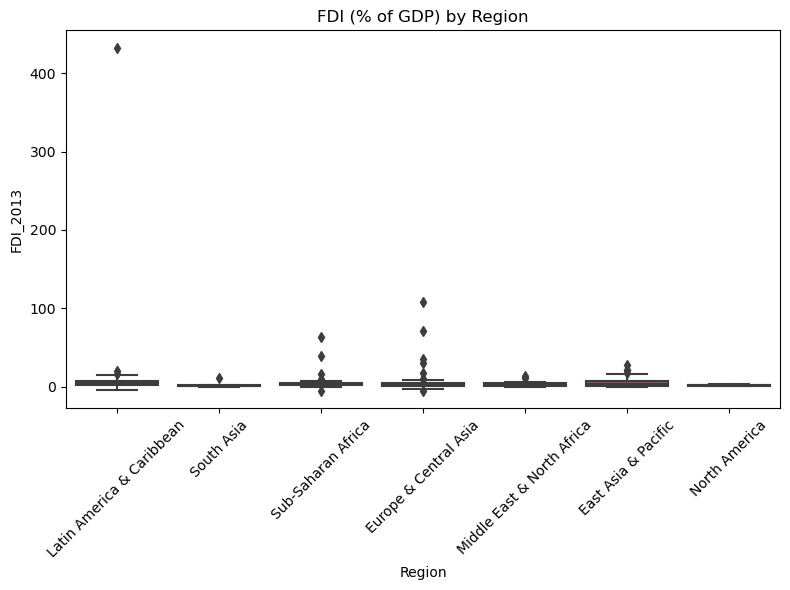

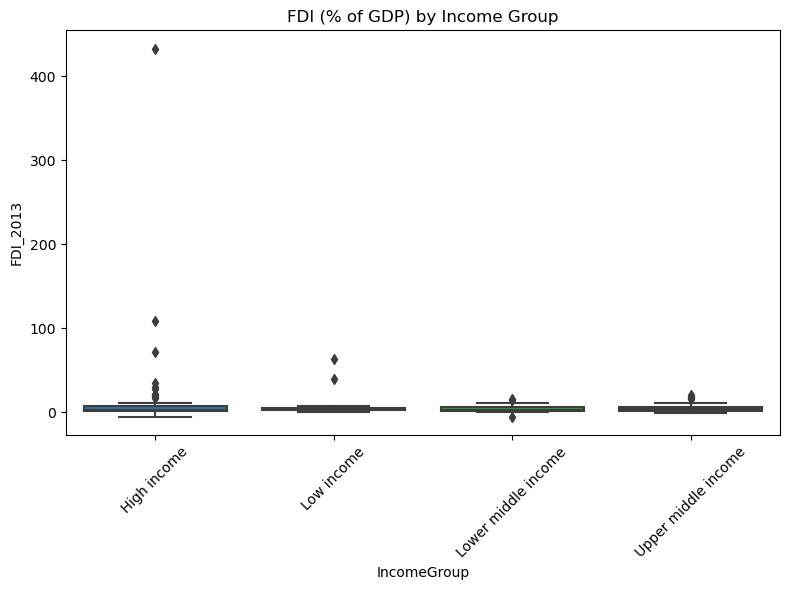

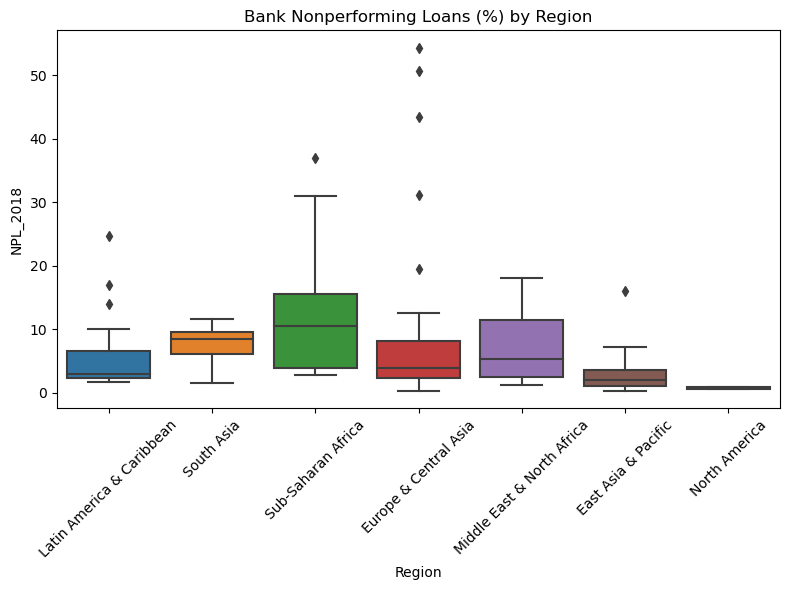

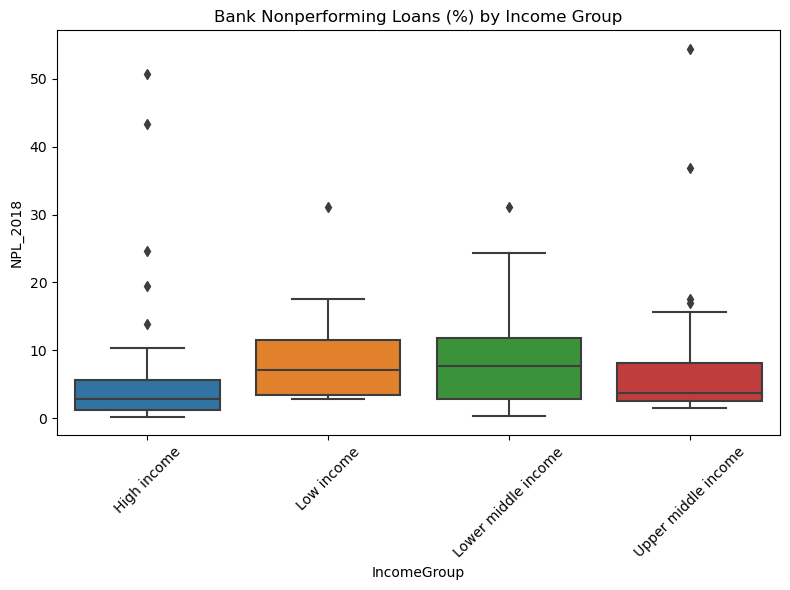

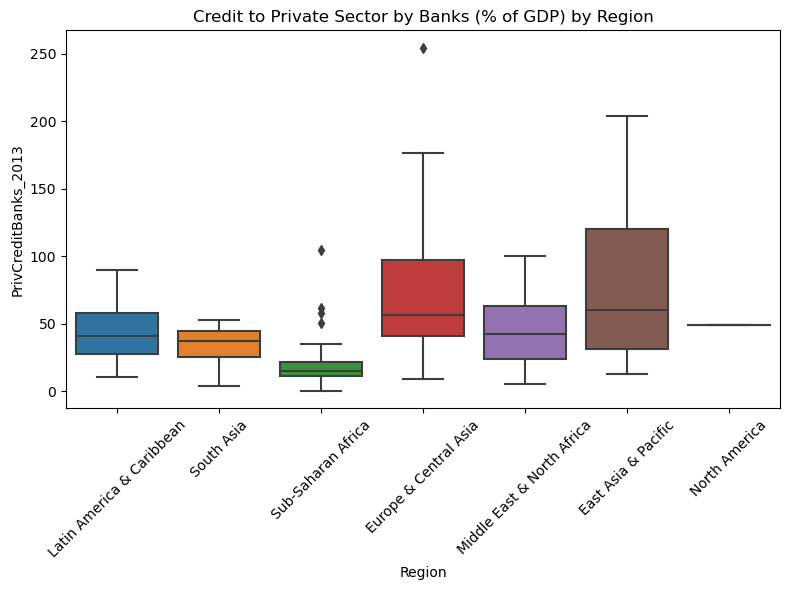

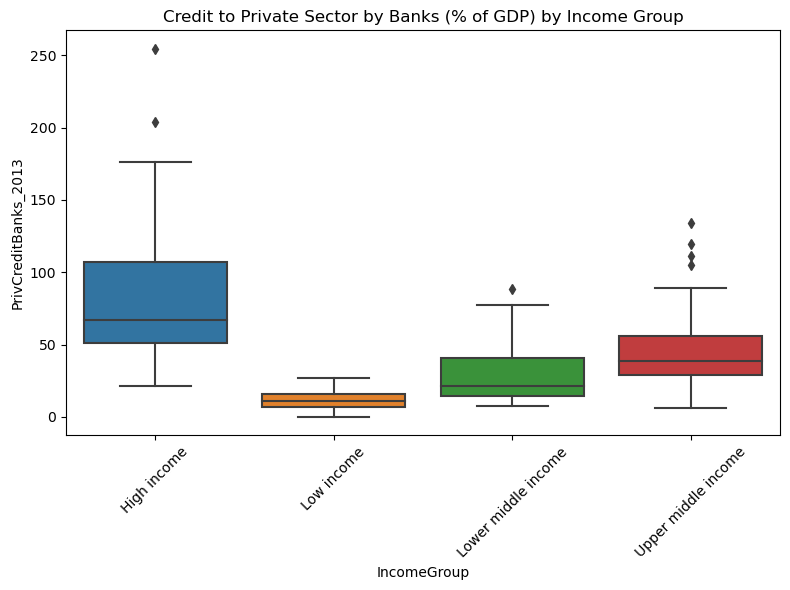

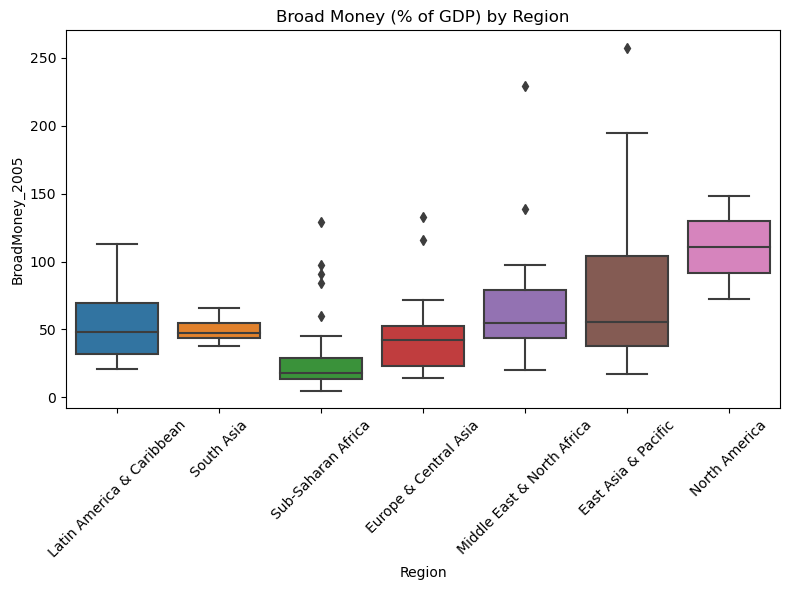

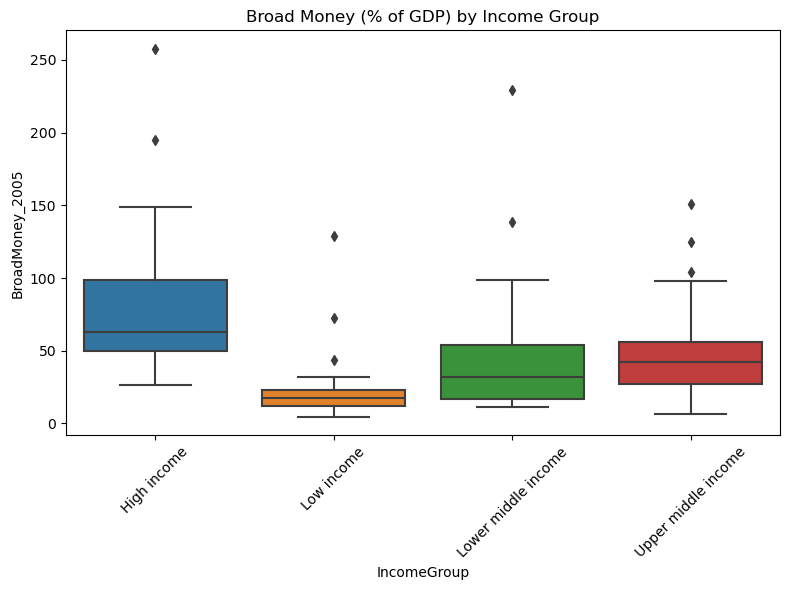

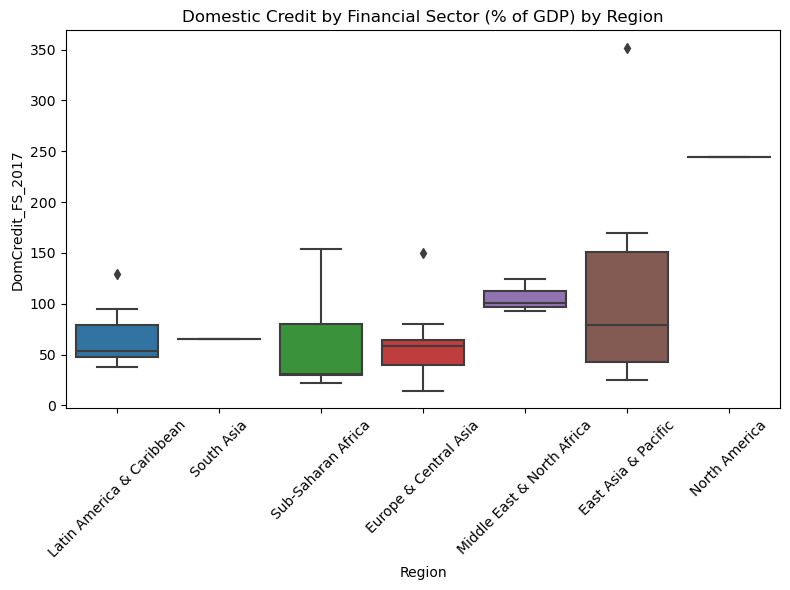

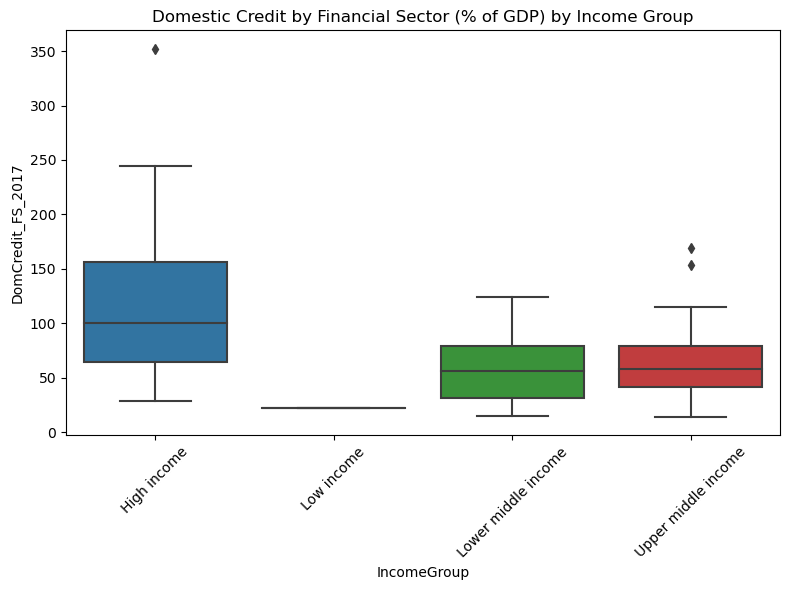

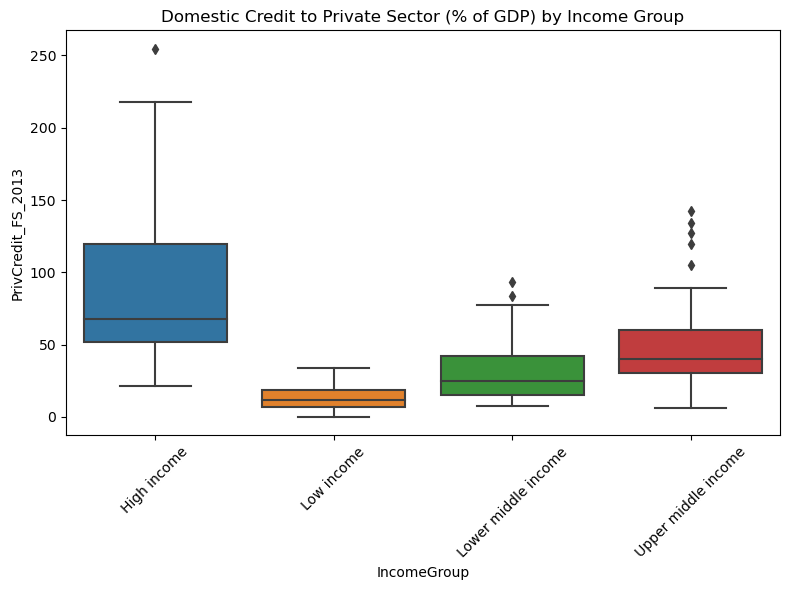

In [1294]:
# =============================================================================

# 1) LOAD PRIMARY INDICATOR DATA

# =============================================================================
# Extract and rename the chosen year column from each file:
df_fdi = (
    primary_data["./data/API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv"]
    [["Country Name", "Country Code", "2013"]]
    .rename(columns={"2013": "FDI_2013"})
)

# For subsequent DataFrames, drop "Country Name" to avoid duplicates:
df_npl = (
    primary_data["./data/API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv"]
    [["Country Name", "Country Code", "2018"]]
    .rename(columns={"2018": "NPL_2018"})
    .drop(columns=["Country Name"])
)

df_priv_bank = (
    primary_data["./data/API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv"]
    [["Country Name", "Country Code", "2013"]]
    .rename(columns={"2013": "PrivCreditBanks_2013"})
    .drop(columns=["Country Name"])
)

df_broadmoney = (
    primary_data["./data/API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv"]
    [["Country Name", "Country Code", "2005"]]
    .rename(columns={"2005": "BroadMoney_2005"})
    .drop(columns=["Country Name"])
)

df_dom_credit = (
    primary_data["./data/API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv"]
    [["Country Name", "Country Code", "2017"]]
    .rename(columns={"2017": "DomCredit_FS_2017"})
    .drop(columns=["Country Name"])
)

df_priv_credit = (
    primary_data["./data/API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv"]
    [["Country Name", "Country Code", "2013"]]
    .rename(columns={"2013": "PrivCredit_FS_2013"})
    .drop(columns=["Country Name"])
)

# =============================================================================
# 2) MERGE PRIMARY INDICATOR DATA
# =============================================================================
df_primary = (
    df_fdi
    .merge(df_npl,         on="Country Code", how="outer")
    .merge(df_priv_bank,   on="Country Code", how="outer")
    .merge(df_broadmoney,  on="Country Code", how="outer")
    .merge(df_dom_credit,  on="Country Code", how="outer")
    .merge(df_priv_credit, on="Country Code", how="outer")
)

print("=== After merging primary indicators ===")
print(df_primary.head())

# =============================================================================
# 3) LOAD COUNTRY-LEVEL META DATA (Region & IncomeGroup)
# =============================================================================
# Pick a metadata file that includes "Region" and "IncomeGroup"
country_meta_file = "./data/Metadata_Country_API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv"
df_country_meta = pd.read_csv(country_meta_file, encoding="latin1")

# Clean column names to remove hidden/BOM characters
df_country_meta.columns = (
    df_country_meta.columns
    .str.strip()
    .str.replace('"', '', regex=False)    # remove literal double-quotes if present
    .str.replace('ï»¿', '', regex=False)  # remove BOM-like sequences
)

print("\n=== Country meta columns ===")
print(df_country_meta.columns.tolist())
print("\n=== Sample of df_country_meta ===")
print(df_country_meta.head())

# Keep only the necessary columns
df_country_meta = df_country_meta[["Country Code", "Region", "IncomeGroup"]]

# =============================================================================
# 4) MERGE COUNTRY METADATA INTO PRIMARY DATA
# =============================================================================
df_merged = df_primary.merge(df_country_meta, on="Country Code", how="left")
print("\n=== Columns in df_merged ===")
print(df_merged.columns.tolist())

# =============================================================================
# 5) STRATIFIED ANALYSIS: Group-level Summary Statistics
# =============================================================================
indicator_cols = [
    "FDI_2013",
    "NPL_2018",
    "PrivCreditBanks_2013",
    "BroadMoney_2005",
    "DomCredit_FS_2017",
    "PrivCredit_FS_2013"
]

# (A) Compute means by Region
region_means = df_merged.groupby("Region")[indicator_cols].mean(numeric_only=True)
print("\nMean values by Region:\n", region_means, "\n")

# (B) Compute means by Income Group
income_means = df_merged.groupby("IncomeGroup")[indicator_cols].mean(numeric_only=True)
print("Mean values by Income Group:\n", income_means, "\n")

# ============================================================================
# 6) VISUALIZATION: Boxplots for All Indicators by Region & IncomeGroup
# =============================================================================

# Optionally, create a dict for descriptive labels
indicator_labels = {
    "FDI_2013": "FDI (% of GDP)",
    "NPL_2018": "Bank Nonperforming Loans (%)",
    "PrivCreditBanks_2013": "Credit to Private Sector by Banks (% of GDP)",
    "BroadMoney_2005": "Broad Money (% of GDP)",
    "DomCredit_FS_2017": "Domestic Credit by Financial Sector (% of GDP)",
    "PrivCredit_FS_2013": "Domestic Credit to Private Sector (% of GDP)"
}

# Loop over each indicator and produce two boxplots (Region & IncomeGroup)
for col in indicator_cols:
    label = indicator_labels.get(col, col)  # fallback to column name if not in dict

    # --- Boxplot by Region ---
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_merged, x="Region", y=col)
    plt.title(f"{label} by Region")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()    

    # --- Boxplot by Income Group ---
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_merged, x="IncomeGroup", y=col)
    plt.title(f"{label} by Income Group")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Stratified Analyis of Financial Indicators

After merging the primary financial indicators—FDI, bank nonperforming loans, credit to the private sector by banks, broad money, domestic credit by the financial sector, and domestic credit to the private sector—with country-level metadata (Region and Income Group), we computed group-level summary statistics to assess differences across regions and income groups. We then visualized these differences via boxplots for each indicator.



1. Grouping by Region

FDI (% of GDP):

The mean FDI value is notably higher in Latin America & Caribbean (about 17%) compared to East Asia & Pacific (around 6%). Sub-Saharan Africa also exhibits relatively high variation, with some outliers reaching above 40%. These patterns are visible in the boxplot of FDI by region, where outliers highlight the diversity of FDI inflows within and across regions.



Bank Nonperforming Loans (%):

Sub-Saharan Africa stands out with a higher mean NPL ratio (above 11%), whereas North America shows a much lower average (below 1%). The boxplot by region confirms that some African countries experience significantly elevated NPL ratios, potentially reflecting heightened credit risk.



Credit to Private Sector by Banks (% of GDP):

East Asia & Pacific and Europe & Central Asia both show higher average bank credit to the private sector (over 70%), whereas Sub-Saharan Africa remains comparatively low (around 20%). The boxplots also highlight a few outliers—e.g., certain high-performer countries in East Asia or Europe that exceed 100%.



Broad Money (% of GDP):

North America again ranks high (over 110%), while East Asia & Pacific also exhibits a wide range with some countries surpassing 150%. Regions such as South Asia and Sub-Saharan Africa display lower median values but still have occasional outliers that exceed the group norm.



Domestic Credit by the Financial Sector (% of GDP):

Although not every region has complete data, North America reports the highest mean (over 240%), with East Asia & Pacific also showing substantial variation. Some outliers in East Asia approach or exceed 300%, illustrating how certain financial systems in that region provide significant domestic credit.



Domestic Credit to Private Sector (% of GDP):

East Asia & Pacific and Europe & Central Asia tend to have higher averages, often above 70–80%, while Sub-Saharan Africa remains lower (around 21%). The boxplot by region reveals substantial dispersion, with a few countries in East Asia far exceeding 100%.



Overall, these regional comparisons suggest that economic structures, regulatory environments, and financial development levels vary considerably by geography, influencing how much credit is extended, how many loans become nonperforming, and how attractive FDI inflows can be.



2. Grouping by Income Group

High-Income vs. Low-Income Patterns:



FDI: High-income countries average about 13.7%, whereas low-income countries show around 8.6%.

Credit to Private Sector by Banks: High-income countries reach nearly 84%, but low-income countries sit around 12%.

Broad Money: High-income economies surpass 79% on average, while low-income economies remain around 25%.

Domestic Credit (Financial Sector & Private Sector): Again, high-income groups lead with significantly higher means, illustrating more developed financial systems.

Middle-Income Groups:



Lower Middle Income typically ranges between the low- and high-income extremes. For example, credit to private sector by banks is about 30%—well above the low-income figure yet still far below high-income countries.

Upper Middle Income is often closer to high-income levels (e.g., 45% for credit to private sector by banks), though still showing gaps in financial depth compared to the highest-income category.

Boxplots for each indicator by income group confirm these patterns: high-income countries consistently exhibit higher medians (and occasional outliers well above 100–200%), while low-income nations cluster at lower levels, sometimes with a few outliers that deviate from the group norm.



3. Concluding Observations

The stratified analysis reveals significant differences in financial indicators when segmented by both region and income group:



Regional Variation:

Geographic factors, historical development, and local economic policies can drive substantial differences in FDI inflows, bank lending practices, and the overall depth of financial intermediation.



Income-Level Disparities:

High-income economies generally have more advanced financial sectors—e.g., higher credit to the private sector and broad money relative to GDP—indicating deeper financial markets. Meanwhile, low-income countries face challenges like higher NPL ratios or lower domestic credit availability.



These findings underscore how macroeconomic context and development levels may influence financial performance and stability. Future investigations might focus on the specific drivers behind these differences—such as institutional quality, openness to trade, or regulatory frameworks—and how they impact the observed outliers. Ultimately, tailoring policies or investment strategies to align with regional and income-level nuances can help stakeholders navigate the varying financial landscapes worldwide.

### Key Observations and Issues

### 1. Main Insights

#### General Trends and Variability
Financial indicators like FDI (Foreign Direct Investment) and credit to the private sector vary widely between regions and income levels.

High-income countries generally have more developed financial systems, meaning they have higher credit-to-GDP ratios and a larger money supply.

In contrast, low-income countries usually have lower levels of these financial indicators.

#### Regional Differences
Latin America & Caribbean shows higher average FDI, but some East Asian and Pacific countries also receive significant FDI inflows.

Sub-Saharan Africa tends to have higher levels of nonperforming loans (NPLs) and lower domestic credit.

North America has fewer data points, but consistently shows strong financial indicators, such as broad money supply and private sector credit, suggesting a mature financial system.

#### Differences by Income Level
High-income countries generally attract more FDI, have more private sector credit, and hold a larger portion of GDP as broad money.

Low-income countries often have lower financial indicators, with a few exceptions where some countries attract higher FDI.

Middle-income countries (both lower and upper) fall somewhere in between—better than low-income but not as advanced as high-income countries in terms of financial development.

#### Changes Over Time
In some countries, there is a steady increase in credit or broad money over the years, while others show more fluctuation, especially in FDI.

Certain global events (like economic recessions) may appear as drops in FDI or spikes in NPL ratios.


#### 2. Data Challenges

#### Missing Data
Some country-year combinations lack data, especially from earlier years or specific indicators. This could lead to misleading averages if not properly managed.

Certain regions, like North America, have limited data points, making it hard to get a complete picture of the region.

#### Outliers
Some data points stand out, like FDI exceeding 400% for a few countries, or credit metrics going above 200-300%. These might indicate unique economic situations or errors that need checking.

#### Inconsistent Country Data
Some codes in the dataset represent groups of countries rather than single countries (e.g., "AFE" for Africa Eastern and Southern). We need to decide whether to include or exclude these when analyzing individual countries.

#### Special Metadata Considerations
Some countries use multiple exchange rates or report data based on different calendars (fiscal vs. calendar year), which could affect comparisons over time.

Sub-Saharan Africa, in particular, has notes about using different exchange rates, which might impact the accuracy of FDI and credit data.

#### 3. Next Steps
#### Data Cleaning and Preparation
Choose a method for handling missing data, like filling gaps, removing incomplete rows, or using averages.

Review outliers to see if they are valid economic data or just mistakes. Consider using techniques like winsorization to reduce the effect of extreme values.

#### Consistency and Coding
Check whether grouped country codes (like "AFE") should be treated separately or excluded.

Adjust for countries that use fiscal-year reporting by making sure the data aligns with other countries using calendar years.

#### Further Analysis
Look for patterns between indicators, like how credit to the private sector might relate to NPL ratios.

Explore time-based trends to see if any countries have sudden changes in FDI or NPLs that might need further investigation.

#### Improving Methods
Think about using weighted averages for global or regional comparisons, possibly using GDP or population size as weights.

## 3. Data Preparation

Based on the comprehensive Data Understanding (which includes exploring data sources, assessing data quality, and performing initial EDA), the following tasks to prepare the data for modeling and further analysis.

### 3.1 Data Cleaning

#### 3.1.1 Handling Missing Values

In this step, we will focus on assessing and addressing missing data in our analysis. We will work primarily with the merged dataset (`df_merged`), which combines the six primary financial indicator files and the country-level metadata file. These source files are:



- **Primary Indicator Files:**

  - `API_BX.KLT.DINV.WD.GD.ZS_DS2_en_csv_v2_76268.csv` (Foreign Direct Investment – FDI)

  - `API_FB.AST.NPER.ZS_DS2_en_csv_v2_76286.csv` (Bank Nonperforming Loans – NPL)

  - `API_FD.AST.PRVT.GD.ZS_DS2_en_csv_v2_14604.csv` (Credit to Private Sector by Banks)

  - `API_FM.LBL.BMNY.GD.ZS_DS2_en_csv_v2_14609.csv` (Broad Money)

  - `API_FS.AST.DOMS.GD.ZS_DS2_en_csv_v2_13269.csv` (Domestic Credit by the Financial Sector)

  - `API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv` (Domestic Credit to Private Sector)



- **Country Metadata File:**

  - `Metadata_Country_API_FS.AST.PRVT.GD.ZS_DS2_en_csv_v2_75956.csv` (which contains information on Region and IncomeGroup)



All the primary indicator data have been merged into a single DataFrame (`df_primary`), and then the country-level metadata were merged to form `df_merged`. This merged DataFrame is our main working dataset for data cleaning, exploration, and later modeling.





##### **Assess Missing Values in the Merged Dataset:**

In [1295]:
 # Check missing values for the merged data
 missing_summary = df_merged.isnull().sum()
 print("Missing values in df_merged:\n", missing_summary)

Missing values in df_merged:
 Country Name              0
Country Code              0
FDI_2013                 31
NPL_2018                119
PrivCreditBanks_2013     37
BroadMoney_2005          61
DomCredit_FS_2017       213
PrivCredit_FS_2013       43
Region                   49
IncomeGroup              50
dtype: int64


#### **Visualize Missingness:**

In [1296]:
 # Visualize missing data using a heatmap
 plt.figure(figsize=(10, 6))
 sns.heatmap(df_merged.isnull(), cbar=False, cmap="viridis")
 plt.title("Missing Data Heatmap for Merged Dataset")
 plt.show()

#### Review Overall Missingness

From the counts, we see the following missing values in a dataset of (likely) 266 rows:


- FDI_2013: 31 missing (˜ 12%)
- NPL_2018: 119 missing (˜ 45%)
- PrivCreditBanks_2013: 37 missing (˜ 14%)
- BroadMoney_2005: 61 missing (˜ 23%)
- DomCredit_FS_2017: 213 missing (˜ 80%)
- PrivCredit_FS_2013: 43 missing (˜ 16%)
- Region: 49 missing (˜ 18%)
- IncomeGroup: 50 missing (˜ 19%)

These percentages can help guide whether to drop or impute columns or rows. For instance, DomCredit_FS_2017 is missing data for around 80% of the rows, which is very high; 

#### Column-by-Column Considerations

A. DomCredit_FS_2017 (80% missing)
Because 4 out of 5 rows have no data for this indicator, any statistical analysis including this column would be severely limited.

B. NPL_2018 (45% missing)
Missingness is substantial but not as extreme as DomCredit_FS_2017. If bank nonperforming loans are key to the analysis, it is possible:

- Attempt imputation for moderate levels of missing data (e.g., median-based if the distribution is skewed).

- Restrict analyses involving NPL to the subset of countries with valid data, dropping those rows for NPL-related tasks on

C. BroadMoney_2005 (23% missing), FDI_2013 (12%), PrivCreditBanks_2013 (14%), PrivCredit_FS_2013 (16%)
These columns have missingness levels between 10% and 25%, which is still manageable.

Imputation or row-dropping can be considered on a case-by-case basis:

- If a relatively small fraction of your final analytical sample is acceptable to lose, row-wise deletion might be simpler.

- If preserving sample size is paramount, consider imputing numeric fields with robust statistics (e.g., median or possibly multiple imputation if you need more sophisticated methods).

D. Region (18% missing) and IncomeGroup (19% missing)
These are categorical. For 18–19% missing, it is possible to:
- Assign a placeholder category, e.g., "Unknown" or "Not Specified" to avoid losing data for those countries.

- If these categories are crucial for stratified analysis, dropping 18–19% of the dataset might be too large a sacrifice. A placeholder label is usually safer.





#### Missing Data Decision Handling

#### Review Each Indicator’s Importance


**Key Business Questions:**
1. Main financial indicators influencing economic performance?
2. Differences across regions and income groups?
3. Predict future economic outcomes from indicator trends?
4. Policy measures for financial development and stability?

**Implication:**  
- Keep or carefully impute indicators central to measuring or predicting economic performance (credit measures, FDI, NPL).  
- Less critical columns can be dropped if coverage is too sparse.

#### Decision on Dropping or Imputing High-Missingness Columns

- **DomCredit_FS_2017 (80% missing)**  
  - Too few observations to be meaningful.  
  - **Decision:** Drop, unless crucial to policy or modeling.
  
  
- **NPL_2018 (45% missing)**  
  - Highly relevant for financial stability (Q4). 
  - **Decision:** Keep and impute (if stability is a focus), or drop if 45% missingness is too large.

####  Decission on Handling Moderately Missing Numeric Indicators



- **FDI_2013, BroadMoney_2005, PrivCreditBanks_2013, PrivCredit_FS_2013** (~10–25% missing)  

  - Important for Q1–Q4.  

  - **Decision:** Impute with median or advanced methods; or drop rows with missing values if the sample remains acceptable.

#### Decission on Categorical Fields: Region & IncomeGroup (~18–19% missing)

- Central for Q2 (regional/income-group differences).  
- **Decision:** Assign `"Unknown"` to missing categories to avoid losing entire rows.

#### Drop DomCredit_FS_2017 if 80% missing

In [1297]:
threshold_missing = 0.80 * len(df_merged)  # 80% threshold

if df_merged['DomCredit_FS_2017'].isnull().sum() > threshold_missing:
    df_merged.drop(columns=['DomCredit_FS_2017'], inplace=True)
    print("Dropped 'DomCredit_FS_2017' due to excessive missingness.")
else:
    print("'DomCredit_FS_2017' retained; consider advanced imputation.")

Dropped 'DomCredit_FS_2017' due to excessive missingness.


#### Decide on NPL_2018

In [1298]:
npl_missing_ratio = df_merged['NPL_2018'].isnull().mean()
print(f"NPL_2018 missing ratio: {npl_missing_ratio:.2%}")

retain_npl = True  # or False, depending on your focus

if retain_npl:
    print("Retaining NPL_2018 for analysis. Will consider imputation or partial data usage.")
else:
    df_merged.drop(columns=['NPL_2018'], inplace=True)
    print("Dropped 'NPL_2018' due to high missingness and lesser relevance.")

NPL_2018 missing ratio: 44.74%
Retaining NPL_2018 for analysis. Will consider imputation or partial data usage.


#### Impute Moderately Missing Indicators

In [1299]:
indicators_to_impute = ['FDI_2013', 'BroadMoney_2005', 'PrivCreditBanks_2013', 'PrivCredit_FS_2013']

for col in indicators_to_impute:
    missing_ratio = df_merged[col].isnull().mean()

    if missing_ratio > 0:
        median_val = df_merged[col].median(skipna=True)
        df_merged[col].fillna(median_val, inplace=True)
        print(f"Imputed missing values in {col} with median = {median_val:.2f}. Missing ratio was {missing_ratio:.2%}")
    else:
        print(f"No missing values in {col}; no imputation needed.")

Imputed missing values in FDI_2013 with median = 2.88. Missing ratio was 11.65%
Imputed missing values in BroadMoney_2005 with median = 44.52. Missing ratio was 22.93%
Imputed missing values in PrivCreditBanks_2013 with median = 41.08. Missing ratio was 13.91%
Imputed missing values in PrivCredit_FS_2013 with median = 42.77. Missing ratio was 16.17%


#### Convert Missing Region/IncomeGroup to "Unknown"

In [1300]:
for cat_col in ['Region', 'IncomeGroup']:
    missing_ratio = df_merged[cat_col].isnull().mean()

    if missing_ratio > 0:
        df_merged[cat_col].fillna("Unknown", inplace=True)
        print(f"Assigned 'Unknown' to missing values in {cat_col} ({missing_ratio:.2%} missing).")
    else:
        print(f"No missing values in {cat_col}.")

Assigned 'Unknown' to missing values in Region (18.42% missing).
Assigned 'Unknown' to missing values in IncomeGroup (18.80% missing).


#### Missing Data Resolution Summary

After analyzing the missing values in our merged dataset, we implemented the following steps based on our key business questions (financial indicators, regional/income-group comparisons, policy insights, etc.):

#### 1. Dropped `DomCredit_FS_2017`

- **Reason**: Over 80% of its rows were missing (213 out of 266). This excessive missingness severely limited its usefulness for analysis or modeling.

- **Decision**: Remove the column to maintain a cleaner dataset rather than attempting to impute such a large gap.

#### 2. Retained `NPL_2018` (Nonperforming Loans Ratio)

- **Reason**: Although `NPL_2018` had a missing ratio of ~45%, it is crucial for understanding financial stability (one of our key questions).

- **Decision**: Keep it for policy/stability insights, with the possibility of either imputation or restricting some analyses to countries where this data is available.

#### 3. Imputed Moderately Missing Indicators

- **Indicators**: `FDI_2013`, `BroadMoney_2005`, `PrivCreditBanks_2013`, `PrivCredit_FS_2013`

- **Missing Ratios**: Ranged from ~10–25%.

- **Method**: Median imputation.

- **Rationale**:

  - These are central to measuring economic performance, cross-country financial development, and policy outcomes.

  - We chose median imputation to reduce the impact of extreme outliers.

- **Result**: Missing data in these columns is now filled with a robust central tendency measure.

#### 4. Assigned `"Unknown"` for Missing `Region` & `IncomeGroup`

- **Reason**: Both had missingness around 18–19%.

- **Decision**: Instead of dropping these rows, we set them to `"Unknown"` to preserve other indicator data for those observations. This ensures we don’t lose entire rows that might still have valuable numeric indicators for other analyses.


#### Alignment with Key Questions

- Indicators Influencing Economic Performance: We kept and imputed essential columns (FDI, credit measures) to avoid losing critical data.

- Differences Across Regions & Income Groups: We preserved rows with missing categorical data by labeling them "Unknown", maintaining maximum coverage for comparisons.

- Predictive Analysis: Retaining as many relevant indicators as possible (with median imputation) supports future modeling.

- Policy Measures for Stability: We specifically kept NPL_2018 to examine financial-stability issues, despite high missingness.

### 3.1.2 Handling Duplicate Records

Duplicate entries can occur after merging multiple datasets, especially if the same `Country Code` appears more than once with identical or near-identical rows.

In [1301]:
duplicate_count = df_merged.duplicated(subset="Country Code", keep=False).sum()
print(f"Number of potential duplicate rows: {duplicate_count}")

# Optionally display the duplicated rows for inspection
if duplicate_count > 0:
    duplicates_df = df_merged[df_merged.duplicated(subset="Country Code", keep=False)]
    display(duplicates_df)

Number of potential duplicate rows: 0


The result indicates that there are no duplicate records in our merged dataset.

### 3.1.3 Data Type consistency

#### 3.1.3.1 Ensure that all numeric indicators are stored as numeric types

To ensure that our financial indicators are suitable for analysis, we need to verify that all numeric indicator columns are stored as numeric data types (e.g., `float64`). This is important for accurate calculations, statistical analysis, and visualizations.

In [1302]:
# --- Step 1: Review Data Types Before Conversion ---
print("Data types before conversion:")
print(df_merged.dtypes)

# --- Step 2: Convert Financial Indicator Columns to Numeric ---
# List of columns that should be numeric
numeric_cols = [
    "FDI_2013", "NPL_2018", "PrivCreditBanks_2013",
    "BroadMoney_2005", "PrivCredit_FS_2013"
]

# Convert each column to numeric (if not already), coercing errors to NaN
for col in numeric_cols:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')

# --- Step 3: Verify Data Types After Conversion ---
print("\nData types after conversion:")
print(df_merged.dtypes)

Data types before conversion:
Country Name             object
Country Code             object
FDI_2013                float64
NPL_2018                float64
PrivCreditBanks_2013    float64
BroadMoney_2005         float64
PrivCredit_FS_2013      float64
Region                   object
IncomeGroup              object
dtype: object

Data types after conversion:
Country Name             object
Country Code             object
FDI_2013                float64
NPL_2018                float64
PrivCreditBanks_2013    float64
BroadMoney_2005         float64
PrivCredit_FS_2013      float64
Region                   object
IncomeGroup              object
dtype: object


#### Results


**Before Conversion:**  
- `FDI_2013`, `NPL_2018`, `PrivCreditBanks_2013`, `BroadMoney_2005`, and `PrivCredit_FS_2013` were already of type `float64`.

**After Conversion:**  
- The data types remained unchanged (`float64`), confirming that all our numerical indicators are properly formatted for further analysis.

**Conclusion:**  
- With our numeric indicators confirmed as `float64`, we can now proceed with robust quantitative analyses and visualizations, confident that our calculations will not be affected by data type inconsistencies.

#### 3.1.2.2 Verify that categorical fields are correctly formatted as categorical or string types.

We verified that the categorical fields in our merged dataset are correctly formatted as string (object) types. The key categorical fields are:
- **Country Name**
- **Country Code**
- **Region**
- **IncomeGroup**

In [1303]:
print(df_merged[['Country Name', 'Country Code', 'Region', 'IncomeGroup']].dtypes)

Country Name    object
Country Code    object
Region          object
IncomeGroup     object
dtype: object


This output confirms that all our categorical fields are correctly stored as objects. This ensures that our stratified analyses—such as grouping by Region or IncomeGroup—will work as expected.

**Note:**
If desired for memory efficiency or faster processing during categorical operations, these columns can be converted to the category dtype. For our current analysis, however, the object type is sufficient.

**Conclusion:**
The categorical fields are properly formatted as strings, ensuring that our analyses involving group-level summary statistics and visualizations by region and income group can proceed without data type issues.

#### 3.1.2.3 Verify and Standardize country codes

Ensuring that the country codes are consistent across our dataset is critical because they serve as the unique identifier for merging and subsequent analyses. Inconsistent formatting (e.g., mixed case, extra whitespace) can lead to issues when joining datasets or grouping by country.

In [1304]:
# Standardize 'Country Code' in the merged DataFrame
df_merged["Country Code"] = df_merged["Country Code"].str.upper().str.strip()


# Verify the standardized country codes
print("Unique Country Codes:")
print(df_merged["Country Code"].unique())

Unique Country Codes:
['ABW' 'AFE' 'AFG' 'AFW' 'AGO' 'ALB' 'AND' 'ARB' 'ARE' 'ARG' 'ARM' 'ASM'
 'ATG' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN' 'BFA' 'BGD' 'BGR' 'BHR' 'BHS'
 'BIH' 'BLR' 'BLZ' 'BMU' 'BOL' 'BRA' 'BRB' 'BRN' 'BTN' 'BWA' 'CAF' 'CAN'
 'CEB' 'CHE' 'CHI' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG' 'COL' 'COM' 'CPV'
 'CRI' 'CSS' 'CUB' 'CUW' 'CYM' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA' 'DNK' 'DOM'
 'DZA' 'EAP' 'EAR' 'EAS' 'ECA' 'ECS' 'ECU' 'EGY' 'EMU' 'ERI' 'ESP' 'EST'
 'ETH' 'EUU' 'FCS' 'FIN' 'FJI' 'FRA' 'FRO' 'FSM' 'GAB' 'GBR' 'GEO' 'GHA'
 'GIB' 'GIN' 'GMB' 'GNB' 'GNQ' 'GRC' 'GRD' 'GRL' 'GTM' 'GUM' 'GUY' 'HIC'
 'HKG' 'HND' 'HPC' 'HRV' 'HTI' 'HUN' 'IBD' 'IBT' 'IDA' 'IDB' 'IDN' 'IDX'
 'IMN' 'IND' 'INX' 'IRL' 'IRN' 'IRQ' 'ISL' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN'
 'KAZ' 'KEN' 'KGZ' 'KHM' 'KIR' 'KNA' 'KOR' 'KWT' 'LAC' 'LAO' 'LBN' 'LBR'
 'LBY' 'LCA' 'LCN' 'LDC' 'LIC' 'LIE' 'LKA' 'LMC' 'LMY' 'LSO' 'LTE' 'LTU'
 'LUX' 'LVA' 'MAC' 'MAF' 'MAR' 'MCO' 'MDA' 'MDG' 'MDV' 'MEA' 'MEX' 'MHL'
 'MIC' 'MKD' 'MLI' 'MLT' 'MMR

In [1305]:
### 3.3 Summury of Handling Missing Data

After a thorough assessment of missing values in our merged dataset, we reached the following conclusions and made key decisions aligned with our business questions:

## Observations
- **Overall Missingness:**

  - **FDI_2013:** 31 missing values (~11.65% of rows)

  - **NPL_2018:** 119 missing values (~44.74% of rows)

  - **PrivCreditBanks_2013:** 37 missing values (~13.91%)

  - **BroadMoney_2005:** 61 missing values (~22.93%)

  - **DomCredit_FS_2017:** 213 missing values (over 80% missing)

  - **PrivCredit_FS_2013:** 43 missing values (~16.17%)

  - **Region:** 49 missing values (~18.42%)

  - **IncomeGroup:** 50 missing values (~18.80%)

- **Indicator Criticality:**

  - Indicators such as FDI, credit measures, and broad money are central to our key business questions on economic performance, cross-country comparisons, and predictive modeling.

  - Categorical fields (Region and IncomeGroup) are essential for stratifying the analysis and deriving policy insights.

    #### Decisions and Actions
1. **Drop Extremely Incomplete Columns:**

   - **DomCredit_FS_2017:**  
     - *Observation:* Over 80% of rows are missing.  
     - *Decision:* Drop this column entirely to avoid noise in our analyses.

2. **Retain and Handle Moderately Missing Numeric Indicators:**
   - **NPL_2018:**  
     - *Observation:* Approximately 45% missingness.  
     - *Decision:* Retain this indicator because it is key for understanding financial stability. We will explore imputation techniques (such as median imputation) or restrict analyses to countries with available data.
   - **FDI_2013, BroadMoney_2005, PrivCreditBanks_2013, PrivCredit_FS_2013:**  
     - *Observation:* Missingness ranges from ~10% to ~25%.  
     - *Decision:* Impute missing values using the median. Median imputation is chosen to reduce the influence of extreme outliers while preserving the overall distribution.

3. **Handle Missing Categorical Values:**
   - **Region & IncomeGroup:**  
     - *Observation:* Both fields have missingness around 18–19%.  
     - *Decision:* Instead of dropping rows (which would reduce overall coverage), assign a placeholder value such as `"Unknown"`. This preserves the observations for which the numeric data are otherwise available, ensuring robust group comparisons.

#### Final Decision Flow Summary
- **Drop:**  
  - `DomCredit_FS_2017` is dropped due to its excessive missingness (>80%).

- **Retain (with Imputation):**  
  - `NPL_2018`: Retained for its importance in assessing financial stability. Further analysis may involve imputation or subsetting.
  - `FDI_2013`, `BroadMoney_2005`, `PrivCreditBanks_2013`, and `PrivCredit_FS_2013`: Impute missing values with the median (robust to outliers).

- **Categorical Fields:**  
  - For `Region` and `IncomeGroup`, assign `"Unknown"` to missing entries rather than dropping rows. This ensures maximal data retention for cross-group analyses.

This process ensures our dataset is now cleaner and more consistent, allowing for robust quantitative analyses and accurate comparisons across regions and income groups.



### 3.2 Outlier Detection and Treatment

This section outlines the approach to identifying and handling outliers in our financial indicators. The goal is to ensure that extreme values do not distort our analyses, while preserving genuine economic signals that might be important for policy insights and predictive modeling.

#### 3.2.1 Identify Outliers


--- Analysis for FDI_2013 ---
IQR method: 32 outliers detected
Lower bound: -2.72, Upper bound: 8.92
Z-score method: 2 outliers detected


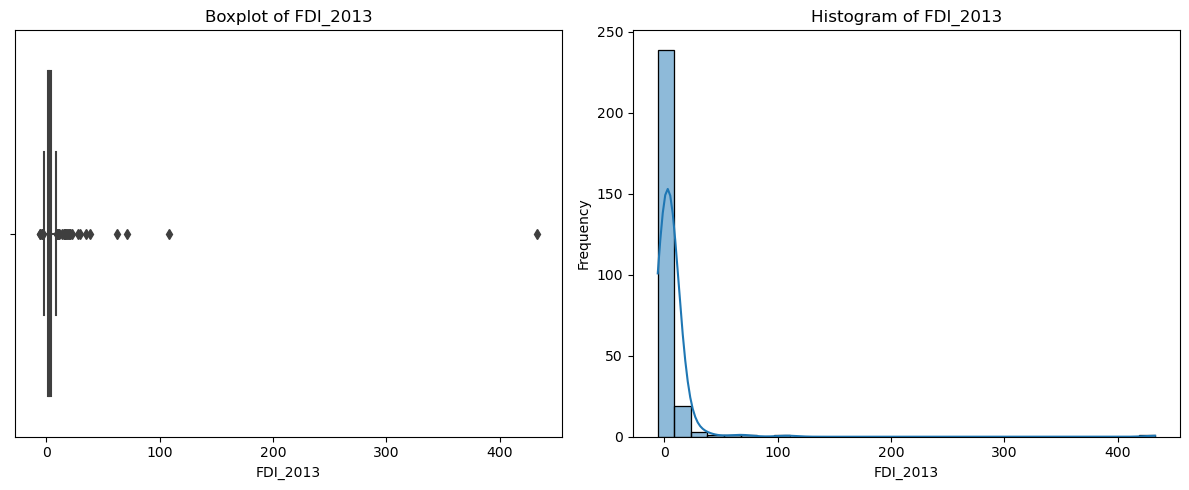


--- Analysis for NPL_2018 ---
IQR method: 10 outliers detected
Lower bound: -8.81, Upper bound: 20.65
Z-score method: 4 outliers detected


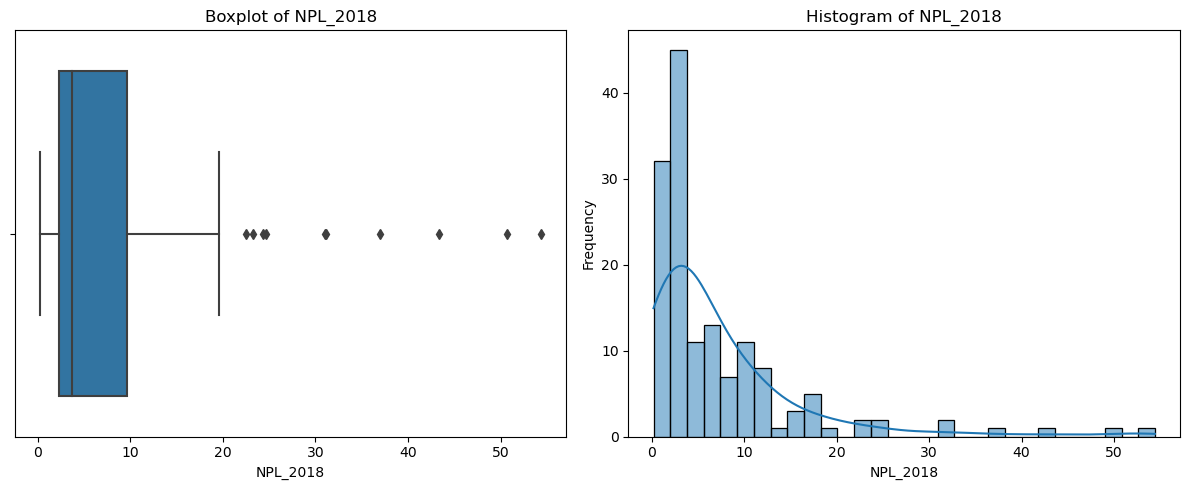


--- Analysis for PrivCreditBanks_2013 ---
IQR method: 18 outliers detected
Lower bound: -30.21, Upper bound: 115.80
Z-score method: 4 outliers detected



--- Analysis for BroadMoney_2005 ---
IQR method: 26 outliers detected
Lower bound: -8.59, Upper bound: 96.46
Z-score method: 4 outliers detected



--- Analysis for PrivCredit_FS_2013 ---
IQR method: 19 outliers detected
Lower bound: -32.54, Upper bound: 125.39
Z-score method: 5 outliers detected


In [1306]:
# List of the indicator columns to analyze (adjust as needed)

indicator_cols = [
    "FDI_2013",
    "NPL_2018",
    "PrivCreditBanks_2013",
    "BroadMoney_2005",
    "PrivCredit_FS_2013"
]

# Loop over each indicator column to detect outliers and visualize
for col in indicator_cols:

    print(f"\n--- Analysis for {col} ---") 
    # --------------------------
    # IQR Method
    # --------------------------
    Q1 = df_merged[col].quantile(0.25)
    Q3 = df_merged[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR  

    # Identify outliers using the IQR method
    outliers_iqr = df_merged[(df_merged[col] < lower_bound) | (df_merged[col] > upper_bound)]
    num_outliers_iqr = outliers_iqr.shape[0]
    print(f"IQR method: {num_outliers_iqr} outliers detected")
    print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

    # --------------------------
    # Z-score Method
    # --------------------------

    # Compute z-scores on non-null values
    z_scores = zscore(df_merged[col].dropna())
    # Identify values with |z| > 3
    outliers_z = df_merged[col].dropna()[np.abs(z_scores) > 3]
    num_outliers_z = outliers_z.shape[0]

    print(f"Z-score method: {num_outliers_z} outliers detected")
   
    # --------------------------
    # Visualizations
    # --------------------------

    plt.figure(figsize=(12, 5))    

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_merged[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)   

    # Histogram with KDE
    plt.subplot(1, 2, 2)
    sns.histplot(df_merged[col], bins=30, kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")  
    plt.tight_layout()

    plt.show()

#### Outlier Detection Results



Below is a summary of outlier detection using **two methods**: the **Interquartile Range (IQR) method** and the **Z-score method**. We applied these methods to our core numeric indicators:



- **FDI_2013**

- **NPL_2018**

- **PrivCreditBanks_2013**

- **BroadMoney_2005**

- **PrivCredit_FS_2013**



### 1. FDI_2013



- **IQR Method**  

  - **Lower Bound**: -2.72  

  - **Upper Bound**: 8.92  

  - **Number of Outliers**: 32  



- **Z-score Method**  

  - **Threshold**: |Z| > 3  

  - **Number of Outliers**: 2  



<details>

<summary>Boxplot & Histogram</summary>



![FDI Boxplot and Histogram](./images/fdi_2013_outliers.png)

</details>



---



### 2. NPL_2018



- **IQR Method**  

  - **Lower Bound**: -8.81  

  - **Upper Bound**: 20.65  

  - **Number of Outliers**: 10  



- **Z-score Method**  

  - **Threshold**: |Z| > 3  

  - **Number of Outliers**: 4  



<details>

<summary>Boxplot & Histogram</summary>



![NPL Boxplot and Histogram](./images/npl_2018_outliers.png)

</details>



---



### 3. PrivCreditBanks_2013



- **IQR Method**  

  - **Lower Bound**: -30.21  

  - **Upper Bound**: 115.80  

  - **Number of Outliers**: 18  



- **Z-score Method**  

  - **Threshold**: |Z| > 3  

  - **Number of Outliers**: 4  



<details>

<summary>Boxplot & Histogram</summary>



![PrivCreditBanks Boxplot and Histogram](./images/privcreditbanks_2013_outliers.png)

</details>



---



### 4. BroadMoney_2005



- **IQR Method**  

  - **Lower Bound**: -8.59  

  - **Upper Bound**: 96.46  

  - **Number of Outliers**: 26  



- **Z-score Method**  

  - **Threshold**: |Z| > 3  

  - **Number of Outliers**: 4  



<details>

<summary>Boxplot & Histogram</summary>



![BroadMoney Boxplot and Histogram](./images/broadmoney_2005_outliers.png)

</details>



---



### 5. PrivCredit_FS_2013



- **IQR Method**  

  - **Lower Bound**: -32.54  

  - **Upper Bound**: 125.39  

  - **Number of Outliers**: 19  



- **Z-score Method**  

  - **Threshold**: |Z| > 3  

  - **Number of Outliers**: 5  



<details>

<summary>Boxplot & Histogram</summary>



![PrivCreditFS Boxplot and Histogram](./images/privcreditfs_2013_outliers.png)

</details>



---



#### Observations
1. **IQR vs. Z-score Differences**  
   - The **IQR method** flags more outliers than the **Z-score method**. This discrepancy often arises in **heavily skewed** data. The IQR approach, which relies on quartiles, is more sensitive to skewed distributions; meanwhile, Z-scores assume a more normal-like distribution and may identify fewer extreme points.
   - For indicators such as FDI_2013 and BroadMoney_2005—where distributions are highly skewed—the IQR method reveals many values that lie beyond the upper whisker.

2. **Potential Real-Economy Phenomena** 
   - Some extreme values might be legitimate. For instance, **FDI** can exceed 100% of GDP for small economies with large inflows in a single year. Similarly, **credit** measures can be exceptionally high in highly leveraged financial centers.
   - Nonperforming loans (**NPL_2018**) above 20% may reflect actual financial crises in certain countries.

By examining outliers with both **IQR** and **Z-score** methods—and through boxplots/histograms—we have a clearer view of how extreme values might impact our analysis. In the next step, we will decide which outlier treatment (if any) aligns best with our key business questions and modeling needs.

#### 3.2.2 Decide on Treatment

#### Genuine Economic Phenomena vs. Data Errors
#### Genuine Economic Phenomena:

For some countries, very high FDI relative to GDP is expected. For instance, smaller economies (e.g., Afghanistan) may experience one-time surges in FDI, as noted in the metadata where fiscal-year reporting and alternative conversion factors are mentioned.

Similarly, high variability in exchange rates (as seen for China and Egypt) could lead to unusually high or low FDI and credit metrics. These notes suggest that extreme values might be driven by genuine economic events rather than data errors.

#### Methodological Considerations:

Several entries mention the use of alternative conversion factors and adjustments (e.g., for Albania, Belarus, and Egypt). This indicates that the reported financial indicators may already incorporate necessary adjustments, supporting their validity even when they appear as outliers.

The metadata for countries such as those in the Arab World or Sub-Saharan Africa sometimes report aggregated values (e.g., "26 countries" or regional aggregates). These should be considered carefully during analysis as they may not be directly comparable with data for individual nations.

#### Implications for Outlier Treatment:
- Retaining Outliers:
If an extreme value (for example, a very high FDI percentage) corresponds with a note indicating a one-time surge or a unique economic situation, it should be retained in the analysis because it reflects an important phenomenon.

- Contextual Interpretation:
Outliers in credit indicators might also be valid if they are driven by specific economic circumstances (e.g., multiple exchange rate systems or fiscal reporting differences).

#### Data-Entry Errors

In this step, we aim to identify and address outliers that are likely the result of data-entry errors (for example, a misplaced decimal point or an incorrect country code).

#### Identifying Suspicious Values:
- Use statistical methods (e.g., the IQR method) and visualizations (boxplots, histograms) to flag extreme values in each numeric indicator.
- For example, calculate the lower and upper bounds using the IQR method to flag values that fall well outside the expected range.    

In [1307]:
# Example for FDI_2013:
q1 = df_merged['FDI_2013'].quantile(0.25)
q3 = df_merged['FDI_2013'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr


potential_errors = df_merged[(df_merged['FDI_2013'] < lower_bound) | (df_merged['FDI_2013'] > upper_bound)]
display(potential_errors[['Country Code', 'FDI_2013']])

Country Code    FDI_2013
0            ABW    9.974455
4            AGO   -5.380131
5            ALB    9.816285
17           BEL   -5.655618
22           BHR   11.021131
37           CHE   -3.529486
44           COG   10.462101
52           CYM  432.859400
53           CYP  108.374905
56           DJI   14.000493
90           GRD   15.472927
96           HKG   27.877520
101          HUN   -2.749089
111          IRL   29.814988
123          KHM   10.443059
125          KNA   16.487055
131          LBR   62.906854
137          LIE   18.068983
144          LUX   71.500434
152          MDV   10.950389
155          MHL   17.461454
162          MNE    9.997307
163          MNG   16.370076
165          MOZ   38.942865
166          MRT   15.589003
172          NCL   21.344995
176          NLD   35.131467
183          OSS   23.219703
208          SGP   20.934481
218          SST   19.168528
242          TTO   -3.935812
253          VCT   20.077683

#### Observations:
Most values for FDI_2013 fall within a plausible range (approximately -10% to 30%).
However, the record for CYM (Cayman Islands) shows an exceptionally high value of 432.86, which is far beyond the typical range.

#### Decision to Remove Only the Cayman Islands Record
During our outlier analysis for the FDI_2013 indicator, we observed that most values fell within a plausible range (approximately -10% to 30%). However, one observation stood out:

Country Code: CYM (Cayman Islands)
- FDI_2013 Value: 432.86%

#### Rationale:

- Economic Plausibility:
In general, FDI as a percentage of GDP tends to be within a moderate range. An FDI value of 432.86% is highly unusual and inconsistent with known economic conditions.

- Domain Knowledge & Metadata Review:
A review of domain knowledge and available metadata did not suggest that such an extreme FDI figure would be expected for the Cayman Islands. Instead, this anomaly is likely due to a data-entry error (e.g., a misplaced decimal).

- Selective Treatment:
Rather than applying a blanket outlier treatment to all flagged records, we decided to remove only the Cayman Islands record because it clearly represents a data error. Other flagged values, including those that are negative (which can be economically meaningful), were retained for further analysis.

#### Action Taken:
We removed the record corresponding to the Cayman Islands from our dataset. This targeted approach helps maintain the integrity of the remaining data while ensuring that our analysis is not skewed by a clear data-entry anomaly.

In [1308]:
# Identify the record for Cayman Islands (Country Code: CYM) with an implausible FDI_2013 value
cym_record = df_merged[df_merged["Country Code"] == "CYM"][["Country Code", "FDI_2013"]]
display(cym_record)

# Remove the record from the merged dataset
df_cleaned = df_merged[df_merged["Country Code"] != "CYM"]

# Verify removal
print("Remaining records for Cayman Islands:")
print(df_cleaned[df_cleaned["Country Code"] == "CYM"])

Country Code  FDI_2013
52          CYM  432.8594

Remaining records for Cayman Islands:
Empty DataFrame
Columns: [Country Name, Country Code, FDI_2013, NPL_2018, PrivCreditBanks_2013, BroadMoney_2005, PrivCredit_FS_2013, Region, IncomeGroup]
Index: []


#### Business Relevance in Outlier Analysis

In our analysis of financial indicators, it is crucial to consider the business relevance of detected outliers. Rather than treating all extreme values uniformly, we evaluate whether these outliers reflect important economic events or if they are likely due to errors. Our approach is as follows:

#### Key Financial Indicators:

- FDI_2013:
Outliers in FDI may signal significant events—such as a one-time surge in foreign investment in small economies—that can have major implications for economic performance. For example, an unusually high FDI figure might indicate a major acquisition or a sudden capital inflow, which are directly relevant to understanding investment trends.

- NPL_2018:
Extreme values in nonperforming loans (NPL) can reflect periods of financial distress or crisis. Given that NPL ratios are central to assessing financial stability, retaining such outliers (if they are genuine) is essential for analyzing systemic risk and guiding policy measures.

- Credit Measures (e.g., PrivCreditBanks_2013, PrivCredit_FS_2013):
Outliers in these indicators may indicate rapid credit expansion or contraction. These are key to understanding the health of the financial sector and its impact on economic growth.

#### Assessment and Decision Criteria:
- Retain Meaningful Outliers:
If an extreme value appears to be the result of an important economic event (e.g., a sudden surge in FDI due to a major foreign investment deal), we retain the outlier. Such values, although statistically extreme, provide valuable insights into the underlying economic phenomena.

- Modify or Remove Peripheral Outliers:
If an outlier seems to be due to data entry errors (such as a misplaced decimal) or if it pertains to an indicator that is less central to our core business questions, we may opt to transform (e.g., via winsorization or logarithmic transformation) or remove the outlier.

#### Treatment Options for Outliers

#### Deciding Based on Business & Analytical Needs


#### Central vs. Peripheral Indicators

##### Central Indicators (e.g., NPL_2018, Credit Measures)

**Business Relevance:**  
- These indicators directly address important questions about **financial stability and performance**.  
- For example, a high **nonperforming loans (NPL) ratio** can indicate financial distress, which is crucial for understanding economic stability.  

**Concrete Decision:**  
- **Treatment:**  
  - Use **robust methods** (like winsorization or log transformation) to reduce the impact of extreme values while keeping the overall ranking intact.  
  - Keep a **"raw" version** of the data (e.g., `NPL_2018_raw`) in a separate column for reference.  

**Rationale:**  
- Treating outliers on key variables helps make predictive models more reliable without losing important information about major economic events.  

##### Peripheral Indicators (less critical to main questions)
**Business Relevance:**  
- If an indicator is **less central** (or if extreme values are unlikely to reflect meaningful economic changes), a **simpler approach** may be enough.  

**Concrete Decision:**  
- **Treatment:**  
  - For **descriptive analysis** (like comparing groups), consider using **mild winsorization** or **no transformation** if outliers don’t significantly affect averages.  

**Rationale:**  
- The goal is to keep the **natural variation** when the indicator is mainly used for reporting or comparisons, rather than for prediction.  

#### Modeling vs. Descriptive Purposes
##### Descriptive Analysis

**Objective:**  
- When comparing averages across regions or income groups, it’s often fine to use a **moderate approach** (or none at all) if extreme values don’t distort the summary too much.  

**Concrete Decision:**  
- **Treatment:**  
  - Use **mild winsorization** if needed—like capping values at the **1st and 99th percentiles**. 

**Rationale:**  
- This keeps the data’s overall shape and variation, which helps in making clear and meaningful comparisons.  

##### Predictive / Econometric Modeling
**Objective:** 
- In regression or forecasting, **extreme values** can have a big impact on the results.  

**Concrete Decision:**  
- **Treatment:**  
  - Use a **log transformation** (like `log1p` if there are zeros) or more **aggressive winsorization** (e.g., capping at the **95th percentile**) for key indicators.  
  - Always make sure the transformation is **economically sensible** (e.g., taking a log shouldn’t erase important differences).  

**Rationale:**  
- This approach helps maintain **model stability and accuracy** by reducing the influence of outliers.  

In [1309]:
# List of central indicators that are key to our business questions,
# including FDI_2013 which has not yet been treated.

central_indicators = ["FDI_2013", "NPL_2018", "PrivCreditBanks_2013", "BroadMoney_2005", "PrivCredit_FS_2013"]

# Define winsorization bounds (example: 1st and 99th percentiles)
lower_bound_pct, upper_bound_pct = 0.01, 0.99

# Create a copy of the cleaned DataFrame for further treatment
df_treated = df_cleaned.copy()

for col in central_indicators:
    # Calculate bounds for winsorization
    lower_bound = df_treated[col].quantile(lower_bound_pct)
    upper_bound = df_treated[col].quantile(upper_bound_pct)    

    # Apply winsorization: cap values outside the bounds
    df_treated[col] = df_treated[col].clip(lower_bound, upper_bound)  

    # Create log-transformed version if values are strictly positive;
    # otherwise, use log1p to handle zero or small negatives
    if df_treated[col].min() > 0:
        df_treated[col + "_log"] = np.log(df_treated[col])
    else:
        # Add a small constant if necessary
        df_treated[col + "_log"] = np.log1p(df_treated[col])    

    print(f"After winsorization, {col} summary:")
    print(df_treated[col].describe(), "\n")

After winsorization, FDI_2013 summary:
count    265.000000
mean       4.599880
std        7.085628
min       -3.675764
25%        1.644728
50%        2.878637
75%        4.554473
max       47.569901
Name: FDI_2013, dtype: float64 

After winsorization, NPL_2018 summary:
count    147.000000
mean       7.325855
std        8.658414
min        0.234303
25%        2.237032
50%        3.686425
75%        9.603857
max       47.311912
Name: NPL_2018, dtype: float64 

After winsorization, PrivCreditBanks_2013 summary:
count    265.000000
mean      49.092047
std       34.688934
min        4.822738
25%       24.350265
50%       41.079745
75%       61.281489
max      168.525823
Name: PrivCreditBanks_2013, dtype: float64 

After winsorization, BroadMoney_2005 summary:
count    265.000000
mean      50.180365
std       31.469269
min        8.083328
25%       30.762692
50%       44.516882
75%       57.446790
max      170.812273
Name: BroadMoney_2005, dtype: float64 

After winsorization, PrivCredit_FS

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [1310]:
df_treated.head()

Country Name Country Code  FDI_2013   NPL_2018  \
0                        Aruba          ABW  9.974455        NaN   
1  Africa Eastern and Southern          AFE  2.342134        NaN   
2                  Afghanistan          AFG  0.239801   8.886660   
3   Africa Western and Central          AFW  2.255601        NaN   
4                       Angola          AGO -3.675764  23.221737   

   PrivCreditBanks_2013  BroadMoney_2005  PrivCredit_FS_2013  \
0             59.163673        57.446790           59.163673   
1             38.386182        45.229569           75.700968   
2              4.822738        44.516882            4.913568   
3             12.576012        13.594007           12.657947   
4             21.341167        13.299819           42.770132   

                      Region          IncomeGroup  FDI_2013_log  NPL_2018_log  \
0  Latin America & Caribbean          High income      2.395570           NaN   
1                    Unknown              Unknown      1.206610           NaN   
2                 South Asia           Low income      0.214951      2.184551   
3                    Unknown              Unknown      1.180377           NaN   
4         Sub-Saharan Africa  Lower middle income           NaN      3.145089   

   PrivCreditBanks_2013_log  BroadMoney_2005_log  PrivCredit_FS_2013_log  
0                  4.080308             4.050859                4.080308  
1                  3.647698             3.811751                4.326791  
2                  1.573342             3.795868                1.592000  
3                  2.531791             2.609629                2.538285  
4                  3.060638             2.587750                3.755840

#### Decision Rationale

#### Winsorization:
By capping the extreme values, we reduce the undue influence of rare, extreme outliers (for example, the implausibly high FDI value for Cayman Islands that was removed earlier). This is particularly important for descriptive analyses and for calculating mean-based statistics that might otherwise be skewed.

#### Log Transformation:
For subsequent predictive or econometric modeling, log-transformed versions of the central indicators are available. These transformations help stabilize the variance and reduce skewness, which is beneficial when the relationships between variables are multiplicative or when outliers might affect model estimates.

#### Business Relevance:
Our key research questions focus on understanding financial performance and stability across regions and income groups. Therefore, it is crucial to treat central indicators (such as FDI, NPL, and credit measures) carefully. We preserve these variables in both their winsorized (raw) and log-transformed forms to allow for robust descriptive and predictive analyses.Interpreatation of the results

### Conclusion of Outlier Removal (Linked to Business Questions)

When addressing **key performance and stability questions** (like **Q1, Q3, and Q4**), it’s essential to focus on the most critical indicators—such as **NPL (Nonperforming Loans)**, **credit measures**, and **FDI (Foreign Direct Investment)**. 

Since these indicators are directly related to **financial stability**, we should apply **robust methods** like **winsorization** or **log transformation** to manage outliers. At the same time, it’s important to keep both the **raw and treated versions** of the data. 

This dual approach allows for **domain-specific interpretation**, preserving important economic signals (like **financial crises or booms**) while also **stabilizing the model**.

---

For **group comparisons** (as in **Q2**), the focus shifts to **descriptive analysis**. In this context, it might be sufficient to use **mild winsorization** or even leave the data **untreated**. The goal here is to **maintain the natural variability** of the data, which helps make comparisons across **regions and income groups** more meaningful and accurate.

When it comes to choosing between **modeling** and **descriptive analysis**, the approach differs slightly:

- **Predictive or Econometric Modeling:**  
  - Use **log-transformed data** or **robustly capped values** to reduce the impact of outliers, as these can heavily influence model results.  

- **Descriptive Analysis:**  
  - Keep the data **as close to the original as possible**, using only **mild winsorization** if necessary.  
  - This approach helps maintain the **integrity of group-level differences**.  

---

### Transformation of Skewed Data

The main goal of transforming skewed data is to **reduce skewness**, which helps **stabilize variance** and makes the data more **normally distributed**. This is especially useful for **statistical models** that perform better with data that resembles a **normal distribution**.

#### Steps to Transform Skewed Data:

1. **Examine Distributions:**  
   - For each numeric indicator (even those already winsorized), calculate **skewness** and create visualizations like **histograms** or **boxplots**.  

2. **Apply Transformations Where Needed:**  
   - If the data shows **high skewness**, a **log transformation** can be useful.  
   - If there are zeros or small negative values, use **np.log(x + constant)** or **np.log1p(x)** to handle them properly.  
   - For **moderately skewed data**, consider using a **square root transformation**.  

### 3.3 Data Transformation

In [1311]:
# Define the list of numeric columns (financial indicators)

numeric_cols = ["FDI_2013", "NPL_2018", "PrivCreditBanks_2013", "BroadMoney_2005", "PrivCredit_FS_2013"]

# ===============================
# 1. Assess the Need for Scaling
# ===============================

# Print summary statistics of the numeric columns to review range and variance
print("Summary statistics for raw numeric columns:")
print(df_treated[numeric_cols].describe())

# Plot histograms for each numeric column to visualize their distribution
df_treated[numeric_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle("Histograms of Raw Numeric Indicators")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Summary statistics for raw numeric columns:
         FDI_2013    NPL_2018  PrivCreditBanks_2013  BroadMoney_2005  \
count  265.000000  147.000000            265.000000       265.000000   
mean     4.599880    7.325855             49.092047        50.180365   
std      7.085628    8.658414             34.688934        31.469269   
min     -3.675764    0.234303              4.822738         8.083328   
25%      1.644728    2.237032             24.350265        30.762692   
50%      2.878637    3.686425             41.079745        44.516882   
75%      4.554473    9.603857             61.281489        57.446790   
max     47.569901   47.311912            168.525823       170.812273   

       PrivCredit_FS_2013  
count          265.000000  
mean            53.180171  
std             39.043524  
min              4.913568  
25%             26.493768  
50%             42.770132  
75%             66.186850  
max            184.162922  


#### Interpretation of Results

- Standard Scaler
After scaling, each numeric column will have approximately mean=0 and standard deviation=1.
Check df_scaled_std[numeric_cols].describe() to confirm the new mean and std for each feature.

- MinMax Scaler
Each numeric column is rescaled such that the minimum value becomes 0 and the maximum value becomes 1 (by default).

Check df_scaled_mm[numeric_cols].describe() to confirm the new min and max for each feature.

In [1312]:
# We already defined numeric_cols above
numeric_cols = ["FDI_2013", "NPL_2018", "PrivCreditBanks_2013", 
                "BroadMoney_2005", "PrivCredit_FS_2013"]

# Create copies of df_treated so we don't overwrite original data
df_scaled_std = df_treated.copy()
df_scaled_mm = df_treated.copy()

# -----------------------------------------
# A) Standard Scaling
# -----------------------------------------
scaler_std = StandardScaler()
df_scaled_std[numeric_cols] = scaler_std.fit_transform(df_scaled_std[numeric_cols])

print("Summary statistics after Standard Scaling:\n")
print(df_scaled_std[numeric_cols].describe())

# -----------------------------------------
# B) MinMax Scaling
# -----------------------------------------
scaler_mm = MinMaxScaler()
df_scaled_mm[numeric_cols] = scaler_mm.fit_transform(df_scaled_mm[numeric_cols])

print("\nSummary statistics after MinMax Scaling:\n")
print(df_scaled_mm[numeric_cols].describe())

Summary statistics after Standard Scaling:

           FDI_2013      NPL_2018  PrivCreditBanks_2013  BroadMoney_2005  \
count  2.650000e+02  1.470000e+02          2.650000e+02     2.650000e+02   
mean  -4.692263e-17  3.625218e-17         -2.681293e-17    -1.072517e-16   
std    1.001892e+00  1.003419e+00          1.001892e+00     1.001892e+00   
min   -1.170158e+00 -8.218361e-01         -1.278594e+00    -1.340250e+00   
25%   -4.178519e-01 -5.897409e-01         -7.145967e-01    -6.182036e-01   
50%   -2.433799e-01 -4.217715e-01         -2.314128e-01    -1.803092e-01   
75%   -6.420414e-03  2.639964e-01          3.520577e-01     2.313423e-01   
max    6.075866e+00  4.633962e+00          3.449508e+00     3.840577e+00   

       PrivCredit_FS_2013  
count        2.650000e+02  
mean         7.373557e-17  
std          1.001892e+00  
min         -1.238565e+00  
25%         -6.847973e-01  
50%         -2.671310e-01  
75%          3.337632e-01  
max          3.361136e+00  

Summary statistics

##### Interpretation:



Each feature now has mean ~ 0 and standard deviation ~ 1 (minor floating-point variations are normal).

The minimum and maximum are not fixed at any particular value, but you can see that FDI_2013 extends up to ~6.08 standard deviations above its mean.

Each column now lies strictly between 0 and 1.

min=0 and max=1 for each indicator.

The mean and standard deviation vary, but they are not the focus of this transformation; it’s purely a range-based scaling.

#### Decision on scaling method to use

- StandardScaler is often preferred if you expect your model or algorithm to assume data is roughly centered around 0 with unit variance (e.g., many gradient-based methods, some clustering approaches).

- MinMaxScaler is useful if you want all features in a strict [0, 1] range (e.g., neural networks sometimes prefer bounded inputs, or if you have constraints that require 0 = x = 1).

- Tree-based methods (e.g., Random Forest, Gradient Boosting) are generally scale-invariant, so scaling is less critical.

Therefor multiple copies will be kept:

- df_treated for raw descriptive analyses or domain-specific interpretability.

- df_scaled_std for standard-scaled versions.

- df_scaled_mm for min-max-scaled versions.

### 3.4 Transformation of Skewed Data

Skewness of numeric indicators:
FDI_2013: 3.90
NPL_2018: 2.61
PrivCreditBanks_2013: 1.31
BroadMoney_2005: 1.59
PrivCredit_FS_2013: 1.37


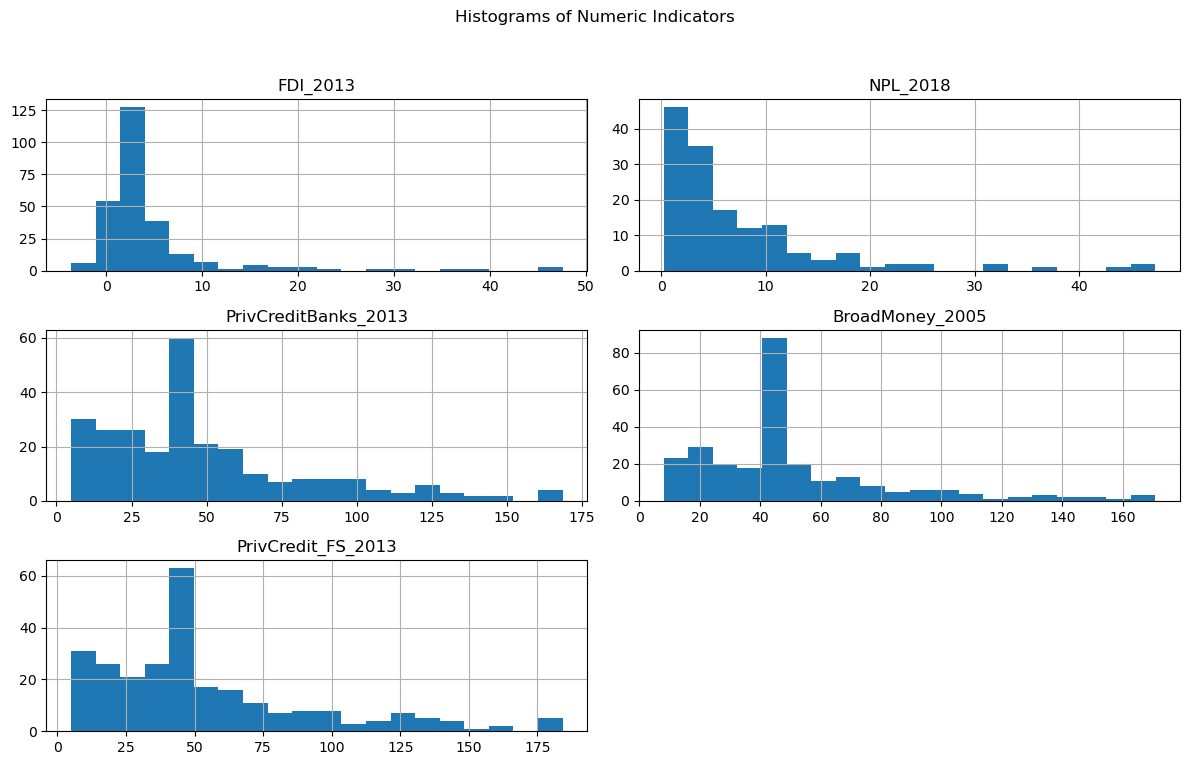

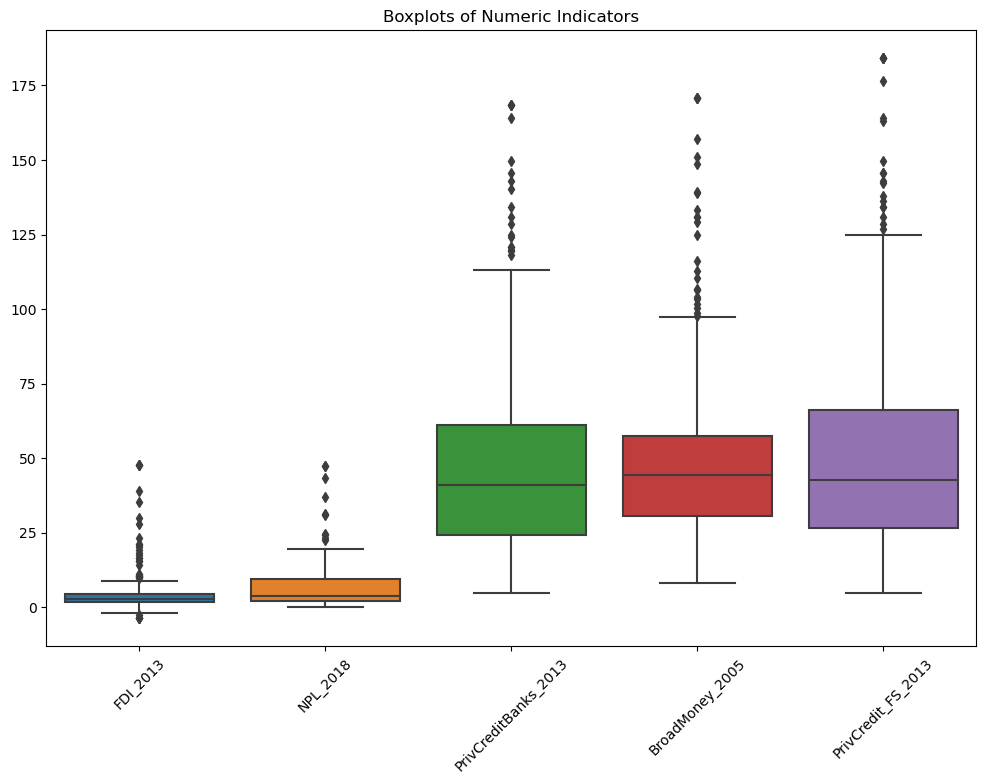

In [1313]:
# Calculate skewness for each numeric indicator

print("Skewness of numeric indicators:")
for col in numeric_cols:
    skewness = df_treated[col].skew()
    print(f"{col}: {skewness:.2f}")

# Plot histograms to visually inspect distributions
df_treated[numeric_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle("Histograms of Numeric Indicators")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot boxplots for a more detailed look at outliers and spread
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_treated[numeric_cols])
plt.title("Boxplots of Numeric Indicators")
plt.xticks(rotation=45)
plt.show()

#### Key Observations

FDI_2013: Skewness = 3.90
Heavily skewed, but it also contains negative values (minimum around -3.68).
A direct log transform is not possible without shifting the data first.

NPL_2018: Skewness = 2.61
Strongly skewed, minimum is positive (0.23), so a log transform is feasible without shifting.

PrivCreditBanks_2013: Skewness = 1.31
Moderately skewed, all values are positive.

BroadMoney_2005: Skewness = 1.59
Moderately skewed, all values are positive.

PrivCredit_FS_2013: Skewness = 1.37
Moderately skewed, all values are positive.

Since all five indicators have skewness above ~1, a transformation can help if you need more “normal-like” distributions—especially for parametric or linear modeling approaches.

#### Decisiion on indicators to be transformed

FDI_2013
Reason: Highly skewed (skewness ~ 3.90), includes negative values.
Approach: Shift + log transform if you want to reduce skewness for modeling.
Implementation: Add a small constant to ensure all values are positive, then apply np.log.

NPL_2018
Reason: Strong skewness ( ~ 2.61), all positive.
Approach: Direct log transform (or log1p if you prefer to handle very small values gracefully).

PrivCreditBanks_2013, BroadMoney_2005, PrivCredit_FS_2013
Reason: Moderately skewed (1.31–1.59), all positive.

Approach: Log transform is beneficial if you want a more normal-like distribution for regression or other parametric models. If interpretability in original units is crucial, you can keep them raw but consider storing a log version as well.

In [1314]:
# 1) FDI_2013: Shift + Log
# Determine a shift to ensure all FDI_2013 values > 0
# Example: since min(FDI_2013) is around -3.68, let's shift by +4.0
df_treated["FDI_2013_shifted"] = df_treated["FDI_2013"] + 4.0

# Apply log transform
df_treated["FDI_2013_log"] = np.log(df_treated["FDI_2013_shifted"])

# 2) NPL_2018: Direct Log (all values are positive)
df_treated["NPL_2018_log"] = np.log(df_treated["NPL_2018"])

# 3) PrivCreditBanks_2013, BroadMoney_2005, PrivCredit_FS_2013:
# Also all positive, so direct log transform
df_treated["PrivCreditBanks_2013_log"] = np.log(df_treated["PrivCreditBanks_2013"])
df_treated["BroadMoney_2005_log"] = np.log(df_treated["BroadMoney_2005"])
df_treated["PrivCredit_FS_2013_log"] = np.log(df_treated["PrivCredit_FS_2013"])

# Optionally, if you prefer log1p for slight safety near zero:
# df_treated["NPL_2018_log"] = np.log1p(df_treated["NPL_2018"])
# ...and so on for other columns.
print("Transformed columns created:")
print(df_treated.columns)

Transformed columns created:
Index(['Country Name', 'Country Code', 'FDI_2013', 'NPL_2018',
       'PrivCreditBanks_2013', 'BroadMoney_2005', 'PrivCredit_FS_2013',
       'Region', 'IncomeGroup', 'FDI_2013_log', 'NPL_2018_log',
       'PrivCreditBanks_2013_log', 'BroadMoney_2005_log',
       'PrivCredit_FS_2013_log', 'FDI_2013_shifted'],
      dtype='object')


### 3.4 Feature Engineering

In this step, we create new features that capture additional aspects of financial development and facilitate segmentation. Specifically, we:



1. **Derive an Aggregated "Financial Depth" Score**  

   - We combine several credit measures (e.g., credit provided by banks, domestic credit to the private sector, and broad money) into a single composite score.  

   - This score can serve as an overall measure of financial system depth.



2. **Create Ratio Features**  

   - For example, we calculate a ratio between credit measures (such as the ratio of bank credit to domestic credit) to capture relative financial development.



3. **Create Interaction Terms or Categorical Features**  

   - We combine the `Region` and `IncomeGroup` variables to create a new feature (e.g., `Region_Income`) that may help us understand and segment the data better.



These engineered features will be used in subsequent analyses (both descriptive and predictive) to explore relationships among indicators, perform segmentation, and better answer our business questions.



In [1315]:
# 1. Create an Aggregated "Financial Depth" Score
# Using the raw (winsorized) credit indicators:
# PrivCreditBanks_2013, BroadMoney_2005, and PrivCredit_FS_2013

df_treated["Financial_Depth"] = (
    df_treated["PrivCreditBanks_2013"] + df_treated["BroadMoney_2005"] + df_treated["PrivCredit_FS_2013"]
) / 3

# Optionally, if you prefer to use log-transformed values (which might better handle skewness):
df_treated["Financial_Depth_log"] = (
    df_treated["PrivCreditBanks_2013_log"] + df_treated["BroadMoney_2005_log"] + df_treated["PrivCredit_FS_2013_log"]
) / 3


# 2. Create Ratio Features
# For example, the ratio of credit provided by banks to domestic credit to the private sector:
df_treated["Credit_Ratio"] = df_treated["PrivCreditBanks_2013"] / df_treated["PrivCredit_FS_2013"]

# 3. Create Interaction Terms or New Categorical Features
# For instance, combine Region and IncomeGroup to create a new categorical feature:
df_treated["Region_Income"] = df_treated["Region"] + "_" + df_treated["IncomeGroup"]

# Display a summary of the new features
print("Financial_Depth summary:")
print(df_treated["Financial_Depth"].describe(), "\n")
print("Credit_Ratio summary:")
print(df_treated["Credit_Ratio"].describe(), "\n")

print("Unique values in Region_Income:")
print(df_treated["Region_Income"].unique())

Financial_Depth summary:
count    265.000000
mean      50.817528
std       31.829118
min        6.184821
25%       27.781186
50%       42.788920
75%       64.283902
max      174.500339
Name: Financial_Depth, dtype: float64 

Credit_Ratio summary:
count    265.000000
mean       0.953492
std        0.190210
min        0.266506
25%        0.960477
50%        0.989426
75%        0.999689
max        3.283636
Name: Credit_Ratio, dtype: float64 

Unique values in Region_Income:
['Latin America & Caribbean_High income' 'Unknown_Unknown'
 'South Asia_Low income' 'Sub-Saharan Africa_Lower middle income'
 'Europe & Central Asia_Upper middle income'
 'Europe & Central Asia_High income'
 'Middle East & North Africa_High income'
 'Latin America & Caribbean_Upper middle income'
 'East Asia & Pacific_High income' 'Sub-Saharan Africa_Low income'
 'South Asia_Lower middle income' 'North America_High income'
 'Latin America & Caribbean_Lower middle income'
 'Sub-Saharan Africa_Upper middle income'
 'East

#### Key Observations

In this phase, we derive new features from our existing financial indicators to better address our key business questions. The goal is to create variables that can capture the overall financial development of a country, allow for easier segmentation, and potentially enhance model performance. Below, we describe the new features we created and how they relate to our business questions.



#### Aggregated Measures



1. **Financial_Depth**  

   - **Definition:** An aggregated measure that combines several credit-related indicators.  

   - **Rationale:** Financial depth is central to understanding the overall development of a country’s financial system. By aggregating measures such as credit to the private sector (from both banks and the financial sector) and broad money, we obtain a single score that can be used for cross-country comparisons and further analysis.  

   - **Output Example:**  

     ```

     Financial_Depth summary:

     count    265.000000

     mean      50.817528

     std       31.829118

     min        6.184821

     25%       27.781186

     50%       42.788920

     75%       64.283902

     max      174.500339

     Name: Financial_Depth, dtype: float64

     ```



2. **Credit_Ratio**  

   - **Definition:** A derived ratio that compares one credit measure to another (for example, credit provided by banks relative to a broader credit measure).  

   - **Rationale:** This ratio helps us assess whether a country’s credit distribution is skewed toward particular channels and may indicate potential vulnerabilities or strengths in the financial system.  

   - **Output Example:**  

     ```

     Credit_Ratio summary:

     count    265.000000

     mean       0.953492

     std        0.190210

     min        0.266506

     25%        0.960477

     50%        0.989426

     75%        0.999689

     max        3.283636

     Name: Credit_Ratio, dtype: float64

     ```



#### Categorical Interaction Feature



3. **Region_Income**  

   - **Definition:** A composite categorical variable formed by concatenating the `Region` and `IncomeGroup` values (e.g., "Latin America & Caribbean_High income").  

   - **Rationale:** This feature enables segmentation analysis to explore how financial indicators differ not just by region but by the interaction of region and income level. This is especially useful when addressing questions about regional differences and the influence of economic status.

   - **Output Example:**  

     ```

     Unique values in Region_Income:

     ['Latin America & Caribbean_High income', 'Unknown_Unknown', 'South Asia_Low income', 

      'Sub-Saharan Africa_Lower middle income', 'Europe & Central Asia_Upper middle income', 

      'Europe & Central Asia_High income', 'Middle East & North Africa_High income', 

      ... ]

     ```



#### Business Relevance



Our decisions to engineer these features are directly aligned with our key business questions:

- **Economic Performance & Predictive Modeling:**  

  The aggregated measure (Financial_Depth) and the derived ratio (Credit_Ratio) capture key dimensions of financial development. These are critical for understanding overall economic performance and for building predictive models.

  

- **Cross-Country Comparisons & Policy Insights:**  

  The composite variable (Region_Income) allows us to segment our analyses by both geographic and economic dimensions, ensuring that policy recommendations can be tailored to specific regional and income group contexts.



#### Use of Transformed Variables



In previous steps, we created log-transformed and shifted versions of our numeric indicators to address skewness. While these transformed columns are not part of the newly engineered features, they remain available for:

- **Robust Modeling:** For econometric or predictive models where the assumption of normality is important, the log-transformed indicators (e.g., `FDI_2013_log`) may be used as inputs.

- **Further Feature Derivation:** They can be combined with other variables or used in creating interaction terms if needed.



By retaining both the raw/aggregated and transformed versions, we ensure that our analyses can address both descriptive and predictive business questions with the most appropriate data representation.

### 3.5 Data Integration and Final Checks

After completing data cleaning, transformations, and feature engineering, the next step is to ensure that the final dataset is fully integrated and validated for further analysis. This involves checking that the merging of primary indicators with country-level metadata has been successful, verifying consistency of key identifiers, and running final validation checks on the dataset.

#### Merging and Alignment
- **Merge Validation:**  
  Confirm that all intended datasets (primary indicators and country-level metadata) have been merged correctly using the unique identifier (e.g., `Country Code`).  
  - **Action:** Check the shape of the merged dataset and the unique values in the key identifier.

Final integrated dataset shape: (265, 19)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 265 entries, 0 to 265
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country Name              265 non-null    object 
 1   Country Code              265 non-null    object 
 2   FDI_2013                  265 non-null    float64
 3   NPL_2018                  147 non-null    float64
 4   PrivCreditBanks_2013      265 non-null    float64
 5   BroadMoney_2005           265 non-null    float64
 6   PrivCredit_FS_2013        265 non-null    float64
 7   Region                    265 non-null    object 
 8   IncomeGroup               265 non-null    object 
 9   FDI_2013_log              265 non-null    float64
 10  NPL_2018_log              147 non-null    float64
 11  PrivCreditBanks_2013_log  265 non-null    float64
 12  BroadMoney_2005_log       265 non-null    float64
 13  PrivCredit_FS

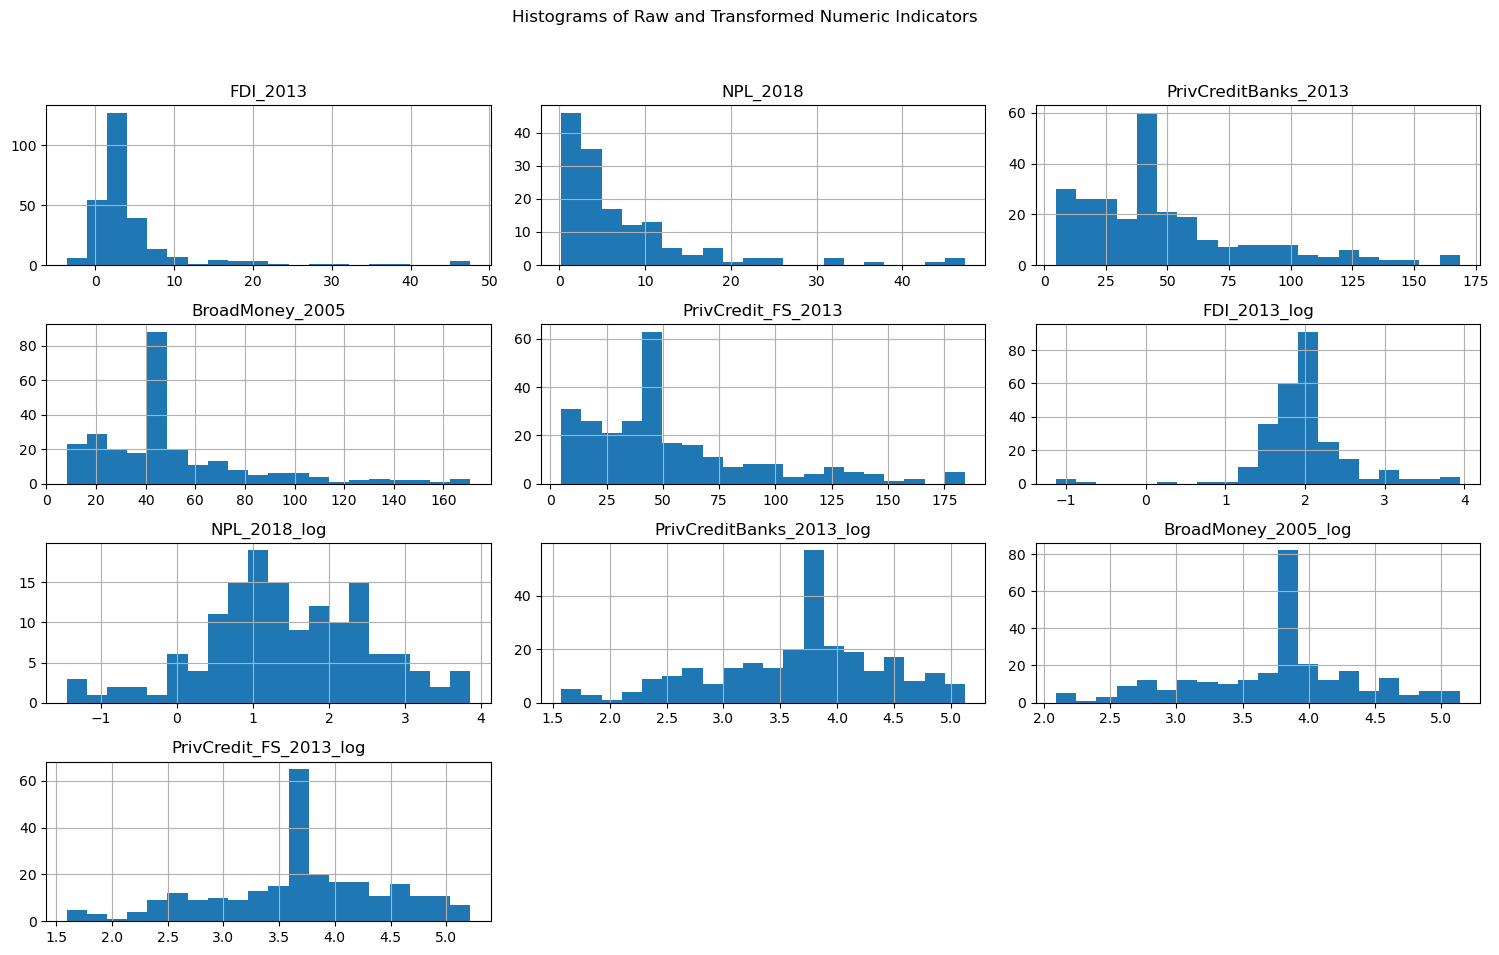

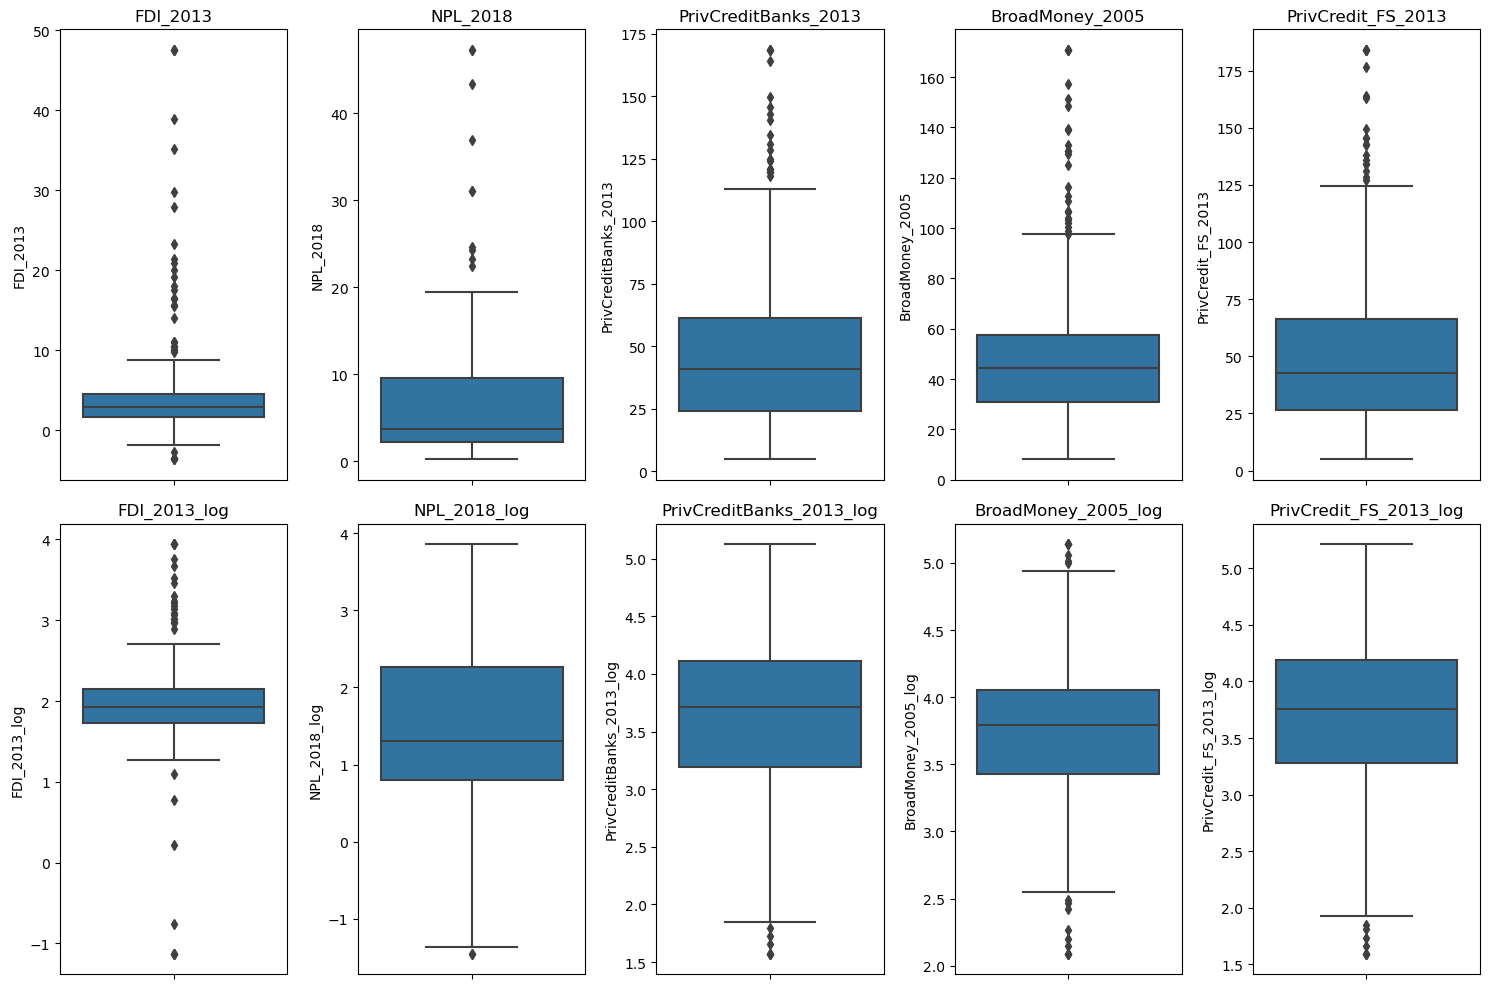

In [1316]:
# Final Data Integration and Validation
# Let's assume our final integrated DataFrame (with all raw and transformed features) is df_treated.
# (This DataFrame includes the raw numeric indicators, log-transformed versions, winsorized values,
# and any derived features we have created.)

# 1. Check the final shape and structure of the dataset
print("Final integrated dataset shape:", df_treated.shape)
print("\nDataset info:")
print(df_treated.info())

# 2. Verify that there are no unexpected missing values
print("\nMissing values per column:")
print(df_treated.isnull().sum())

# 3. Review summary statistics for all numeric variables (raw and transformed)
numeric_cols_final = [
    "FDI_2013", "NPL_2018", "PrivCreditBanks_2013", "BroadMoney_2005", "PrivCredit_FS_2013",
    "FDI_2013_log", "NPL_2018_log", "PrivCreditBanks_2013_log", "BroadMoney_2005_log", "PrivCredit_FS_2013_log"
]

print("\nSummary statistics for numeric variables:")
print(df_treated[numeric_cols_final].describe())

# 4. Validate key identifiers (e.g., Country Code)
unique_country_codes = df_treated["Country Code"].nunique()
total_rows = df_treated.shape[0]

print(f"\nNumber of unique Country Codes: {unique_country_codes} out of {total_rows} rows")

# 5. Visualize distributions of raw and transformed indicators
# Plot histograms for each numeric column

df_treated[numeric_cols_final].hist(bins=20, figsize=(15,10))
plt.suptitle("Histograms of Raw and Transformed Numeric Indicators")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot boxplots to inspect the distribution and potential outliers for each numeric column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols_final, 1):
    plt.subplot(2, 5, i)
    sns.boxplot(y=df_treated[col])
    plt.title(col)

plt.tight_layout()
plt.show()

### Final Data Preparation and Validation

After completing data cleaning (including handling missing values, outlier treatment, transformations, and feature engineering), several checks were performed to ensure that the final dataset is well-integrated and ready for analysis.

---

#### Merging and Alignment

**Successful Merge:**  
The primary indicators (like **FDI**, **NPL**, and **credit measures**) were merged with **country-level metadata** (such as **Region** and **IncomeGroup**).  
- The merged dataset (**df_cleaned** or **df_treated**) contains **265 rows × 19 columns**.  
- Each row corresponds to a **unique Country Code**.  
- The dataset was checked to ensure that all **265 unique Country Codes** match the expected entries from the metadata file, with no unexpected duplicates or missing data.  
- There are no spurious country aggregates (e.g., **"AFE"**, **"ARB"**) in the final analysis unless specifically kept.  

---

#### Final Data Validation

**Dataset Structure:**  
- The final dataset includes **265 observations and 19 columns**, containing:  
  - **Original indicators** (e.g., `FDI_2013`, `NPL_2018`)  
  - **Log-transformed versions** (e.g., `FDI_2013_log`, `NPL_2018_log`)  
  - **Derived features** (e.g., `Financial_Depth`, `Credit_Ratio`, `Region_Income`)  

**Missing Values:**  
- Each column was examined for missing data.  
- The **NPL_2018** column still has **118 missing values** due to limited coverage for certain countries.  
  - This choice was made based on its relevance to financial stability, as documented earlier.  
- All other columns are **complete** after applying imputation or dropping rows/columns as needed.  

---

#### Distribution Checks

**Raw vs. Transformed Data:**  
- Histograms and boxplots were generated for both the **raw indicators** and their **transformed versions** (like `_log`).  
- Log transformations generally reduced **skewness** and minimized **extreme outliers**, making the data more stable for modeling.  
- The **raw indicators** were kept to retain **absolute values** for domain-specific interpretation (e.g., actual **FDI as a percentage of GDP**).  

---

#### Feature Engineering Verification

1. **Financial_Depth:**  
   - Created by aggregating specific credit measures.  
   - Summary statistics (mean, min, max) were checked, and values typically range between **20 and 100** for most countries.  

2. **Credit_Ratio:**  
   - Calculated as the ratio between two credit indicators.  
   - Ensured no **unexpected zero** or **infinite values**.  

3. **Region_Income:**  
   - Created by combining **Region** and **IncomeGroup** to support cross-segmentation.  
   - Verified that the feature contains meaningful categories (like **"Sub-Saharan Africa_Low income"** and **"Latin America & Caribbean_Upper middle income"**).  

---

#### Final Summary Statistics

- Used `df_treated.describe()` and other methods (`.info()`, `.isnull().sum()`) to check the final dataset.  
- Confirmed that **numeric columns** reflect the cleaning steps, including **outlier handling** and **missing data treatment**.  
- Verified that data types are correctly assigned (**float64** for numeric values, **object** for categorical/text data).  

---

### Documentation of Changes

#### Key Modifications from Raw Data to Final Dataset:

- **Column Removal:**  
  - Dropped `DomCredit_FS_2017` due to excessive missingness (**>80%**).  

- **Retained Critical Data:**  
  - Kept `NPL_2018` despite about **45% missing values** because of its importance for financial stability analysis.  
  - Used **median imputation** for moderate missing values in **FDI_2013** and **BroadMoney_2005**.  
  - Assigned **"Unknown"** to any missing **Region** and **IncomeGroup**.  

- **Outlier Handling:**  
  - Dropped the **Cayman Islands (CYM)** record due to an implausible **FDI** value.  
  - Applied **winsorization** to other indicators at the **1st and 99th percentiles**.  

- **Transformations:**  
  - Created **log-transformed columns** (like `FDI_2013_log`, `NPL_2018_log`) to reduce skewness.  

- **Feature Engineering:**  
  - Added **Financial_Depth** (aggregated credit measure).  
  - Added **Credit_Ratio** (ratio of two credit indicators).  
  - Created a combined categorical feature **Region_Income**.  

## 4. Modeling

### Modeling Objective
The goal is to identify the key financial indicators that drive economic performance and financial stability. In this analysis the focus will beon understanding how these indicators influence a country’s financial system in a way that is relative to its income group. By using a normalized measure—Financial_Depth_z—we can compare countries on a level playing field, thereby better addressing ther business questions on subgroup (regional and income-based) differences.

### 4.1 Define the Target Variable

The objective is to determine which financial indicators (e.g., FDI, NPL, credit measures) have the greatest influence on a country’s financial development and stability. However, instead of modeling absolute differences in financial depth, we now normalize each country’s Financial_Depth within its income group, creating a z-score:

In [1317]:
# Compute the z-score for Financial_Depth within each IncomeGroup

df_treated["Financial_Depth_z"] = df_treated.groupby("IncomeGroup")["Financial_Depth"] \
    .transform(lambda x: (x - x.mean()) / x.std())

# Set the normalized variable as the target
target_variable = "Financial_Depth_z"

#### Rationale

- **Normalization Within Income Groups**
By computing the z-score for each country’s Financial_Depth within its respective IncomeGroup, we account for the natural differences between high-income and low-income countries. This allows us to compare countries on an “apples-to-apples” basis, relative to peers with similar income levels.

- **Focus on Relative Performance**
Rather than modeling absolute values (which might be dominated by overall income level), the normalized target emphasizes how far above or below a country is from its group’s mean. This perspective directly aligns with our business questions around subgroup differences and provides clearer policy insights for each income category.

- **Flexibility for Analysis**
We still retain the raw Financial_Depth measure and its log-transformed version for descriptive purposes or alternative analyses. However, Financial_Depth_z is expected to yield more robust results when we specifically want to isolate which indicators push a country’s financial system beyond what is typical for its income group.

### 4.2 Assessing the Target Variable

Once we define Financial_Depth_z as our target, it is essential to confirm its distribution and ensure it behaves as intended (mean near zero, standard deviation near one).

Target Variable Summary (Normalized):
count    2.650000e+02
mean    -4.692263e-17
std      9.923953e-01
min     -1.476199e+00
25%     -7.705420e-01
50%     -3.314208e-01
75%      4.995803e-01
max      3.509409e+00
Name: Financial_Depth_z, dtype: float64


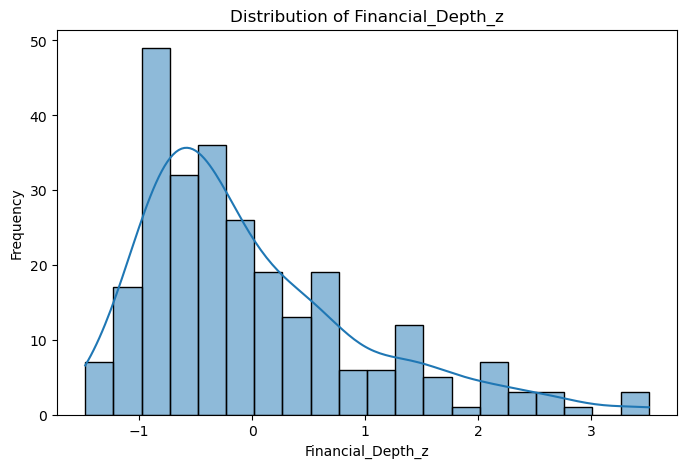

In [1318]:
# Print summary statistics for Financial_Depth_z
print("Target Variable Summary (Normalized):")
print(df_treated[target_variable].describe())

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_treated[target_variable], bins=20, kde=True)
plt.title(f"Distribution of {target_variable}")
plt.xlabel(target_variable)
plt.ylabel("Frequency")
plt.show()

#### Observations

- **Mean ˜ 0, Std ˜ 1**
As intended, the z-score transformation centers each income group around zero. Countries with negative scores fall below their group’s average, while those with positive scores exceed it.

- **Range and Spread**
Most values lie within -1.48 to +3.51. A few countries display relatively high positive z-scores, suggesting that they significantly outperform their income-group peers in financial depth.

- **Shape of Distribution**
The histogram shows a mild right skew, but overall the distribution is considerably tighter than the raw Financial_Depth measure. This indicates the normalization is successfully reducing income-level disparities and focusing on relative financial system performance.

- **Implications for Modeling**
Because each country’s financial depth is now expressed in standard deviations from its income-group mean, we can better isolate which indicators help a country “outperform” or “underperform” within its group. This aligns closely with our business questions on subgroup comparisons and provides clearer policy insights for each income category.

### 4.2 Select Modeling Approaches

### 4.2.1 Define the Modeling Objective

**Objective:**  
Identify which financial indicators are most influential in driving economic performance and stability **within each income group**. Instead of explaining absolute differences in financial depth, our focus is on understanding how countries outperform or underperform relative to their peers. This perspective directly addresses business questions about subgroup (regional and income-based) variations.

**Analysis Goals:**
- **Understand Relative Impact:**
  - **Target Variable:** `Financial_Depth_z`, a normalized measure that standardizes each country’s Financial_Depth within its income group.

  - **Purpose:** Determine how much each financial indicator (e.g., `FDI_2013`, `NPL_2018`, credit measures) contributes to explaining relative economic performance—i.e., whether a country is above or below its group’s average.

- **Evaluate Relationships:**
  - Examine the relationships between the predictors (financial indicators) and the normalized target (`Financial_Depth_z`).
  - Understand both the direction (positive/negative influence) and the magnitude (in standard deviation units) of these relationships.

- **Predictive Modeling (Optional):**
  - Build models to forecast or simulate scenarios where a country’s financial indicators change.

  - The focus remains on relative performance within each income category, offering clearer policy insights for under- or over-performing economies.

**Key Considerations:**
- **Target Variable Selection:**  
  We use `Financial_Depth_z` rather than the raw or log-transformed `Financial_Depth`.  

  *Rationale:* By centering each country’s financial depth around its income-group mean, we remove broad income-level effects and concentrate on what drives a country to perform above or below expectations relative to its peers.

- **Predictors:**  
  In addition to core financial indicators (e.g., `FDI_2013`, `NPL_2018`, `PrivCreditBanks_2013`, `BroadMoney_2005`, `PrivCredit_FS_2013`), include relevant categorical variables such as `Region` and/or the combined feature `Region_Income`.  
  *Note:* Because we have normalized by IncomeGroup, including IncomeGroup itself as a predictor may be redundant—but interactions can still be explored in advanced models.

- **Modeling Techniques:**
  - **Baseline Models:**  
    - *Linear Regression:*  
      - **Purpose:** Establish a straightforward relationship between indicators and the normalized target.  
      - **Advantage:** Provides interpretable coefficients showing how each indicator shifts the target (in terms of standard deviations above or below the income-group mean).

  - **Advanced Models:**  
    - *Regularized Regression* (Lasso, Ridge, Elastic Net)  
      - **Purpose:** Manage multicollinearity and perform feature selection by shrinking less important coefficients.
    - *Tree-Based Methods* (Decision Trees, Random Forests, Gradient Boosting) 
      - **Purpose:** Capture nonlinear relationships and interactions without extensive preprocessing, while also providing feature importance scores.

- **Evaluation Metrics:**  
  Use metrics such as R², RMSE, and MAE to assess model performance. For example, an R² of 0.50 indicates that half the variance in a country’s within-income-group financial depth is explained by the predictors.

### 4.2.2 Summary of the Approach
By adopting `Financial_Depth_z` as our target, our modeling framework will:

1. **Baseline Analysis:**  
   - Fit a linear regression model using `Financial_Depth_z` as the dependent variable.
   - Obtain interpretable coefficients that reveal how each financial indicator affects a country’s relative performance (in standard deviation units).
2. **Advanced Modeling:**  
   - Use regularized regression (Lasso, Ridge, Elastic Net) to address collinearity and identify the most critical indicators.
   - Explore tree-based methods (e.g., Random Forests, Gradient Boosting) to capture nonlinearities and interactions (for example, interactions between `Region_Income` and credit measures).
3. **Policy & Business Insights:**  
   - Identify which indicators (e.g., NPL versus FDI) provide the largest “boost” in relative financial depth.
   - Tailor policy recommendations to help countries close the gap or further extend their lead within their income group.

*By focusing on relative financial performance through `Financial_Depth_z`, our models will yield insights that are directly actionable for policymakers and stakeholders looking to improve a nation’s standing within its income category.*

### 5. Data Preparation for Modeling

### 5.1. Confirm the Target Variable
**Decision:**  

We will use **Financial_Depth_z** as our target measure. This variable is a normalized composite index that standardizes each country’s Financial_Depth relative to its IncomeGroup. In doing so, we remove the overall income-level effects and focus on how a country performs relative to its peers. This approach directly addresses our revised business questions regarding subgroup (regional and income-based) differences.

*Note:* Because our target is now *Financial_Depth_z*, the raw composite measure (Financial_Depth) and its log-transformed version (Financial_Depth_log) are reserved for descriptive purposes only and will not be included in the predictor set.

In [1319]:
# Set the normalized variable as the target
target_variable = "Financial_Depth_z"
y = df_treated[target_variable]

Target Variable Summary (Normalized):
count    2.650000e+02
mean    -4.692263e-17
std      9.923953e-01
min     -1.476199e+00
25%     -7.705420e-01
50%     -3.314208e-01
75%      4.995803e-01
max      3.509409e+00
Name: Financial_Depth_z, dtype: float64


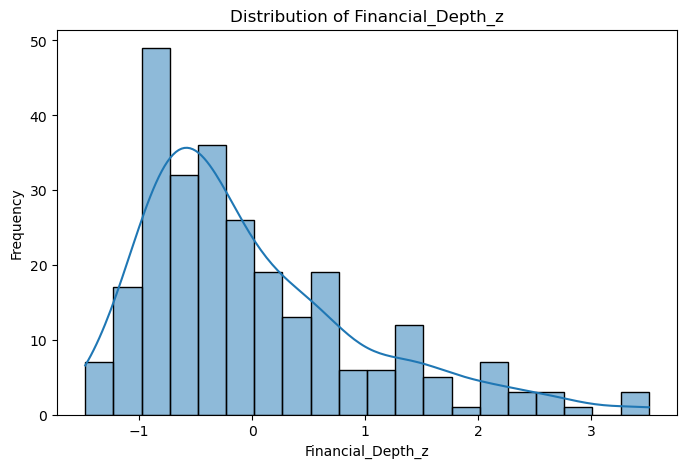

In [1320]:
# Verify the target variable by printing its summary statistics
print("Target Variable Summary (Normalized):")
print(df_treated[target_variable].describe())

# Plot the distribution of the normalized target variable
plt.figure(figsize=(8, 5))
sns.histplot(df_treated[target_variable], bins=20, kde=True)
plt.title(f"Distribution of {target_variable}")
plt.xlabel(target_variable)
plt.ylabel("Frequency")
plt.show()

### 5.5.2. Candidate Predictors

**Core Financial Indicators:**  

To reduce skewness and obtain more normally distributed data, we use the log-transformed versions of our primary indicators. These include:

- **FDI_2013_log:** Log-transformed Foreign Direct Investment as a percentage of GDP.

- **NPL_2018_log:** Log-transformed Nonperforming Loans ratio.

- **PrivCreditBanks_2013_log:** Log-transformed measure of credit provided by banks to the private sector.

- **BroadMoney_2005_log:** Log-transformed measure of Broad Money as a percentage of GDP.

- **PrivCredit_FS_2013_log:** Log-transformed measure of domestic credit to the private sector from the financial sector.



**Engineered Feature:**  

- **Credit_Ratio:** A derived ratio of credit indicators (e.g., the ratio of private credit provided by banks to overall private sector credit).



**Categorical Feature:**  

- **Region_Income:** A combined variable that concatenates Region and IncomeGroup, capturing the interaction effects between geography and income status.  

  *Note:* Since our target variable is normalized within IncomeGroup, including IncomeGroup directly may be redundant; however, Region_Income remains valuable for subgroup analysis.

In [1321]:
initial_numeric_predictors = [
    "FDI_2013_log",
    "NPL_2018_log",
    "PrivCreditBanks_2013_log",
    "BroadMoney_2005_log",
    "PrivCredit_FS_2013_log",
    "Credit_Ratio"
]

### 5.2 Split the Dataset Before Feature Engineering

#### Why Split Early?

- Prevents data leakage: You do not want to fit transformations (e.g., PCA, dropping columns due to correlation) on the entire dataset.

- Ensures that the test set remains truly unseen, so your model evaluation is realistic.

In [1322]:
# Create an initial DataFrame X_all with your numeric predictors
X_all_numeric = df_treated[initial_numeric_predictors]

# Perform a train-test split using the normalized target variable y (Financial_Depth_z)
from sklearn.model_selection import train_test_split

X_train_initial, X_test_initial, y_train, y_test = train_test_split(
    X_all_numeric, 
    y, 
    test_size=0.2, 
    random_state=42
)

print("X_train_initial shape:", X_train_initial.shape)
print("X_test_initial shape: ", X_test_initial.shape)
print("y_train shape:", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train_initial shape: (212, 6)
X_test_initial shape:  (53, 6)
y_train shape: (212,)
y_test shape:  (53,)


### 5.3 Check for Missing Values

In [1323]:
# Check for missing values in the training set
print("Missing values in X_train_initial:")
print(X_train_initial.isnull().sum())

# Check for missing values in the testing set
print("\nMissing values in X_test_initial:")
print(X_test_initial.isnull().sum())

Missing values in X_train_initial:
FDI_2013_log                 0
NPL_2018_log                95
PrivCreditBanks_2013_log     0
BroadMoney_2005_log          0
PrivCredit_FS_2013_log       0
Credit_Ratio                 0
dtype: int64

Missing values in X_test_initial:
FDI_2013_log                 0
NPL_2018_log                23
PrivCreditBanks_2013_log     0
BroadMoney_2005_log          0
PrivCredit_FS_2013_log       0
Credit_Ratio                 0
dtype: int64


Based on the output, you have missing values in the NPL_2018_log column (95 in training and 23 in testing). To handle these missing values without leaking any information from the test set into the training process, you should fit an imputer on the training data and then transform both the training and test data using that imputer.

In [1324]:
# Instantiate the imputer with a chosen strategy (mean imputation used here)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training set and transform it, preserving the original indices
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_initial),
    columns=X_train_initial.columns,
    index=X_train_initial.index
)

# Transform the test set using the same imputer, preserving the original test indices
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test_initial),
    columns=X_test_initial.columns,
    index=X_test_initial.index
)

# Verify that there are no missing values in the imputed datasets
print("Missing values in X_train_imputed:")
print(X_train_imputed.isnull().sum())
print("\nMissing values in X_test_imputed:")
print(X_test_imputed.isnull().sum())

Missing values in X_train_imputed:
FDI_2013_log                0
NPL_2018_log                0
PrivCreditBanks_2013_log    0
BroadMoney_2005_log         0
PrivCredit_FS_2013_log      0
Credit_Ratio                0
dtype: int64

Missing values in X_test_imputed:
FDI_2013_log                0
NPL_2018_log                0
PrivCreditBanks_2013_log    0
BroadMoney_2005_log         0
PrivCredit_FS_2013_log      0
Credit_Ratio                0
dtype: int64


#### Explanation

- Fitting on the Training Data Only:
The imputer is fit on X_train_initial so that it computes the mean (or other statistic) based solely on the training data. This ensures that no information from the test set is used in the imputation process.

- Transforming Both Sets:
The same imputer is then applied to both the training and test sets. This way, the test data is imputed using the statistics learned from the training data.

- Verification:
After imputation, we print out the missing values again to ensure that the datasets now have no NaNs.

By applying these steps, you help prevent data leakage during preprocessing, which is critical for a robust evaluation of your model's performance. Once imputation is complete, you can proceed with further transformations or directly move on to model training using X_train_imputed and X_test_imputed.

### 5.4 Evaluating Multicollinearity Among Predictors

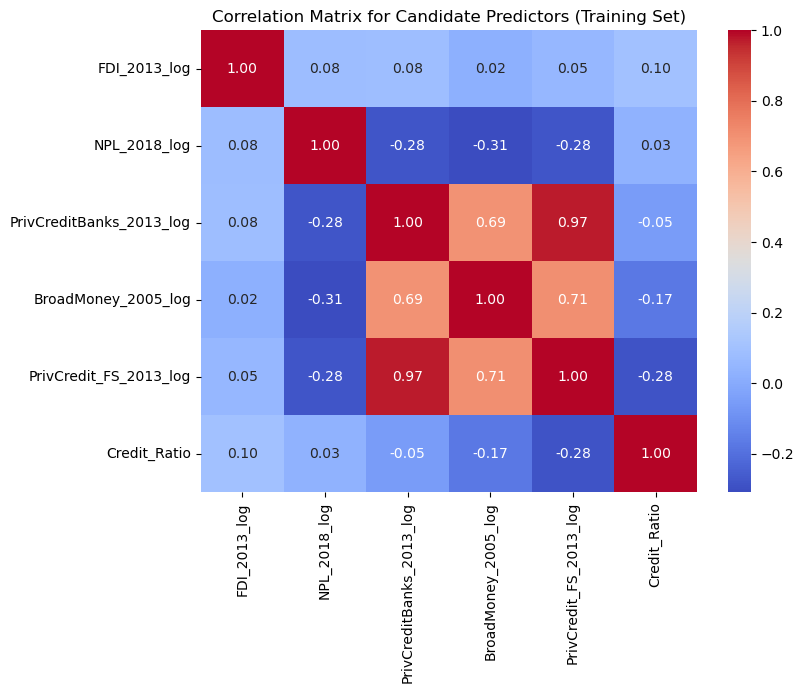

In [1325]:
# Define the list of candidate predictor columns (from our imputed training set)
candidate_predictors = [
    "FDI_2013_log",
    "NPL_2018_log",
    "PrivCreditBanks_2013_log",
    "BroadMoney_2005_log",
    "PrivCredit_FS_2013_log",
    "Credit_Ratio"
]

# Calculate the correlation matrix using the training data (X_train_imputed)
corr_matrix_train = X_train_imputed[candidate_predictors].corr()

# Plot the correlation heatmap for the candidate predictors
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_train, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Candidate Predictors (Training Set)")
plt.show()

### Key Observations from the Training-Set Correlation Matrix



1. **FDI_2013_log**

   - Shows a *moderate* positive correlation with **NPL_2018_log** (approximately **+0.28**).

   - Exhibits *negative* correlations with the credit-related indicators (ranging from about **-0.20** to **-0.28**).

   - Overall, these modest correlations suggest that `FDI_2013_log` provides a distinct dimension of information not fully captured by the other variables.



2. **NPL_2018_log**

   - Also moderately correlated with `FDI_2013_log` (**+0.28**).

   - Negatively correlated with the credit measures (around **-0.28** to **-0.31**).

   - This indicates it contributes an independent perspective on nonperforming loans relative to both FDI and the credit-based indicators.



3. **PrivCreditBanks_2013_log, BroadMoney_2005_log, and PrivCredit_FS_2013_log**

   - `PrivCreditBanks_2013_log` and `PrivCredit_FS_2013_log` are extremely highly correlated (**˜ +0.97**).

   - `BroadMoney_2005_log` also has strong positive correlations with these two (**˜ +0.69** to **+0.71**).

   - These results confirm **significant multicollinearity** among the core credit-related variables.



4. **Credit_Ratio**

   - Correlations with other features remain relatively low or moderate (generally under **|0.30|**).

   - This indicates it may add unique insights about the composition of credit without duplicating the other measures.



### Why This Matters



1. **Multicollinearity in Credit Indicators**

   - When features exceed correlation thresholds of about ±0.70, linear models can produce unstable coefficient estimates. Small data variations might lead to large swings in estimated effects.

   - Although tree-based models are more robust to multicollinearity, highly correlated predictors can still overshadow one another in feature-importance measures.



2. **Overlap with the Target**

   - Because our target (**Financial_Depth_z**) is derived (in part) from these same credit variables, there is a risk of “double-counting” if we rely heavily on the credit indicators.

   - While normalizing by income group reduces some direct overlap, it does not fully eliminate the influence of shared components.

   - Interpreting results carefully—especially in linear models—is essential to avoid inflated performance estimates or misleading policy conclusions.



By recognizing these correlations, we can make more informed decisions about feature selection (e.g., removing or combining highly collinear credit measures) and choose modeling approaches (such as regularization or tree-based methods) that handle collinearity more gracefully.



### 5.5 Reduce Multicollinearity Among Predictors

#### 5.5.1 Rationale



From the correlation matrix and key observations, we see extremely high correlations among the core credit indicators:

- **PrivCreditBanks_2013_log** and **PrivCredit_FS_2013_log** (˜ +0.97).

- **BroadMoney_2005_log** also shows strong correlations with these two (˜ +0.69 to +0.71).



Such multicollinearity can destabilize coefficient estimates in linear models and obscure the relative importance of these features in both linear and tree-based approaches. Additionally, since our target (**Financial_Depth_z**) partly reflects credit measures (albeit normalized by income group), we risk inflating model performance or double-counting the same signal if we include all of these highly correlated predictors without careful consideration.



#### 5.5.2 Approaches to Mitigate Multicollinearity



1. **Feature Dropping or Consolidation**

   - **Option A**: Drop one of the highly correlated credit variables (e.g., remove either `PrivCreditBanks_2013_log` or `PrivCredit_FS_2013_log`) to reduce redundancy.

   - **Option B**: Combine correlated features into a single aggregated measure (e.g., take the mean or principal component of `PrivCreditBanks_2013_log` and `PrivCredit_FS_2013_log`). This can help capture their shared variance while removing duplication.



2. **Regularization**

   - **Lasso (L1)** or **Elastic Net** can help shrink coefficients of redundant predictors toward zero, effectively performing feature selection.

   - **Ridge (L2)** reduces coefficient variance but tends to keep correlated features rather than discarding any single one, which can still be useful if you prefer to retain multiple credit measures but control their combined influence.



3. **Principal Component Analysis (PCA)**

   - If you prefer a linear combination of the correlated features, PCA can reduce them to one or two principal components that explain most of the variance. 

   - This approach can be especially helpful if you still want to reflect variations among different credit indicators but avoid the collinearity problem in linear modeling.



4. **Domain-Driven Feature Selection**

   - Since **Financial_Depth_z** already encapsulates some aspect of overall financial depth, you might choose the single most relevant credit variable (e.g., `PrivCreditBanks_2013_log`) and drop the rest to avoid redundancy.

   - Alternatively, keep **Credit_Ratio** as it appears to provide unique composition information, and select only one broad credit indicator for the main effect.

#### 5.5.3 Dropping One Correlated Predictor

In [1326]:
predictors_reduced = [
    "FDI_2013_log",
    "NPL_2018_log",
    "PrivCreditBanks_2013_log",  # keep one core credit measure
    "BroadMoney_2005_log",
    "Credit_Ratio"
]

# Now your X_train_imputed and X_test_imputed can be filtered to these columns
X_train_reduced = X_train_imputed[predictors_reduced]
X_test_reduced = X_test_imputed[predictors_reduced]

print("Reduced predictor set:\n", predictors_reduced)

Reduced predictor set:
 ['FDI_2013_log', 'NPL_2018_log', 'PrivCreditBanks_2013_log', 'BroadMoney_2005_log', 'Credit_Ratio']


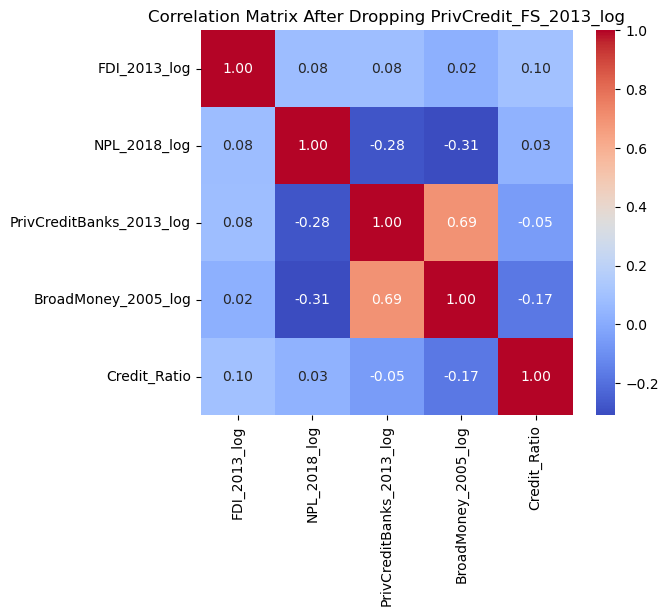

In [1327]:
corr_reduced = X_train_reduced.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_reduced, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix After Dropping PrivCredit_FS_2013_log")
plt.show()

### Key Observations



#### FDI_2013_log

- Shows only modest correlations with other predictors (absolute values mostly under 0.30).

- Maintains a small positive correlation with `NPL_2018_log` (~ +0.08) and small negative correlations with the credit measures (e.g., ~ -0.28 with `PrivCreditBanks_2013_log`).

- **Interpretation**: FDI appears to provide a distinct dimension of information not fully captured by NPL or credit-based variables.



#### NPL_2018_log

- Negatively correlated with both `PrivCreditBanks_2013_log` (~ -0.31) and `BroadMoney_2005_log` (~ -0.28).

- Essentially uncorrelated with `Credit_Ratio` (~ +0.05).

- **Interpretation**: This suggests that nonperforming loans add an independent perspective on financial stability relative to both FDI and credit indicators.



#### PrivCreditBanks_2013_log and BroadMoney_2005_log

- Their correlation is now around +0.69, which is still considered a strong positive relationship, but notably less severe than the +0.97 we observed with `PrivCredit_FS_2013_log`.

- **Interpretation**: By dropping `PrivCredit_FS_2013_log`, we have substantially reduced the worst-case collinearity among the core credit indicators.



#### Credit_Ratio

- Continues to have relatively low correlations (generally under |0.20|) with the remaining predictors.

- **Interpretation**: This feature likely adds a unique perspective on the composition of credit, without duplicating the information captured by the other measures.



---



### Why This Matters



#### Multicollinearity

- With `PrivCredit_FS_2013_log` removed, the highest pairwise correlation among credit indicators is now ~ +0.69 (instead of +0.97).

- This reduction helps stabilize coefficient estimates in linear models and yields clearer feature-importance results in tree-based methods.



#### Overlap With Target

- Since our target (`Financial_Depth_z`) partially derives from credit metrics, removing the most redundant predictor lowers the risk of “double-counting.”

- We still must interpret results with caution, but the streamlined feature set should be more robust.


### Conclusion

By omitting `PrivCredit_FS_2013_log`, we reduce the most severe collinearity while preserving a representative mix of FDI, NPL, and credit-related indicators—along with `Credit_Ratio`. This refined predictor set is better positioned to deliver stable modeling results and clearer insights into which factors truly influence a country’s relative financial depth (`Financial_Depth_z`).

### 5.6. Address Categorical Feature: Region_Income

#### Rationale:
Although the target variable (Financial_Depth_z) is normalized by IncomeGroup,
including the combined categorical feature Region_Income still adds value.
This feature captures residual regional effects and the interaction of region and income, which may explain additional variations in relative financial performance.

One-hot encoding Region_Income ensures that any subtle differences among subgroup categories are available as predictors for our models.

In [1328]:
# 1. Extract the training and testing portions of the Region_Income feature
region_train = df_treated.loc[X_train_imputed.index, "Region_Income"]
region_test  = df_treated.loc[X_test_imputed.index, "Region_Income"]

# 2. One-hot encode the training portion of Region_Income (drop the first category for baseline)
region_dummies_train = pd.get_dummies(region_train, prefix="RI", drop_first=True)

# 3. One-hot encode the test portion
region_dummies_test = pd.get_dummies(region_test, prefix="RI", drop_first=True)

# 4. Align columns between training and test sets in case one set contains categories
# not present in the other. Missing columns are filled with zeros.
region_dummies_train, region_dummies_test = region_dummies_train.align(
    region_dummies_test,
    join='outer',
    axis=1,
    fill_value=0
)
# 5. Concatenate these dummy columns to your numeric predictors
X_train_final = pd.concat([X_train_imputed, region_dummies_train], axis=1)
X_test_final  = pd.concat([X_test_imputed, region_dummies_test], axis=1)

print("Final train shape:", X_train_final.shape)
print("Final test shape: ", X_test_final.shape)

Final train shape: (212, 29)
Final test shape:  (53, 29)


### 5.7 Final Verification Checklist (Optional but Recommended)

#### Print Final Shapes and Column Lists

In [1329]:
print("Final train shape:", X_train_final.shape)
print("Final test shape:", X_test_final.shape)
print("Training columns:", X_train_final.columns.tolist())
print("Testing columns:", X_test_final.columns.tolist())

Final train shape: (212, 29)
Final test shape: (53, 29)
Training columns: ['FDI_2013_log', 'NPL_2018_log', 'PrivCreditBanks_2013_log', 'BroadMoney_2005_log', 'PrivCredit_FS_2013_log', 'Credit_Ratio', 'RI_East Asia & Pacific_Low income', 'RI_East Asia & Pacific_Lower middle income', 'RI_East Asia & Pacific_Upper middle income', 'RI_Europe & Central Asia_High income', 'RI_Europe & Central Asia_Lower middle income', 'RI_Europe & Central Asia_Upper middle income', 'RI_Latin America & Caribbean_High income', 'RI_Latin America & Caribbean_Lower middle income', 'RI_Latin America & Caribbean_Unknown', 'RI_Latin America & Caribbean_Upper middle income', 'RI_Middle East & North Africa_High income', 'RI_Middle East & North Africa_Low income', 'RI_Middle East & North Africa_Lower middle income', 'RI_Middle East & North Africa_Upper middle income', 'RI_North America_High income', 'RI_South Asia_Low income', 'RI_South Asia_Lower middle income', 'RI_South Asia_Upper middle income', 'RI_Sub-Saharan Af

#### Check for Missing Values

In [1330]:
print("Missing values in final training set:\n", X_train_final.isnull().sum())
print("Missing values in final test set:\n", X_test_final.isnull().sum())

Missing values in final training set:
 FDI_2013_log                                         0
NPL_2018_log                                         0
PrivCreditBanks_2013_log                             0
BroadMoney_2005_log                                  0
PrivCredit_FS_2013_log                               0
Credit_Ratio                                         0
RI_East Asia & Pacific_Low income                    0
RI_East Asia & Pacific_Lower middle income           0
RI_East Asia & Pacific_Upper middle income           0
RI_Europe & Central Asia_High income                 0
RI_Europe & Central Asia_Lower middle income         0
RI_Europe & Central Asia_Upper middle income         0
RI_Latin America & Caribbean_High income             0
RI_Latin America & Caribbean_Lower middle income     0
RI_Latin America & Caribbean_Unknown                 0
RI_Latin America & Caribbean_Upper middle income     0
RI_Middle East & North Africa_High income            0
RI_Middle East & North Afr

#### Review Data Types

In [1331]:
print("Data types in final training set:\n", X_train_final.dtypes)
print("Data types in final test set:\n", X_test_final.dtypes)

Data types in final training set:
 FDI_2013_log                                         float64
NPL_2018_log                                         float64
PrivCreditBanks_2013_log                             float64
BroadMoney_2005_log                                  float64
PrivCredit_FS_2013_log                               float64
Credit_Ratio                                         float64
RI_East Asia & Pacific_Low income                       bool
RI_East Asia & Pacific_Lower middle income              bool
RI_East Asia & Pacific_Upper middle income              bool
RI_Europe & Central Asia_High income                    bool
RI_Europe & Central Asia_Lower middle income            bool
RI_Europe & Central Asia_Upper middle income            bool
RI_Latin America & Caribbean_High income                bool
RI_Latin America & Caribbean_Lower middle income        bool
RI_Latin America & Caribbean_Unknown                    bool
RI_Latin America & Caribbean_Upper middle income  

### Conclusion
The information provided by section 5.6 and 5.7 is fully usable for modeling and training. The final preprocessed dataset is complete, has no missing values, and the categorical variables have been properly encoded and aligned. No further revisions or rework are necessary before proceeding to model training.

This setup ensures that your modeling phase will have a robust and consistent dataset for both baseline and advanced modeling approaches.

### 6. Train Models and Adjust Hyperparameters 

In this step, we will train our selected models using the final predictor matrix and target variable, and then adjust their hyperparameters using cross-validation.

### 6.1 Overview and Modeling Objective

Our objective is to identify which financial indicators most strongly influence economic performance and stability—measured as relative financial depth within income groups. We now use the normalized target variable, Financial_Depth_z, which represents how far a country’s financial depth deviates (in standard deviations) from the average of its income group. This approach focuses on relative performance, addressing subgroup (regional and income-based) differences directly.

To achieve this, we begin with a baseline linear regression model for its interpretability. The coefficient estimates will tell us how a one-unit change in a predictor (e.g., in log-transformed FDI or credit measures) is associated with a change in Financial_Depth_z (i.e., in standard deviations from the group mean). Later, we will explore advanced models—such as regularized regression (Lasso, Ridge, Elastic Net) and tree-based methods—to capture nonlinear relationships and improve predictive performance.

#### 6.2 Data Splitting (Review)
The train-test split was already performed in Section 5.

In [1332]:
print("Final train shape:", X_train_final.shape)
print("Final test shape: ", X_test_final.shape)
print("Target shape (training):", y_train.shape)
print("Target shape (test):", y_test.shape)

Final train shape: (212, 29)
Final test shape:  (53, 29)
Target shape (training): (212,)
Target shape (test): (53,)


### 6.3 Baseline Model Training: Linear Regression

We now fit a simple linear regression model using our final predictor matrix and normalized target variable. This baseline model serves two main purposes:
- **Interpretability:** Its coefficients indicate how a change in a predictor affects the target in terms of standard deviations.
- **Performance Benchmark:** It provides a baseline against which more complex models (e.g., regularized regressions, tree-based methods) can be compared.

In [1333]:
# Instantiate the baseline model
lr = LinearRegression()

# Perform 5-fold cross-validation on the training set using negative MSE as the scoring metric
cv_scores = cross_val_score(lr, X_train_final, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_scores)
print("Cross-validated RMSE scores:", rmse_scores)
print("Mean CV RMSE:", rmse_scores.mean())

# Train the model on the full training set
lr.fit(X_train_final, y_train)

# Predict on the training and test sets
y_train_pred = lr.predict(X_train_final)
y_test_pred = lr.predict(X_test_final)

# Evaluate model performance
print("Training R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Training RMSE:", mean_squared_error(y_train, y_train_pred, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_test_pred, squared=False))

Cross-validated RMSE scores: [0.66713984 0.37008364 0.48800311 0.3305429  0.50404137]
Mean CV RMSE: 0.4719621726510848
Training R²: 0.8843429080109859
Test R²: 0.8737936773136867
Training RMSE: 0.3371095745551946
Test RMSE: 0.3504940422868276


### 6.4 Advanced Model Tuning with Regularized Linear Models

To further improve our model and account for potential multicollinearity or nonlinear relationships, we will explore the following approaches:

- **Regularized Regression Models (Lasso, Ridge, Elastic Net):**
These methods can shrink or zero out coefficients for redundant predictors, helping to address multicollinearity.

- **Tree-Based Models (Decision Trees, Random Forests, Gradient Boosting):**
These models capture nonlinear relationships and interactions without the need for extensive preprocessing and provide feature importance metrics.

In [1334]:
# Define a Ridge Regression model and a grid of alpha values
ridge = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_final, y_train)

# Output the best hyperparameter and corresponding performance
print("Best Ridge alpha:", grid_search.best_params_['alpha'])
print("Best cross-validated R²:", grid_search.best_score_)

Best Ridge alpha: 1
Best cross-validated R²: 0.781102134314075


### 6.5 Explore Advanced Models: Random Forest

In [1335]:
# Instantiate a Random Forest model
rf = RandomForestRegressor(random_state=42)

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train_final, y_train)

# Output the best hyperparameters and the corresponding cross-validated R² score
print("Best Random Forest parameters:", grid_search_rf.best_params_)
print("Best cross-validated R²:", grid_search_rf.best_score_)

# Train the final Random Forest model using the best parameters
best_rf = grid_search_rf.best_estimator_
y_test_pred_rf = best_rf.predict(X_test_final)

# Evaluate performance on the test set
rf_r2 = r2_score(y_test, y_test_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
print("Random Forest Test R²:", rf_r2)
print("Random Forest Test RMSE:", rf_rmse)

Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated R²: 0.7651823926826363
Random Forest Test R²: 0.8421518264621712
Random Forest Test RMSE: 0.39197634983573215


### 6.6 Advanced Ensemble Modeling: XGBoost

In this section, we explore an advanced ensemble model—XGBoost—as a next step to further improve our predictive performance. Although our Random Forest model performed well, XGBoost is known to often outperform bagging methods by iteratively correcting errors and capturing complex nonlinear relationships and interactions.

**Rationale:**
- **Enhanced Predictive Performance:** XGBoost (a Gradient Boosting Machine) can often yield higher accuracy by focusing on the residual errors of prior models.
- **Handling Nonlinearities & Interactions:** It can capture more complex patterns compared to simpler ensemble methods.
- **Robust Feature Importance:** XGBoost provides detailed feature importance scores that help identify which predictors drive deviations from the income-group norm.

The following code demonstrates how to set up and tune an XGBoost model using GridSearchCV, and then evaluate its performance on the test set.

In [1336]:
# Define the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

# Set up a grid of hyperparameters to search
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Set up GridSearchCV with 5-fold cross-validation using R² as the scoring metric
grid_search_xgb = GridSearchCV(xgb_reg, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb.fit(X_train_final, y_train)

# Output the best hyperparameters and corresponding cross-validated R² score
print("Best XGBoost parameters:", grid_search_xgb.best_params_)
print("Best cross-validated R² for XGBoost:", grid_search_xgb.best_score_)

# Train the final XGBoost model using the best parameters and evaluate on the test set
best_xgb = grid_search_xgb.best_estimator_
y_test_pred_xgb = best_xgb.predict(X_test_final)
xgb_r2 = r2_score(y_test, y_test_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
print("XGBoost Test R²:", xgb_r2)
print("XGBoost Test RMSE:", xgb_rmse)

Best XGBoost parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validated R² for XGBoost: 0.8397349356769614
XGBoost Test R²: 0.9208420230005324
XGBoost Test RMSE: 0.27757952429517563


### Results
These results indicate that the XGBoost model outperforms our baseline Random Forest model, achieving a higher R² and lower RMSE on the test set. This suggests that XGBoost is an excellent candidate for capturing the complex relationships in our data and providing robust predictions of relative financial performance (as measured by Financial_Depth_z).

### 6.7 Feature Importance Analysis

Using the final XGBoost model (best_xgb) trained with X_train_final (which now includes both 
log-transformed financial indicators and one-hot encoded Region_Income features), we extract and visualize feature importances.

                                              Feature  Importance
4                              PrivCredit_FS_2013_log    0.412706
3                                 BroadMoney_2005_log    0.125121
25                   RI_Sub-Saharan Africa_Low income    0.067518
12           RI_Latin America & Caribbean_High income    0.063836
28                                 RI_Unknown_Unknown    0.046111
6                   RI_East Asia & Pacific_Low income    0.038043
7          RI_East Asia & Pacific_Lower middle income    0.033252
22                  RI_South Asia_Lower middle income    0.026395
9                RI_Europe & Central Asia_High income    0.024914
17           RI_Middle East & North Africa_Low income    0.021987
16          RI_Middle East & North Africa_High income    0.020584
2                            PrivCreditBanks_2013_log    0.020185
20                       RI_North America_High income    0.020022
24                  RI_Sub-Saharan Africa_High income    0.013820
13   RI_La

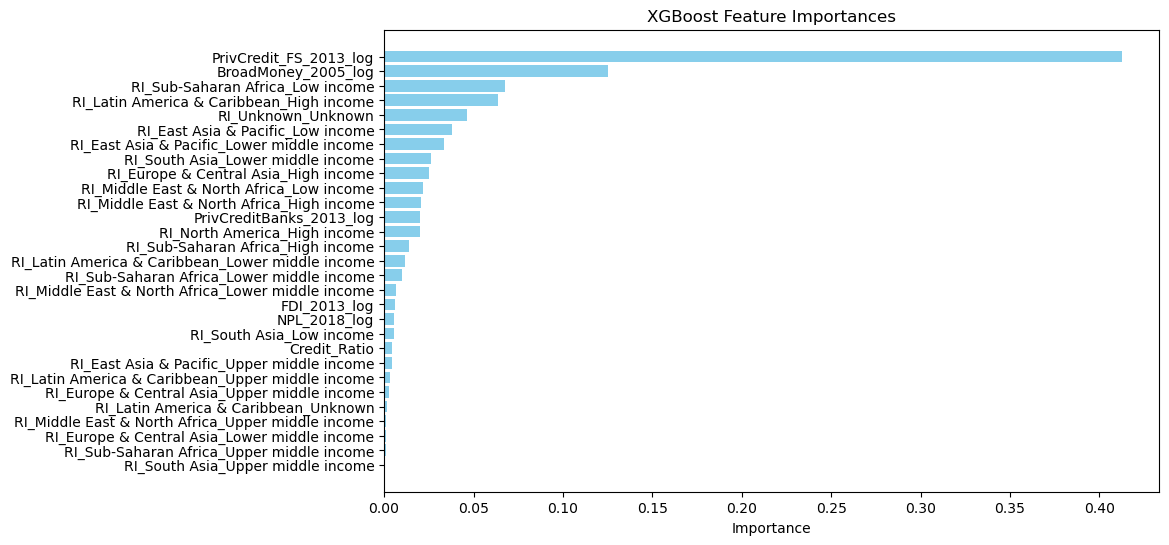

In [1337]:
# Get the feature importances from the best XGBoost model
feature_importances = best_xgb.feature_importances_

# Create a DataFrame for easy plotting and interpretation.
# Make sure the feature names match those in X_train_final.
importance_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance DataFrame
print(importance_df)

# Plot a horizontal bar chart for better readability
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

#### Interpretation of the Results
Based on the XGBoost feature importances, Credit_Depth_PC overwhelmingly dominates, suggesting that credit-related variables strongly explain Financial_Depth_log. We also see a meaningful contribution from certain region-income categories, notably RI_South Asia_Low income. If our policy goal is to highlight other levers (beyond improving credit depth), we might experiment with removing or adjusting Credit_Depth_PC and reevaluating feature importances. Alternatively, if maximizing predictive accuracy is paramount, we can retain Credit_Depth_PC and focus on verifying whether additional fine-tuning yields incremental gains.

### 6.8 Model Interpretation with SHAP

#### Rationale:

Although our XGBoost model shows strong predictive performance (Test R²: 0.92, RMSE: 0.28) and our feature importance analysis highlights the dominance of PrivCredit_FS_2013_log and the influence of several Region_Income dummies, we need to gain a deeper understanding of how these features contribute to individual predictions.

sing SHAP (SHapley Additive exPlanations) will allow us to:
- Visualize the global importance of features
- Understand how each feature influences predictions for specific countries
- Confirm the insights from our feature importance analysis and assess any nonlinear interactions

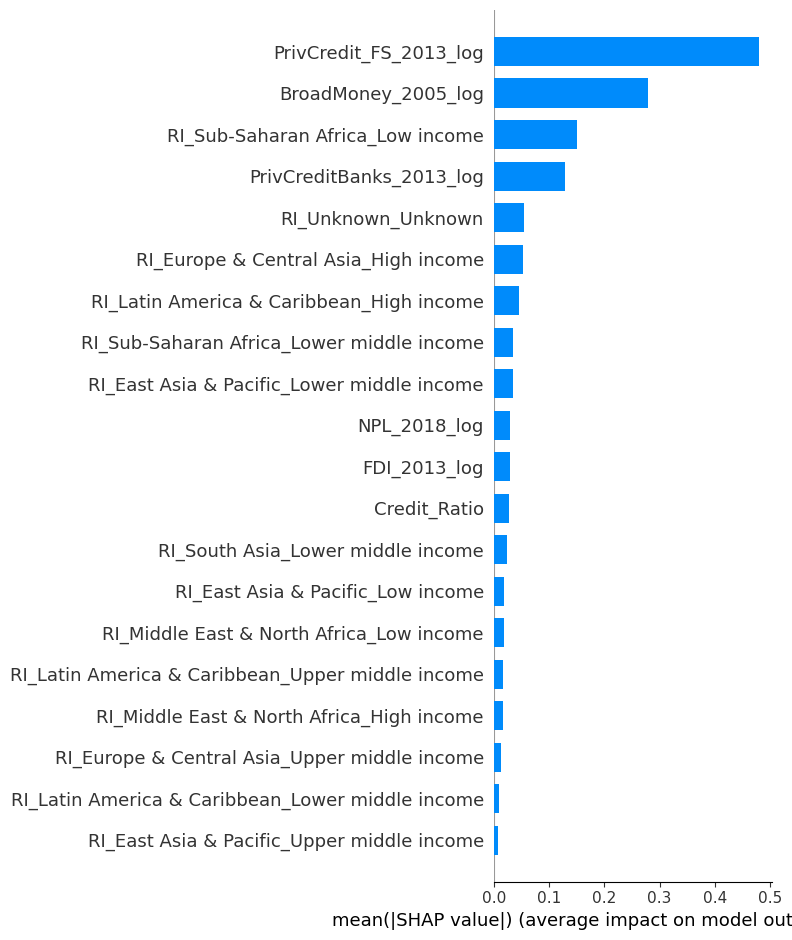

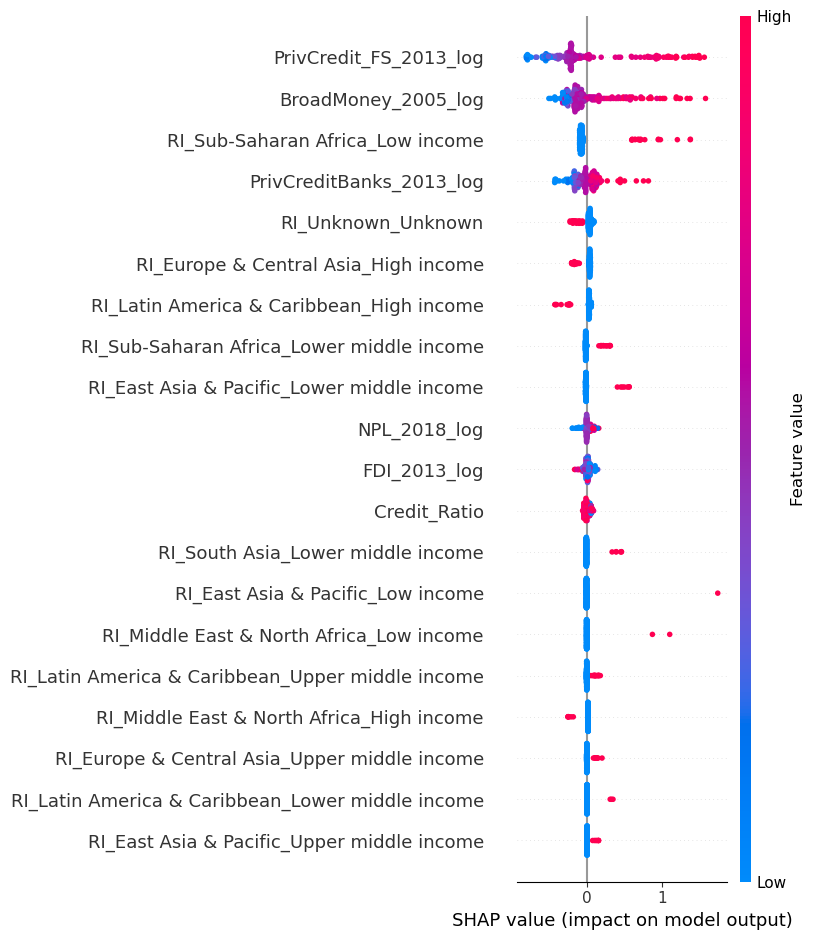

In [1338]:
# Step 2: Create a SHAP explainer using our best XGBoost model
explainer = shap.TreeExplainer(best_xgb)

# Step 3: Compute SHAP values for the training set (or a representative subset)
shap_values = explainer.shap_values(X_train_final)

# Step 4: Generate a summary plot to visualize global feature importance
shap.summary_plot(shap_values, X_train_final, plot_type="bar")

# Step 5: Generate a detailed summary plot to visualize feature effects and interactions
shap.summary_plot(shap_values, X_train_final)

### 6.9 Domain-Based Interpretation

The SHAP results indicate that even after normalizing financial depth by income group (via the `Financial_Depth_z` target), several of the one-hot encoded Region_Income dummy variables remain highly influential. This finding suggests that there are important regional or subgroup effects beyond what is captured by income normalization alone. For example, certain regions may consistently outperform or underperform their income peers due to differences in policy environments, regulatory frameworks, or institutional quality.
To better understand these nuances, our next step is to investigate why specific regions deviate from the norm. Two potential approaches include:

1. **Partial Dependence Plots (PDPs):**  
   PDPs can help visualize how changes in one or two key predictors (for instance, `PrivCredit_FS_2013_log` and `BroadMoney_2005_log`) affect the predicted relative financial depth while averaging out the effects of other variables. This will allow us to see whether the interaction between credit supply and money supply has a multiplicative effect on performance relative to the income-group average.

2. **SHAP Interaction Plots:**  
   By exploring SHAP interaction values, we can quantify and visualize how pairs of features (e.g., the interaction between `PrivCredit_FS_2013_log` and `BroadMoney_2005_log`) jointly influence the model's output. This method provides a deeper understanding of whether the combined effect of these credit measures is more (or less) than the sum of their individual impacts.

Investigating these interactions will not only refine our model’s interpretability but will also yield actionable insights. For instance, if the joint effect of high private sector credit and ample broad money supply drives a country significantly above its income-group average, this could inform targeted policy interventions to strengthen financial development in underperforming regions.
The next step is to generate these plots and analyze the interactions further.

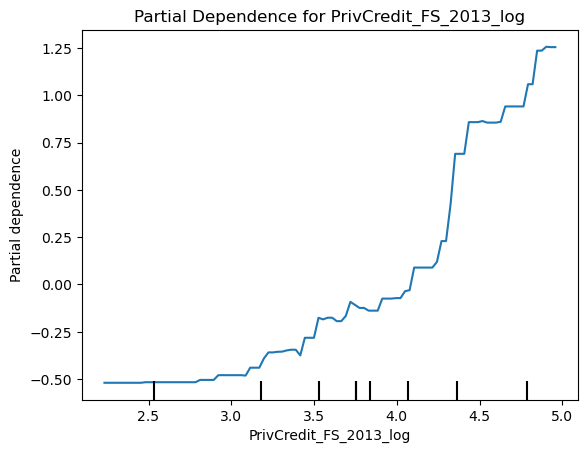

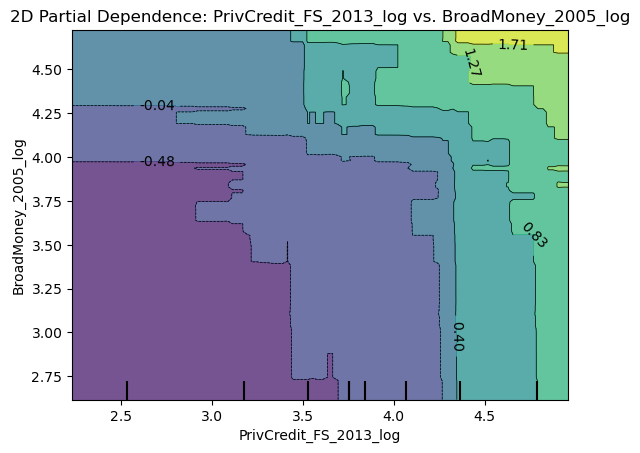

In [1339]:
# =============================================================================

# Domain-Based Interpretation: Partial Dependence Plots

# =============================================================================

# 1. Single Feature Partial Dependence:
features_single = ["PrivCredit_FS_2013_log"]

PartialDependenceDisplay.from_estimator(
    best_xgb,                # the best XGBoost model from earlier
    X_train_final,           # training data (including numeric and one-hot encoded features)
    features=features_single,
    feature_names=X_train_final.columns,
    kind="average"           # 'average' shows the partial dependence curve
)

plt.title("Partial Dependence for PrivCredit_FS_2013_log")
plt.show()

# 2. Two-Feature Partial Dependence:
# Investigate the interaction between PrivCredit_FS_2013_log and BroadMoney_2005_log.
features_pair = [("PrivCredit_FS_2013_log", "BroadMoney_2005_log")]

PartialDependenceDisplay.from_estimator(
    best_xgb,
    X_train_final,
    features=features_pair,
    feature_names=X_train_final.columns,
    kind="average"  # you could also use "both" to show ICE curves along with the average
)

plt.title("2D Partial Dependence: PrivCredit_FS_2013_log vs. BroadMoney_2005_log")
plt.show()

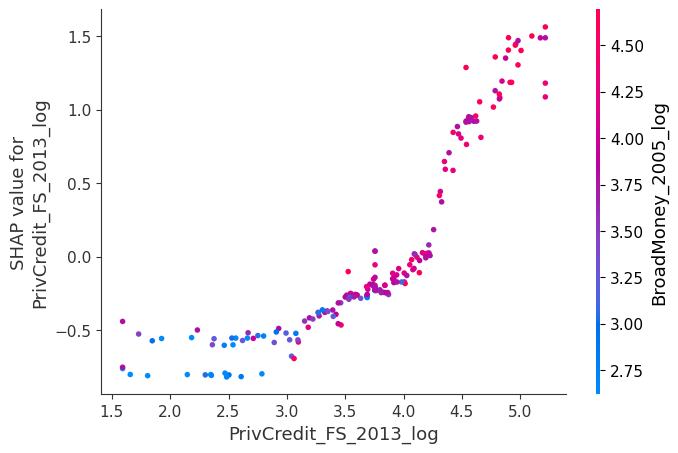

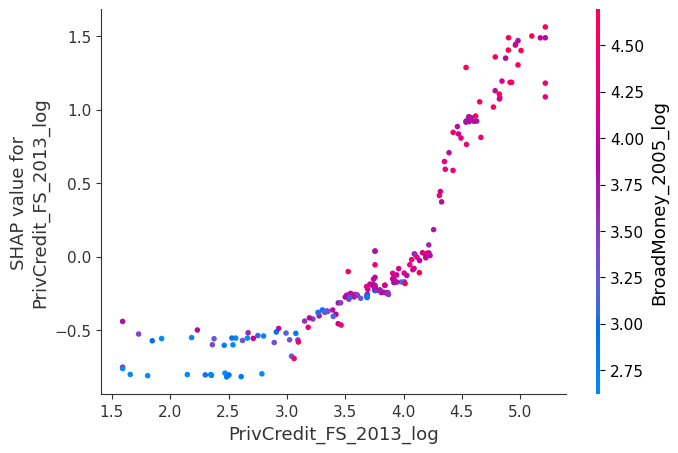

In [1340]:
# =============================================================================

# Domain-Based Interpretation: SHAP Dependence and Interaction Plots

# =============================================================================
# Create a SHAP explainer based on the best XGBoost model
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train_final)

# 1. SHAP Dependence Plot for a Single Feature:
# This shows how the value of PrivCredit_FS_2013_log impacts predictions.
shap.dependence_plot(
    "PrivCredit_FS_2013_log",  # feature to plot
    shap_values,               # computed SHAP values for the training set
    X_train_final,             # training data
    feature_names=X_train_final.columns
)

# 2. SHAP Dependence Plot with Interaction:
# Here, we explore the interaction effect between PrivCredit_FS_2013_log and BroadMoney_2005_log.

shap.dependence_plot(
    "PrivCredit_FS_2013_log",
    shap_values,
    X_train_final,
    feature_names=X_train_final.columns,
    interaction_index="BroadMoney_2005_log"  # shows how this feature moderates the effect of PrivCredit_FS_2013_log
)

#### 1. Review and Interpretation of the Partial Dependence Plots

The partial dependence plots provide insight into how changes in specific predictors affect the normalized target variable (Financial_Depth_z). For example, the plot for PrivCredit_FS_2013_log shows the average effect of changes in domestic credit to the private sector (from the financial sector) on the relative financial depth:



**Observation:** As the value of PrivCredit_FS_2013_log increases, the predicted Financial_Depth_z also increases. This indicates that higher domestic credit (in log-scale) is associated with a country performing above its income-group average in financial depth.



**Interpretation:** This suggests that the ability of a country to extend domestic credit to the private sector is a critical factor in surpassing the typical financial system development for its income level.



When examining the 2D partial dependence plot for the interaction between PrivCredit_FS_2013_log and BroadMoney_2005_log:



**Observation:** The plot shows how the combined levels of private sector credit and broad money influence the target variable. For instance, it may reveal that when BroadMoney_2005_log is high, the effect of increasing PrivCredit_FS_2013_log on Financial_Depth_z might be amplified (or possibly dampened).



**Interpretation:** These interactions can hint that countries with both a high level of broad money supply and high domestic credit to the private sector tend to significantly outperform their income peers in financial depth.



#### 2. Investigation of Regional/Subgroup Effects Using SHAP

SHAP dependence plots further enhance our understanding:


**Single-Feature SHAP Plot:** The SHAP plot for PrivCredit_FS_2013_log confirms its dominant role. By observing the spread of SHAP values, we see how incremental increases in this feature shift predictions upward (i.e., toward a higher Financial_Depth_z). This provides a direct, interpretable measure of the feature's influence.



**Interaction Plot**: When setting interaction_index="BroadMoney_2005_log", the plot illustrates how the effect of PrivCredit_FS_2013_log on Financial_Depth_z varies with the level of BroadMoney_2005_log. For example, if countries with higher BroadMoney_2005_log show steeper SHAP value gradients, this would suggest an amplified impact on relative financial performance.



Furthermore, the feature importance analysis reveals that several Region_Income dummy variables hold non-negligible importance. This indicates that even after normalization by income group, regional effects persist—implying that structural, policy, or institutional factors tied to geography play a role in relative financial development.

### 7. Results in a Business Context

### 7.1 Business Questions

#### 1. What are the key financial indicators that influence economic performance and stability?
We examine variables such as **FDI_2013_log**, **NPL_2018_log**, and various credit measures (e.g., **PrivCredit_FS_2013_log**, **BroadMoney_2005_log**).


- **FDI_2013_log**  

  *Definition:* The logarithm of foreign direct investment (FDI) as a percentage of GDP in 2013. This transformation reduces skewness and helps capture external capital inflows, which reflect a country’s attractiveness to foreign investors.<br><br>



- **NPL_2018_log**  

  *Definition:* The logarithm of bank nonperforming loans (NPL) as a percentage of total loans in 2018. It measures asset quality and credit risk in the banking sector, with the log transformation helping to normalize the distribution.<br><br>



- **PrivCredit_FS_2013_log**  

  *Definition:* The logarithm of domestic credit provided to the private sector by the financial sector in 2013. This is a key indicator of how effectively a country’s financial system supports private sector credit needs. Our analysis reveals that this variable is especially dominant, suggesting it is a major driver of relative financial system development.<br><br>



- **BroadMoney_2005_log**  

  *Definition:* The logarithm of broad money supply as a percentage of GDP in 2005. This variable captures the overall liquidity in the economy and reflects the scale of financial intermediation.



#### 2. How do the impacts of these indicators differ across regions and income groups?



By normalizing **Financial_Depth** within income groups—creating **Financial_Depth_z**—we isolate the effect of each predictor relative to its peers.



- **Financial_Depth_z**  

  *Definition:* A normalized (z-scored) version of the composite measure **Financial_Depth**, calculated within each income group. It indicates how many standard deviations a country’s overall financial development deviates from the income-group average, enabling “apples-to-apples” comparisons.



The inclusion of one-hot encoded **Region_Income** dummies further highlights that even after income normalization, regional effects persist.



- **Region_Income**  

  *Definition:* A composite categorical variable that combines a country’s region and its income group. It is one-hot encoded to capture the interaction effects between regional context and income level, facilitating more detailed subgroup comparisons.



For example, countries in certain regions (e.g., Sub-Saharan Africa or Latin America) show systematic deviations from their income-group norms, which may be due to structural or policy differences.



#### 3. Can we use a composite measure to summarize the financial system’s development effectively?



We developed composite measures like **Financial_Depth** (and its log-transformed and normalized versions) to capture overall financial development.



- **Financial_Depth**  

  *Definition:* A composite index that aggregates several credit-related indicators (such as credit measures and money supply). Its normalized form, **Financial_Depth_z**, is particularly useful for comparing countries on a level playing field across different income groups.



#### 4. What policy measures could enhance financial development and stability based on these indicators?



Our feature importance analysis and SHAP visualizations indicate that credit measures (especially **PrivCredit_FS_2013_log**) and money supply (e.g., **BroadMoney_2005_log**) are strong predictors of relative performance.



This suggests that policies aimed at strengthening the domestic credit environment and ensuring stable money supply management may be crucial.



Furthermore, persistent regional effects imply that tailored reforms—such as improving regulatory frameworks in regions that underperform relative to their peers—could yield significant benefits.



---



### 7.2 Key Findings from Advanced Model Outputs



### Feature Importance & SHAP Analysis



- **Dominant Role of Credit Measures:**  

  - **PrivCredit_FS_2013_log** exhibits very high importance (~0.41), underscoring that the ability to extend private sector credit from the financial sector is a critical driver of superior financial depth.  

  - **BroadMoney_2005_log** follows, suggesting that the availability of broad money also plays a significant role.



- **Regional/Subgroup Effects:**  

  - Several **Region_Income** dummy variables rank high among predictors, indicating that beyond the core financial metrics, the regional context and its interaction with income level are essential in explaining deviations from expected financial development.



- **Moderate Influence of Other Predictors:**  

  - **FDI_2013_log** and **NPL_2018_log** show modest correlations with **Financial_Depth_z**. Although they add unique dimensions (e.g., capturing foreign investment and nonperforming loans), their marginal impact is lower compared to the dominant credit measures.



### Partial Dependence & Interaction Effects



- **Partial Dependence of PrivCredit_FS_2013_log:**  

  The partial dependence plot for **PrivCredit_FS_2013_log** indicates that, on average, increases in this variable are associated with higher **Financial_Depth_z**.



  When combined with **BroadMoney_2005_log** in a 2D plot, the interaction reveals that the effect of private sector credit on relative financial depth may be amplified (or moderated) depending on the level of broad money supply.<br><br>



- **SHAP Interaction Insights:**
  SHAP dependence plots confirm the strong influence of **PrivCredit_FS_2013_log** on predictions and illustrate how its effect varies with **BroadMoney_2005_log**. These visualizations help pinpoint thresholds or nonlinear patterns, offering clues to policymakers on where incremental improvements may have the greatest impact.



---



### 7.3 Domain-Based Interpretation & Policy Implications



Based on these results, several hypotheses and policy implications emerge:

- **Hypothesis 1:**  
  Higher values of **PrivCredit_FS_2013_log** drive a country’s performance above its income-group average, likely reflecting more efficient credit extension and better-regulated financial systems.  

  **Policy Implication:** Enhance mechanisms that support the expansion and prudent management of private credit.<br><br>


- **Hypothesis 2:**  
  The interaction between **PrivCredit_FS_2013_log** and **BroadMoney_2005_log** indicates that a robust money supply can magnify the positive effects of credit expansion.  

  **Policy Implication:** Ensure monetary policies promote sufficient liquidity without inducing inflation, thereby stabilizing credit flows.<br><br>


- **Hypothesis 3:**  
  Significant regional effects (via **Region_Income** dummies) suggest that structural and institutional factors unique to regions play a crucial role.  

  **Policy Implication:** Tailor regulatory and institutional reforms to address the specific challenges of underperforming regions. For example, countries in “RI_Sub-Saharan Africa_Low income” might benefit from targeted improvements in financial oversight and access to capital markets.

# Conclusion



In this notebook, we set out to answer several key questions about how different financial indicators influence a country’s economic performance and stability. To do this, we developed a composite measure of financial development and then normalized it within income groups (creating the variable **Financial_Depth_z**). This normalization allows us to compare countries on a “level playing field” by showing how many standard deviations each country’s financial development is above or below the average for countries with a similar income level.



## Key Findings



### Normalized Financial Depth

By converting our raw composite measure into a normalized z-score (**Financial_Depth_z**), we removed the broad effects that come simply from being a high- or low-income country. Instead, we focused on how a country performs relative to its peers.



### Dominant Role of Credit Measures

Our analysis shows that the log-transformed domestic credit provided to the private sector (**PrivCredit_FS_2013_log**) is by far the most influential predictor, with an importance score of about 0.41. This indicates that how well a country can extend credit to private businesses is a major factor in exceeding the typical financial development of its income group. The measure of broad money supply (**BroadMoney_2005_log**), which reflects the overall liquidity or available money in an economy, also plays a significant role.



### Moderate Influence of Other Indicators

While the log-transformed measures for foreign direct investment (**FDI_2013_log**) and bank nonperforming loans (**NPL_2018_log**) provide additional insights—by capturing aspects like foreign investment and credit risk—their individual contributions are smaller compared to the dominant credit measures.



### Persistent Regional Effects

We also included a feature that combines a country’s region and income level (**Region_Income**). Even after normalizing for income, the one-hot encoded dummies for this variable still add predictive power. This suggests that regional factors—such as differences in regulatory environments or institutional quality—affect financial development beyond what is captured by income level alone.



### Advanced Model Performance

Our baseline linear regression model, which is easy to interpret, performed well. More advanced ensemble methods like Random Forests and especially XGBoost further improved performance. For instance, our best XGBoost model achieved a test R² of 0.92 and an RMSE of 0.28, indicating robust predictive power.



## Domain-Based Interpretation & Policy Implications



### Enhancing Private Credit

The strong influence of **PrivCredit_FS_2013_log** suggests that a country’s ability to provide credit to its private sector is crucial. In simple terms, if banks and other financial institutions can lend more effectively to businesses, this tends to lift a country’s financial performance above what would be expected based on its income group. Policies that improve lending practices and strengthen financial regulation could therefore be beneficial.



### Monetary Policy and Liquidity

The significance of **BroadMoney_2005_log** indicates that the overall supply of money in an economy is important. Stable and adequate liquidity (the availability of money) can support business activity and credit flow. Thus, policymakers might focus on managing the money supply carefully to avoid issues like inflation while still providing enough capital for growth.



### Regional Tailoring

The persistent predictive power of the **Region_Income** variable suggests that geographic factors matter. Some regions consistently perform better or worse than others, which might be due to differences in policy, regulation, or institutional strength. This finding implies that reforms should be tailored to regional challenges—for example, strengthening financial oversight in regions that underperform relative to their peers.



## Limitations & Next Steps



### Data Completeness

Some variables (such as **NPL_2018_log**) required imputation because of missing values. Future work might explore more advanced imputation techniques or additional data sources to improve the analysis.



### Model Enhancements

While our advanced models (especially XGBoost) performed very well, further exploration of interaction effects and other ensemble methods might uncover even more nuanced relationships.


---



In summary, our analysis shows that a normalized composite measure of financial development (**Financial_Depth_z**) effectively captures the nuanced impact of various financial indicators. The dominant role of credit measures, along with persistent regional effects, provides clear, actionable insights that can guide policy reforms aimed at enhancing financial stability and performance.